In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from vaneska.models import Gaussian, KeplerPRF
from vaneska.photometry import PSFPhotometry

from lightkurve import KeplerTargetPixelFile, LightCurve

from tqdm import tqdm
import kplr

from matplotlib import rcParams
rcParams["figure.dpi"] = 150

In [66]:
client = kplr.API()
kic = client.star(9595686)

In [67]:
pixels = kic.get_target_pixel_files()

In [15]:
for i, pixel_file in enumerate(pixels):
    try:
        with pixel_file.open() as f:
            # ...
            # The raw image is in:
            data = f[1].data
            time = data["time"]  # in (Kepler)BJD
            imgs = data["flux"]
            print("Image shape: {0}".format(imgs[0].shape))
            print(pixels[i].url)
    except HTTPError:
        print("The file at {0} doesn't exist".format(pixel_file.url))
        


Image shape: (4, 5)
http://archive.stsci.edu/pub/kepler/target_pixel_files/0095/009595686/kplr009595686-2009166043257_lpd-targ.fits.gz
Image shape: (4, 5)
http://archive.stsci.edu/pub/kepler/target_pixel_files/0095/009595686/kplr009595686-2009259160929_lpd-targ.fits.gz
Image shape: (4, 5)
http://archive.stsci.edu/pub/kepler/target_pixel_files/0095/009595686/kplr009595686-2009350155506_lpd-targ.fits.gz
Image shape: (4, 5)
http://archive.stsci.edu/pub/kepler/target_pixel_files/0095/009595686/kplr009595686-2010078095331_lpd-targ.fits.gz
Image shape: (4, 5)
http://archive.stsci.edu/pub/kepler/target_pixel_files/0095/009595686/kplr009595686-2010174085026_lpd-targ.fits.gz
Image shape: (4, 5)
http://archive.stsci.edu/pub/kepler/target_pixel_files/0095/009595686/kplr009595686-2010265121752_lpd-targ.fits.gz
Image shape: (4, 5)
http://archive.stsci.edu/pub/kepler/target_pixel_files/0095/009595686/kplr009595686-2010355172524_lpd-targ.fits.gz
Image shape: (4, 5)
http://archive.stsci.edu/pub/kepler

In [69]:
#tpf1 = KeplerTargetPixelFile('/Users/ozymandias1/.kplr/data/target_pixel_files/006507433/kplr006507433-2012004120508_lpd-targ.fits.gz')
#tpf2 = KeplerTargetPixelFile('/Users/ozymandias1/.kplr/data/target_pixel_files/006507427/kplr006507427-2012004120508_lpd-targ.fits.gz')

#tpf = KeplerTargetPixelFile('/Users/ozymandias1/.kplr/data/target_pixel_files/009595686/kplr009595686-2011271113734_lpd-targ.fits.gz')
tpf2 = KeplerTargetPixelFile.from_archive(6507427, quarter=8)

Found 1 File(s)


INFO:astropy:Found cached file ./mastDownload/Kepler/kplr006507427_lc_Q011111111111111111/kplr006507427-2011073133259_lpd-targ.fits.gz with expected size 1290186.


INFO: Found cached file ./mastDownload/Kepler/kplr006507427_lc_Q011111111111111111/kplr006507427-2011073133259_lpd-targ.fits.gz with expected size 1290186. [astroquery.query]


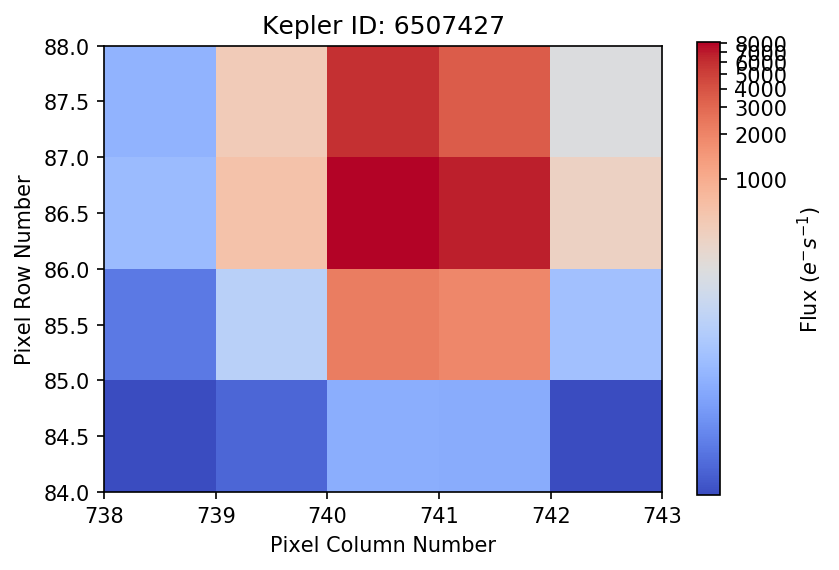

In [70]:
tpf2.plot(cmap='coolwarm', interpolation='nearest', scale='log')
plt.show()

In [71]:
tpf2.centroids()

(array([740.92768372, 740.92794923, 740.92766355, ..., 740.93280068,
        740.93302024, 740.93298857]),
 array([86.29568303, 86.29605177, 86.29620055, ..., 86.39099179,
        86.39087338, 86.39101324]))

In [72]:
flux1 = tf.Variable(initial_value=5e3, dtype=tf.float64)
flux2 = tf.Variable(initial_value=1e3, dtype=tf.float64)

col1 = tf.Variable(initial_value=740., dtype=tf.float64)
col2 = tf.Variable(initial_value=740., dtype=tf.float64)

row1 = tf.Variable(initial_value=87., dtype=tf.float64)
dy = tf.Variable(initial_value=3., dtype=tf.float64)
row2 = tf.Variable(initial_value=86., dtype=tf.float64)

a = tf.Variable(initial_value=1., dtype=tf.float64)
b = tf.Variable(initial_value=0., dtype=tf.float64)
c = tf.Variable(initial_value=1., dtype=tf.float64)

bkg = tf.Variable(initial_value=np.nanmedian(tpf2.flux[0]), dtype=tf.float64)

In [73]:
gaussian = Gaussian(shape=tpf2.shape[1:], col_ref=tpf2.column, row_ref=tpf2.row)

In [74]:
mean = gaussian(flux1, col1, row1, a, b, c) + gaussian(flux2, col2, row2, a, b, c) + bkg


In [77]:
data = tf.placeholder(dtype=tf.float64, shape=tpf2.flux[0].shape)
loss = tf.reduce_sum(tf.squared_difference(mean, data))
var_list = [flux1, flux2, col1, col2, row1, row2, a, b, c, bkg]
grad = tf.gradients(loss, var_list)


In [78]:
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=loss, var_list=var_list, method='TNC')


In [79]:
psf_flux1 = []
psf_flux2 = []

In [80]:
with tf.Session() as session:
    session.run(fetches=tf.global_variables_initializer())
    phot = PSFPhotometry(optimizer=optimizer)
    results = phot.fit(pixel_flux=tpf2.flux, data_placeholder=data,
                       var_list=var_list, session=session)

  0%|          | 0/3113 [00:00<?, ?it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 6923137.285493
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 6923137.285493
  Number of iterations: 18
  Number of functions evaluations: 100
  0%|          | 1/3113 [00:00<22:04,  2.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 6702420.840932
  Number of iterations: 5
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 6702420.840932
  Number of iterations: 5
  Number of functions evaluations: 100
  0%|          | 2/3113 [00:00<15:34,  3.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 899880.293284
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 899880.293284
  Number of iterations: 17
  Number of functions evaluations: 100
  0%|          | 3/3113 [00:00<12:51,  4.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 183530.002655
  Number of iterations: 12
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 183530.002655
  Number of iterations: 12
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 181786.394934
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 181786.394934
  Number of iterations: 20
  Number of functions evaluations: 100
  0%|          | 5/3113 [00:00<09:58,  5.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 183218.519148
  Number of iterations: 22
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 183218.519148
  Number of iterations: 22
  Number of functions evaluations: 100
  0%|          | 6/3113 [00:01<09:33,  5.42it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 184051.017797
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 184051.017797
  Number of iterations: 20
  Number of functions evaluations: 100
  0%|          | 7/3113 [00:01<09:13,  5.61it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 183867.398877
  Number of iterations: 19
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 183867.398877
  Number of iterations: 19
  Number of functions evaluations: 82
  0%|          | 8/3113 [00:01<08:53,  5.82it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 183774.473315
  Number of iterations: 22
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 183774.473315
  Number of iterations: 22
  Number of functions evaluations: 100
  0%|          | 9/3113 [00:01<08:40,  5.97it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 184860.524001
  Number of iterations: 22
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 184860.524001
  Number of iterations: 22
  Number of functions evaluations: 100
  0%|          | 10/3113 [00:01<08:37,  6.00it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 182607.283896
  Number of iterations: 13
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 182607.283896
  Number of iterations: 13
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 183373.909071
  Number of iterations: 14
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 183373.909071
  Number of iterations: 14
  Number of functions evaluations: 58
  0%|          | 12/3113 [00:01<07:56,  6.51it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 181903.718459
  Number of iterations: 22
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 181903.718459
  Number of iterations: 22
  Number of functions evaluations: 100
  0%|          | 13/3113 [00:01<07:51,  6.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 183734.573439
  Number of iterations: 19
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 183734.573439
  Number of iterations: 19
  Number of functions evaluations: 74
  0%|          | 14/3113 [00:02<07:42,  6.70it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 182498.923338
  Number of iterations: 17
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 182498.923338
  Number of iterations: 17
  Number of functions evaluations: 78
  0%|          | 15/3113 [00:02<07:35,  6.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 183140.879879
  Number of iterations: 20
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 183140.879879
  Number of iterations: 20
  Number of functions evaluations: 85
  1%|          | 16/3113 [00:02<07:30,  6.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 179684.876534
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 179684.876534
  Number of iterations: 20
  Number of functions evaluations: 100
  1%|          | 17/3113 [00:02<07:29,  6.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 110077.431998
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 110077.431998
  Number of iterations: 19
  Number of functions evaluations: 100
  1%|          | 18/3113 [00:02<07:26,  6.93it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 44975.423104
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 44975.423104
  Number of iterations: 14
  Number of functions evaluations: 100
  1%|          | 19/3113 [00:02<07:23,  6.98it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 43447.755004
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 43447.755004
  Number of iterations: 19
  Number of functions evaluations: 100
  1%|          | 20/3113 [00:02<07:21,  7.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 43003.305564
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 43003.305564
  Number of iterations: 15
  Number of functions evaluations: 100
  1%|          | 21/3113 [00:03<07:21,  7.00it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40695.890264
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40695.890264
  Number of iterations: 14
  Number of functions evaluations: 100
  1%|          | 22/3113 [00:03<07:20,  7.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40420.993368
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40420.993368
  Number of iterations: 19
  Number of functions evaluations: 100
  1%|          | 23/3113 [00:03<07:18,  7.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40363.568892
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40363.568892
  Number of iterations: 19
  Number of functions evaluations: 100
  1%|          | 24/3113 [00:03<07:17,  7.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40570.734734
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40570.734734
  Number of iterations: 19
  Number of functions evaluations: 100
  1%|          | 25/3113 [00:03<07:16,  7.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39973.058409
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39973.058409
  Number of iterations: 19
  Number of functions evaluations: 100
  1%|          | 26/3113 [00:03<07:14,  7.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39131.730967
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39131.730967
  Number of iterations: 18
  Number of functions evaluations: 100
  1%|          | 27/3113 [00:03<07:13,  7.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40220.770339
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40220.770339
  Number of iterations: 18
  Number of functions evaluations: 100
  1%|          | 28/3113 [00:03<07:11,  7.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39629.432838
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39629.432838
  Number of iterations: 19
  Number of functions evaluations: 100
  1%|          | 29/3113 [00:04<07:09,  7.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39718.298079
  Number of iterations: 5
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39718.298079
  Number of iterations: 5
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40665.190827
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40665.190827
  Number of iterations: 20
  Number of functions evaluations: 100
  1%|          | 31/3113 [00:04<06:59,  7.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38901.969360
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38901.969360
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39330.661739
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39330.661739
  Number of iterations: 7
  Number of functions evaluations: 32
  1%|          | 33/3113 [00:04<06:46,  7.57it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40598.225088
  Number of iterations: 19
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40598.225088
  Number of iterations: 19
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39951.522566
  Number of iterations: 14
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39951.522566
  Number of iterations: 14
  Number of functions evaluations: 68
  1%|          | 35/3113 [00:04<06:42,  7.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39379.403108
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39379.403108
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40246.346906
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40246.346906
  Number of iterations: 18
  Number of functions evaluations: 100
  1%|          | 37/3113 [00:04<06:46,  7.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39396.372171
  Number of iterations: 5
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39396.372171
  Number of iterations: 5
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40183.500642
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40183.500642
  Number of iterations: 20
  Number of functions evaluations: 100
  1%|▏         | 39/3113 [00:05<06:43,  7.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39781.399919
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39781.399919
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39470.397317
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39470.397317
  Number of iterations: 17
  Number of functions evaluations: 100
  1%|▏         | 41/3113 [00:05<06:41,  7.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41051.503978
  Number of iterations: 8
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41051.503978
  Number of iterations: 8
  Number of functions evaluations: 39
  1%|▏         | 42/3113 [00:05<06:39,  7.69it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40489.221284
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40489.221284
  Number of iterations: 17
  Number of functions evaluations: 100
  1%|▏         | 43/3113 [00:05<06:46,  7.56it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40078.596954
  Number of iterations: 11
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40078.596954
  Number of iterations: 11
  Number of functions evaluations: 58
  1%|▏         | 44/3113 [00:05<06:45,  7.57it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40958.473915
  Number of iterations: 11
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40958.473915
  Number of iterations: 11
  Number of functions evaluations: 50
  1%|▏         | 45/3113 [00:05<06:43,  7.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41150.573054
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41150.573054
  Number of iterations: 16
  Number of functions evaluations: 100
  1%|▏         | 46/3113 [00:06<06:49,  7.50it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39630.546591
  Number of iterations: 8
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39630.546591
  Number of iterations: 8
  Number of functions evaluations: 45
  2%|▏         | 47/3113 [00:06<06:47,  7.52it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40691.004438
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40691.004438
  Number of iterations: 18
  Number of functions evaluations: 100
  2%|▏         | 48/3113 [00:06<06:49,  7.49it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39417.178426
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39417.178426
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40789.889543
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40789.889543
  Number of iterations: 17
  Number of functions evaluations: 100
  2%|▏         | 50/3113 [00:06<06:45,  7.55it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40708.325368
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40708.325368
  Number of iterations: 18
  Number of functions evaluations: 100
  2%|▏         | 51/3113 [00:06<06:47,  7.52it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40647.615301
  Number of iterations: 12
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40647.615301
  Number of iterations: 12
  Number of functions evaluations: 69
  2%|▏         | 52/3113 [00:06<06:45,  7.55it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39411.815997
  Number of iterations: 9
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39411.815997
  Number of iterations: 9
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40166.011074
  Number of iterations: 15
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40166.011074
  Number of iterations: 15
  Number of functions evaluations: 79
  2%|▏         | 54/3113 [00:07<06:41,  7.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41205.050265
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41205.050265
  Number of iterations: 16
  Number of functions evaluations: 100
  2%|▏         | 55/3113 [00:07<06:42,  7.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41058.644481
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41058.644481
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40452.648257
  Number of iterations: 17
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40452.648257
  Number of iterations: 17
  Number of functions evaluations: 94
  2%|▏         | 57/3113 [00:07<06:41,  7.61it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40865.690197
  Number of iterations: 14
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40865.690197
  Number of iterations: 14
  Number of functions evaluations: 69
  2%|▏         | 58/3113 [00:07<06:40,  7.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40498.565006
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40498.565006
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40321.458975
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40321.458975
  Number of iterations: 4
  Number of functions evaluations: 14
  2%|▏         | 60/3113 [00:07<06:32,  7.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40918.982890
  Number of iterations: 7
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40918.982890
  Number of iterations: 7
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40905.897667
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40905.897667
  Number of iterations: 6
  Number of functions evaluations: 26
  2%|▏         | 62/3113 [00:07<06:26,  7.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40634.425509
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40634.425509
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39792.987588
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39792.987588
  Number of iterations: 17
  Number of functions evaluations: 100
  2%|▏         | 64/3113 [00:08<06:27,  7.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40444.143030
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40444.143030
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40540.870341
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40540.870341
  Number of iterations: 16
  Number of functions evaluations: 100
  2%|▏         | 66/3113 [00:08<06:32,  7.76it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40389.839457
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40389.839457
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 42104.003168
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 42104.003168
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40260.692859
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40260.692859
  Number of iterations: 2
  Number of functions evaluations: 9
  2%|▏         | 69/3113 [00:08<06:21,  7.99it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40247.805189
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40247.805189
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40362.600281
  Number of iterations: 14
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40362.600281
  Number of iterations: 14
  Number of functions evaluations: 81
  2%|▏         | 71/3113 [00:08<06:22,  7.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41051.562169
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41051.562169
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40279.314066
  Number of iterations: 11
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40279.314066
  Number of iterations: 11
  Number of functions evaluations: 56
  2%|▏         | 73/3113 [00:09<06:22,  7.95it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39933.828586
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39933.828586
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40424.762947
  Number of iterations: 15
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40424.762947
  Number of iterations: 15
  Number of functions evaluations: 89
  2%|▏         | 75/3113 [00:09<06:19,  8.00it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40076.020023
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40076.020023
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40474.176793
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40474.176793
  Number of iterations: 10
  Number of functions evaluations: 44
  2%|▏         | 77/3113 [00:09<06:13,  8.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41209.220998
  Number of iterations: 4
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41209.220998
  Number of iterations: 4
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40339.398693
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40339.398693
  Number of iterations: 17
  Number of functions evaluations: 100
  3%|▎         | 79/3113 [00:09<06:10,  8.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40668.400721
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40668.400721
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40813.594057
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40813.594057
  Number of iterations: 15
  Number of functions evaluations: 100
  3%|▎         | 81/3113 [00:09<06:10,  8.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40740.325194
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40740.325194
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41216.103256
  Number of iterations: 10
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41216.103256
  Number of iterations: 10
  Number of functions evaluations: 59
  3%|▎         | 83/3113 [00:10<06:06,  8.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40314.104860
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40314.104860
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40277.536153
  Number of iterations: 13
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40277.536153
  Number of iterations: 13
  Number of functions evaluations: 64
  3%|▎         | 85/3113 [00:10<06:05,  8.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40523.475118
  Number of iterations: 9
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40523.475118
  Number of iterations: 9
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40252.002973
  Number of iterations: 18
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40252.002973
  Number of iterations: 18
  Number of functions evaluations: 95
  3%|▎         | 87/3113 [00:10<06:03,  8.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40111.942205
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40111.942205
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41300.406274
  Number of iterations: 12
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41300.406274
  Number of iterations: 12
  Number of functions evaluations: 55
  3%|▎         | 89/3113 [00:10<06:02,  8.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40429.474083
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40429.474083
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40751.072846
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40751.072846
  Number of iterations: 15
  Number of functions evaluations: 100
  3%|▎         | 91/3113 [00:10<06:00,  8.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40300.114746
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40300.114746
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40659.768798
  Number of iterations: 10
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40659.768798
  Number of iterations: 10
  Number of functions evaluations: 42
  3%|▎         | 93/3113 [00:10<05:57,  8.46it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40075.457665
  Number of iterations: 14
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40075.457665
  Number of iterations: 14
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39574.434131
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39574.434131
  Number of iterations: 2
  Number of functions evaluations: 8
  3%|▎         | 95/3113 [00:11<05:53,  8.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40522.126136
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40522.126136
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40965.728537
  Number of iterations: 16
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40965.728537
  Number of iterations: 16
  Number of functions evaluations: 92
  3%|▎         | 97/3113 [00:11<05:54,  8.50it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40683.714527
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40683.714527
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40259.315903
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40259.315903
  Number of iterations: 4
  Number of functions evaluations: 15
  3%|▎         | 99/3113 [00:11<05:51,  8.57it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41345.252495
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41345.252495
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40539.947286
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40539.947286
  Number of iterations: 17
  Number of functions evaluations: 100
  3%|▎         | 101/3113 [00:11<05:49,  8.61it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41145.250058
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41145.250058
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40187.441506
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40187.441506
  Number of iterations: 17
  Number of functions evaluations: 100
  3%|▎         | 103/3113 [00:11<05:50,  8.59it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40262.262003
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40262.262003
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39977.231317
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39977.231317
  Number of iterations: 8
  Number of functions evaluations: 36
  3%|▎         | 105/3113 [00:12<05:46,  8.67it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40176.210978
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40176.210978
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40785.894421
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40785.894421
  Number of iterations: 15
  Number of functions evaluations: 100
  3%|▎         | 107/3113 [00:12<05:44,  8.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40934.882131
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40934.882131
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39721.674467
  Number of iterations: 16
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39721.674467
  Number of iterations: 16
  Number of functions evaluations: 87
  4%|▎         | 109/3113 [00:12<05:44,  8.71it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40771.785735
  Number of iterations: 6
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40771.785735
  Number of iterations: 6
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39791.179125
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39791.179125
  Number of iterations: 10
  Number of functions evaluations: 43
  4%|▎         | 111/3113 [00:12<05:41,  8.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39800.360246
  Number of iterations: 12
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39800.360246
  Number of iterations: 12
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40650.046082
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40650.046082
  Number of iterations: 8
  Number of functions evaluations: 33
  4%|▎         | 113/3113 [00:12<05:39,  8.84it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40097.660730
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40097.660730
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39856.717235
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39856.717235
  Number of iterations: 16
  Number of functions evaluations: 100
  4%|▎         | 115/3113 [00:12<05:38,  8.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41335.339807
  Number of iterations: 10
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41335.339807
  Number of iterations: 10
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40691.701835
  Number of iterations: 11
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40691.701835
  Number of iterations: 11
  Number of functions evaluations: 46
  4%|▍         | 117/3113 [00:13<05:36,  8.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40289.655265
  Number of iterations: 10
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40289.655265
  Number of iterations: 10
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40767.546152
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40767.546152
  Number of iterations: 8
  Number of functions evaluations: 33
  4%|▍         | 119/3113 [00:13<05:34,  8.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39450.741222
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39450.741222
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40022.310435
  Number of iterations: 13
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40022.310435
  Number of iterations: 13
  Number of functions evaluations: 66
  4%|▍         | 121/3113 [00:13<05:33,  8.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40547.621783
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40547.621783
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40138.581498
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40138.581498
  Number of iterations: 17
  Number of functions evaluations: 100
  4%|▍         | 123/3113 [00:13<05:32,  8.99it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40286.338082
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40286.338082
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39939.882688
  Number of iterations: 15
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39939.882688
  Number of iterations: 15
  Number of functions evaluations: 89
  4%|▍         | 125/3113 [00:13<05:31,  9.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40013.952515
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40013.952515
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40540.578102
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40540.578102
  Number of iterations: 8
  Number of functions evaluations: 34
  4%|▍         | 127/3113 [00:13<05:28,  9.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40529.811056
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40529.811056
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40198.896645
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40198.896645
  Number of iterations: 4
  Number of functions evaluations: 15
  4%|▍         | 129/3113 [00:14<05:27,  9.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40865.202338
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40865.202338
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41105.545122
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41105.545122
  Number of iterations: 2
  Number of functions evaluations: 9
  4%|▍         | 131/3113 [00:14<05:25,  9.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40196.492073
  Number of iterations: 15
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40196.492073
  Number of iterations: 15
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40248.418635
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40248.418635
  Number of iterations: 9
  Number of functions evaluations: 43
  4%|▍         | 133/3113 [00:14<05:24,  9.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40815.035487
  Number of iterations: 13
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40815.035487
  Number of iterations: 13
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40698.094290
  Number of iterations: 12
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40698.094290
  Number of iterations: 12
  Number of functions evaluations: 65
  4%|▍         | 135/3113 [00:14<05:23,  9.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41028.939511
  Number of iterations: 11
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41028.939511
  Number of iterations: 11
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40119.575860
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40119.575860
  Number of iterations: 15
  Number of functions evaluations: 100
  4%|▍         | 137/3113 [00:14<05:23,  9.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39890.889699
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39890.889699
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40146.846748
  Number of iterations: 8
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40146.846748
  Number of iterations: 8
  Number of functions evaluations: 28
  4%|▍         | 139/3113 [00:15<05:21,  9.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40061.985208
  Number of iterations: 14
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40061.985208
  Number of iterations: 14
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40523.901049
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40523.901049
  Number of iterations: 17
  Number of functions evaluations: 100
  5%|▍         | 141/3113 [00:15<05:21,  9.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40851.773426
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40851.773426
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40699.027323
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40699.027323
  Number of iterations: 5
  Number of functions evaluations: 24
  5%|▍         | 143/3113 [00:15<05:20,  9.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40043.298310
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40043.298310
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40432.070650
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40432.070650
  Number of iterations: 16
  Number of functions evaluations: 100
  5%|▍         | 145/3113 [00:15<05:21,  9.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40252.847192
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40252.847192
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40641.711799
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40641.711799
  Number of iterations: 17
  Number of functions evaluations: 100
  5%|▍         | 147/3113 [00:15<05:22,  9.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40828.020020
  Number of iterations: 13
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40828.020020
  Number of iterations: 13
  Number of functions evaluations: 100
  5%|▍         | 148/3113 [00:16<05:22,  9.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40042.990376
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40042.990376
  Number of iterations: 17
  Number of functions evaluations: 100
  5%|▍         | 149/3113 [00:16<05:23,  9.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41443.638591
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41443.638591
  Number of iterations: 18
  Number of functions evaluations: 100
  5%|▍         | 150/3113 [00:16<05:23,  9.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40323.204728
  Number of iterations: 11
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40323.204728
  Number of iterations: 11
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40334.271651
  Number of iterations: 9
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40334.271651
  Number of iterations: 9
  Number of functions evaluations: 47
  5%|▍         | 152/3113 [00:16<05:21,  9.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40134.185087
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40134.185087
  Number of iterations: 17
  Number of functions evaluations: 100
  5%|▍         | 153/3113 [00:16<05:22,  9.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36798.888332
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36798.888332
  Number of iterations: 18
  Number of functions evaluations: 100
  5%|▍         | 154/3113 [00:16<05:22,  9.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40798.401207
  Number of iterations: 13
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40798.401207
  Number of iterations: 13
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41246.162351
  Number of iterations: 14
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41246.162351
  Number of iterations: 14
  Number of functions evaluations: 63
  5%|▌         | 156/3113 [00:16<05:21,  9.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40220.465791
  Number of iterations: 12
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40220.465791
  Number of iterations: 12
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40403.125409
  Number of iterations: 7
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40403.125409
  Number of iterations: 7
  Number of functions evaluations: 34
  5%|▌         | 158/3113 [00:17<05:19,  9.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40956.549238
  Number of iterations: 12
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40956.549238
  Number of iterations: 12
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40797.488639
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40797.488639
  Number of iterations: 2
  Number of functions evaluations: 9
  5%|▌         | 160/3113 [00:17<05:18,  9.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40877.603972
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40877.603972
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40439.224901
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40439.224901
  Number of iterations: 10
  Number of functions evaluations: 48
  5%|▌         | 162/3113 [00:17<05:16,  9.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41621.280023
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41621.280023
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40119.952769
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40119.952769
  Number of iterations: 18
  Number of functions evaluations: 100
  5%|▌         | 164/3113 [00:17<05:15,  9.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40929.104245
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40929.104245
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40083.878732
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40083.878732
  Number of iterations: 9
  Number of functions evaluations: 37
  5%|▌         | 166/3113 [00:17<05:15,  9.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41558.083501
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41558.083501
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40731.733037
  Number of iterations: 11
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40731.733037
  Number of iterations: 11
  Number of functions evaluations: 53
  5%|▌         | 168/3113 [00:17<05:13,  9.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40319.601300
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40319.601300
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40466.335271
  Number of iterations: 9
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40466.335271
  Number of iterations: 9
  Number of functions evaluations: 36
  5%|▌         | 170/3113 [00:17<05:11,  9.46it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39979.772556
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39979.772556
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40638.249689
  Number of iterations: 6
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40638.249689
  Number of iterations: 6
  Number of functions evaluations: 21
  6%|▌         | 172/3113 [00:18<05:09,  9.51it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41024.632026
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41024.632026
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39520.043811
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39520.043811
  Number of iterations: 6
  Number of functions evaluations: 27
  6%|▌         | 174/3113 [00:18<05:08,  9.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40860.385051
  Number of iterations: 11
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40860.385051
  Number of iterations: 11
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40382.776222
  Number of iterations: 17
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40382.776222
  Number of iterations: 17
  Number of functions evaluations: 99
  6%|▌         | 176/3113 [00:18<05:07,  9.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41209.344372
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41209.344372
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40885.364381
  Number of iterations: 14
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40885.364381
  Number of iterations: 14
  Number of functions evaluations: 73
  6%|▌         | 178/3113 [00:18<05:08,  9.52it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40477.792097
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40477.792097
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41748.972460
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41748.972460
  Number of iterations: 9
  Number of functions evaluations: 40
  6%|▌         | 180/3113 [00:18<05:07,  9.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41515.998222
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41515.998222
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40903.906896
  Number of iterations: 11
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40903.906896
  Number of iterations: 11
  Number of functions evaluations: 60
  6%|▌         | 182/3113 [00:19<05:06,  9.56it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41246.880121
  Number of iterations: 16
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41246.880121
  Number of iterations: 16
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41040.709085
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41040.709085
  Number of iterations: 17
  Number of functions evaluations: 100
  6%|▌         | 184/3113 [00:19<05:06,  9.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41802.088219
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41802.088219
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 42002.536695
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 42002.536695
  Number of iterations: 8
  Number of functions evaluations: 37
  6%|▌         | 186/3113 [00:19<05:05,  9.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41337.940382
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41337.940382
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41962.385131
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41962.385131
  Number of iterations: 5
  Number of functions evaluations: 18
  6%|▌         | 188/3113 [00:19<05:04,  9.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40303.729278
  Number of iterations: 12
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40303.729278
  Number of iterations: 12
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41523.152123
  Number of iterations: 15
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41523.152123
  Number of iterations: 15
  Number of functions evaluations: 71
  6%|▌         | 190/3113 [00:19<05:04,  9.61it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40647.279489
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40647.279489
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41463.000167
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41463.000167
  Number of iterations: 17
  Number of functions evaluations: 100
  6%|▌         | 192/3113 [00:20<05:05,  9.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41055.509405
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41055.509405
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40627.589592
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40627.589592
  Number of iterations: 18
  Number of functions evaluations: 100
  6%|▌         | 194/3113 [00:20<05:05,  9.55it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40720.644674
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40720.644674
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41235.416356
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41235.416356
  Number of iterations: 9
  Number of functions evaluations: 42
  6%|▋         | 196/3113 [00:20<05:04,  9.59it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41108.481748
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41108.481748
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41274.239287
  Number of iterations: 11
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41274.239287
  Number of iterations: 11
  Number of functions evaluations: 54
  6%|▋         | 198/3113 [00:20<05:03,  9.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41345.049896
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41345.049896
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41687.627845
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41687.627845
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41369.807730
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41369.807730
  Number of iterations: 16
  Number of functions evaluations: 100
  6%|▋         | 201/3113 [00:20<05:02,  9.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40808.622115
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40808.622115
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41154.675493
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41154.675493
  Number of iterations: 18
  Number of functions evaluations: 100
  7%|▋         | 203/3113 [00:21<05:03,  9.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41046.709353
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41046.709353
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41461.997658
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41461.997658
  Number of iterations: 8
  Number of functions evaluations: 36
  7%|▋         | 205/3113 [00:21<05:01,  9.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40857.145892
  Number of iterations: 12
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40857.145892
  Number of iterations: 12
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41320.531286
  Number of iterations: 15
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41320.531286
  Number of iterations: 15
  Number of functions evaluations: 76
  7%|▋         | 207/3113 [00:21<05:01,  9.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40576.262766
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40576.262766
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40620.027128
  Number of iterations: 14
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40620.027128
  Number of iterations: 14
  Number of functions evaluations: 66
  7%|▋         | 209/3113 [00:21<05:00,  9.66it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41338.443167
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41338.443167
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40599.762023
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40599.762023
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41710.108751
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41710.108751
  Number of iterations: 2
  Number of functions evaluations: 9
  7%|▋         | 212/3113 [00:21<04:57,  9.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41031.837599
  Number of iterations: 16
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41031.837599
  Number of iterations: 16
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40753.858193
  Number of iterations: 8
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40753.858193
  Number of iterations: 8
  Number of functions evaluations: 40
  7%|▋         | 214/3113 [00:21<04:57,  9.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40154.002274
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40154.002274
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41139.192197
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41139.192197
  Number of iterations: 8
  Number of functions evaluations: 36
  7%|▋         | 216/3113 [00:22<04:55,  9.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41641.495195
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41641.495195
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40627.655188
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40627.655188
  Number of iterations: 8
  Number of functions evaluations: 34
  7%|▋         | 218/3113 [00:22<04:55,  9.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40474.626394
  Number of iterations: 14
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40474.626394
  Number of iterations: 14
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40353.719100
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40353.719100
  Number of iterations: 7
  Number of functions evaluations: 32
  7%|▋         | 220/3113 [00:22<04:54,  9.81it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41126.942524
  Number of iterations: 13
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41126.942524
  Number of iterations: 13
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40715.295488
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40715.295488
  Number of iterations: 17
  Number of functions evaluations: 100
  7%|▋         | 222/3113 [00:22<04:54,  9.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40160.920854
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40160.920854
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40273.107644
  Number of iterations: 9
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40273.107644
  Number of iterations: 9
  Number of functions evaluations: 35
  7%|▋         | 224/3113 [00:22<04:54,  9.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41680.247406
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41680.247406
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40059.632143
  Number of iterations: 5
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40059.632143
  Number of iterations: 5
  Number of functions evaluations: 27
  7%|▋         | 226/3113 [00:22<04:53,  9.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39882.625676
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39882.625676
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41285.035927
  Number of iterations: 11
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41285.035927
  Number of iterations: 11
  Number of functions evaluations: 54
  7%|▋         | 228/3113 [00:23<04:52,  9.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40850.244263
  Number of iterations: 15
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40850.244263
  Number of iterations: 15
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40934.597606
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40934.597606
  Number of iterations: 2
  Number of functions evaluations: 9
  7%|▋         | 230/3113 [00:23<04:51,  9.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40622.908486
  Number of iterations: 11
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40622.908486
  Number of iterations: 11
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40911.590716
  Number of iterations: 8
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40911.590716
  Number of iterations: 8
  Number of functions evaluations: 41
  7%|▋         | 232/3113 [00:23<04:50,  9.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40993.309278
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40993.309278
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40785.931885
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40785.931885
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40920.391966
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40920.391966
  Number of iterations: 4
  Number of functions evaluations: 19
  8%|▊         | 235/3113 [00:23<04:48,  9.98it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41479.591916
  Number of iterations: 13
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41479.591916
  Number of iterations: 13
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41378.234069
  Number of iterations: 17
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41378.234069
  Number of iterations: 17
  Number of functions evaluations: 80
  8%|▊         | 237/3113 [00:23<04:48,  9.98it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40781.191760
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40781.191760
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40515.414935
  Number of iterations: 14
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40515.414935
  Number of iterations: 14
  Number of functions evaluations: 69
  8%|▊         | 239/3113 [00:23<04:48,  9.97it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40214.203975
  Number of iterations: 13
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40214.203975
  Number of iterations: 13
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40467.223820
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40467.223820
  Number of iterations: 17
  Number of functions evaluations: 100
  8%|▊         | 241/3113 [00:24<04:48,  9.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40920.563141
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40920.563141
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40613.367556
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40613.367556
  Number of iterations: 5
  Number of functions evaluations: 18
  8%|▊         | 243/3113 [00:24<04:47,  9.97it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40836.155159
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40836.155159
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40899.423632
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40899.423632
  Number of iterations: 7
  Number of functions evaluations: 31
  8%|▊         | 245/3113 [00:24<04:46, 10.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40070.765922
  Number of iterations: 13
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40070.765922
  Number of iterations: 13
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40185.092088
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40185.092088
  Number of iterations: 7
  Number of functions evaluations: 30
  8%|▊         | 247/3113 [00:24<04:45, 10.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41152.017245
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41152.017245
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41409.401084
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41409.401084
  Number of iterations: 6
  Number of functions evaluations: 28
  8%|▊         | 249/3113 [00:24<04:44, 10.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40956.770066
  Number of iterations: 11
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40956.770066
  Number of iterations: 11
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41218.593184
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41218.593184
  Number of iterations: 16
  Number of functions evaluations: 100
  8%|▊         | 251/3113 [00:24<04:44, 10.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40427.624568
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40427.624568
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40663.322556
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40663.322556
  Number of iterations: 17
  Number of functions evaluations: 100
  8%|▊         | 253/3113 [00:25<04:44, 10.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40441.614875
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40441.614875
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40968.956398
  Number of iterations: 10
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40968.956398
  Number of iterations: 10
  Number of functions evaluations: 35
  8%|▊         | 255/3113 [00:25<04:44, 10.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40497.465075
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40497.465075
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40616.610440
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40616.610440
  Number of iterations: 16
  Number of functions evaluations: 100
  8%|▊         | 257/3113 [00:25<04:43, 10.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40092.639527
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40092.639527
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40750.539288
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40750.539288
  Number of iterations: 3
  Number of functions evaluations: 10
  8%|▊         | 259/3113 [00:25<04:43, 10.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39879.206466
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39879.206466
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40633.014270
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40633.014270
  Number of iterations: 19
  Number of functions evaluations: 100
  8%|▊         | 261/3113 [00:25<04:42, 10.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40753.849183
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40753.849183
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40590.170296
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40590.170296
  Number of iterations: 4
  Number of functions evaluations: 18
  8%|▊         | 263/3113 [00:26<04:42, 10.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40299.846395
  Number of iterations: 12
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40299.846395
  Number of iterations: 12
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39843.515559
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39843.515559
  Number of iterations: 7
  Number of functions evaluations: 31
  9%|▊         | 265/3113 [00:26<04:41, 10.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40396.300557
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40396.300557
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40909.908322
  Number of iterations: 17
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40909.908322
  Number of iterations: 17
  Number of functions evaluations: 80
  9%|▊         | 267/3113 [00:26<04:41, 10.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41660.395394
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41660.395394
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41255.307930
  Number of iterations: 11
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41255.307930
  Number of iterations: 11
  Number of functions evaluations: 43
  9%|▊         | 269/3113 [00:26<04:40, 10.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40278.768068
  Number of iterations: 9
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40278.768068
  Number of iterations: 9
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41138.117692
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41138.117692
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40158.814178
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40158.814178
  Number of iterations: 2
  Number of functions evaluations: 9
  9%|▊         | 272/3113 [00:26<04:37, 10.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40121.722638
  Number of iterations: 16
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40121.722638
  Number of iterations: 16
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39597.838596
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39597.838596
  Number of iterations: 16
  Number of functions evaluations: 100
  9%|▉         | 274/3113 [00:26<04:38, 10.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40409.309466
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40409.309466
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39595.988344
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39595.988344
  Number of iterations: 6
  Number of functions evaluations: 27
  9%|▉         | 276/3113 [00:27<04:38, 10.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40464.047847
  Number of iterations: 10
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40464.047847
  Number of iterations: 10
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39651.100650
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39651.100650
  Number of iterations: 3
  Number of functions evaluations: 11
  9%|▉         | 278/3113 [00:27<04:37, 10.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39308.749130
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39308.749130
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41788.603585
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41788.603585
  Number of iterations: 3
  Number of functions evaluations: 11
  9%|▉         | 280/3113 [00:27<04:36, 10.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39948.719342
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39948.719342
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39561.004879
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39561.004879
  Number of iterations: 17
  Number of functions evaluations: 100
  9%|▉         | 282/3113 [00:27<04:37, 10.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40169.186238
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40169.186238
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39954.217458
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39954.217458
  Number of iterations: 18
  Number of functions evaluations: 100
  9%|▉         | 284/3113 [00:27<04:37, 10.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39411.646859
  Number of iterations: 10
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39411.646859
  Number of iterations: 10
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40301.208865
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40301.208865
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40415.324388
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40415.324388
  Number of iterations: 5
  Number of functions evaluations: 21
  9%|▉         | 287/3113 [00:27<04:35, 10.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40433.441163
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40433.441163
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40206.609534
  Number of iterations: 16
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40206.609534
  Number of iterations: 16
  Number of functions evaluations: 87
  9%|▉         | 289/3113 [00:28<04:34, 10.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39249.475812
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39249.475812
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40378.269430
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40378.269430
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40727.854321
  Number of iterations: 12
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40727.854321
  Number of iterations: 12
  Number of functions evaluations: 100
  9%|▉         | 292/3113 [00:28<04:34, 10.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39080.272758
  Number of iterations: 12
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39080.272758
  Number of iterations: 12
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40587.907336
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40587.907336
  Number of iterations: 12
  Number of functions evaluations: 60
  9%|▉         | 294/3113 [00:28<04:35, 10.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40806.539795
  Number of iterations: 18
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40806.539795
  Number of iterations: 18
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40735.733766
  Number of iterations: 11
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40735.733766
  Number of iterations: 11
  Number of functions evaluations: 47
 10%|▉         | 296/3113 [00:28<04:34, 10.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40152.571876
  Number of iterations: 11
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40152.571876
  Number of iterations: 11
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40841.158415
  Number of iterations: 15
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40841.158415
  Number of iterations: 15
  Number of functions evaluations: 77
 10%|▉         | 298/3113 [00:29<04:34, 10.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40661.250778
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40661.250778
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39989.411196
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39989.411196
  Number of iterations: 16
  Number of functions evaluations: 100
 10%|▉         | 300/3113 [00:29<04:35, 10.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39786.995019
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39786.995019
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39400.721159
  Number of iterations: 3
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39400.721159
  Number of iterations: 3
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40683.092907
  Number of iterations: 17
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40683.092907
  Number of iterations: 17
  Number of functions evaluations: 98
 10%|▉         | 303/3113 [00:29<04:34, 10.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40208.235645
  Number of iterations: 16
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40208.235645
  Number of iterations: 16
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40173.019565
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40173.019565
  Number of iterations: 19
  Number of functions evaluations: 100
 10%|▉         | 305/3113 [00:29<04:34, 10.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39789.455396
  Number of iterations: 9
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39789.455396
  Number of iterations: 9
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41176.923832
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41176.923832
  Number of iterations: 15
  Number of functions evaluations: 100
 10%|▉         | 307/3113 [00:29<04:34, 10.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40183.956865
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40183.956865
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40058.338933
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40058.338933
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39075.698689
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39075.698689
  Number of iterations: 5
  Number of functions evaluations: 21
 10%|▉         | 310/3113 [00:30<04:32, 10.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40781.117789
  Number of iterations: 13
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40781.117789
  Number of iterations: 13
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40580.306990
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40580.306990
  Number of iterations: 6
  Number of functions evaluations: 25
 10%|█         | 312/3113 [00:30<04:31, 10.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39986.432002
  Number of iterations: 13
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39986.432002
  Number of iterations: 13
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39421.571291
  Number of iterations: 13
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39421.571291
  Number of iterations: 13
  Number of functions evaluations: 63
 10%|█         | 314/3113 [00:30<04:32, 10.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41197.668750
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41197.668750
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40158.119419
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40158.119419
  Number of iterations: 15
  Number of functions evaluations: 73
 10%|█         | 316/3113 [00:30<04:31, 10.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40464.199246
  Number of iterations: 12
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40464.199246
  Number of iterations: 12
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41493.860591
  Number of iterations: 16
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41493.860591
  Number of iterations: 16
  Number of functions evaluations: 80
 10%|█         | 318/3113 [00:30<04:31, 10.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40359.493530
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40359.493530
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39593.696653
  Number of iterations: 10
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39593.696653
  Number of iterations: 10
  Number of functions evaluations: 60
 10%|█         | 320/3113 [00:31<04:31, 10.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39151.070039
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39151.070039
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41953.388826
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41953.388826
  Number of iterations: 17
  Number of functions evaluations: 100
 10%|█         | 322/3113 [00:31<04:31, 10.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40080.862415
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40080.862415
  Number of iterations: 16
  Number of functions evaluations: 100
 10%|█         | 323/3113 [00:31<04:32, 10.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39518.610937
  Number of iterations: 15
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39518.610937
  Number of iterations: 15
  Number of functions evaluations: 98
 10%|█         | 324/3113 [00:31<04:32, 10.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39931.686177
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39931.686177
  Number of iterations: 15
  Number of functions evaluations: 100
 10%|█         | 325/3113 [00:31<04:32, 10.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40351.193023
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40351.193023
  Number of iterations: 17
  Number of functions evaluations: 100
 10%|█         | 326/3113 [00:31<04:32, 10.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40720.676892
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40720.676892
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40036.544955
  Number of iterations: 16
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40036.544955
  Number of iterations: 16
  Number of functions evaluations: 99
 11%|█         | 328/3113 [00:32<04:32, 10.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39592.257816
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39592.257816
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40524.640573
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40524.640573
  Number of iterations: 17
  Number of functions evaluations: 100
 11%|█         | 330/3113 [00:32<04:32, 10.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39955.512878
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39955.512878
  Number of iterations: 16
  Number of functions evaluations: 100
 11%|█         | 331/3113 [00:32<04:32, 10.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40431.445843
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40431.445843
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40125.094149
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40125.094149
  Number of iterations: 15
  Number of functions evaluations: 100
 11%|█         | 333/3113 [00:32<04:32, 10.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41561.587468
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41561.587468
  Number of iterations: 17
  Number of functions evaluations: 100
 11%|█         | 334/3113 [00:32<04:32, 10.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40362.572035
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40362.572035
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39610.199421
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39610.199421
  Number of iterations: 18
  Number of functions evaluations: 100
 11%|█         | 336/3113 [00:32<04:32, 10.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40500.591473
  Number of iterations: 12
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40500.591473
  Number of iterations: 12
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40313.447896
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40313.447896
  Number of iterations: 19
  Number of functions evaluations: 100
 11%|█         | 338/3113 [00:33<04:32, 10.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40208.139083
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40208.139083
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40298.249583
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40298.249583
  Number of iterations: 7
  Number of functions evaluations: 33
 11%|█         | 340/3113 [00:33<04:31, 10.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40977.067052
  Number of iterations: 16
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40977.067052
  Number of iterations: 16
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39791.040824
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39791.040824
  Number of iterations: 7
  Number of functions evaluations: 29
 11%|█         | 342/3113 [00:33<04:31, 10.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39890.172990
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39890.172990
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39961.063630
  Number of iterations: 10
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39961.063630
  Number of iterations: 10
  Number of functions evaluations: 47
 11%|█         | 344/3113 [00:33<04:30, 10.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40346.180171
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40346.180171
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40138.680616
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40138.680616
  Number of iterations: 5
  Number of functions evaluations: 24
 11%|█         | 346/3113 [00:33<04:29, 10.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40110.469231
  Number of iterations: 10
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40110.469231
  Number of iterations: 10
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39548.026070
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39548.026070
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40813.154177
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40813.154177
  Number of iterations: 2
  Number of functions evaluations: 9
 11%|█         | 349/3113 [00:33<04:28, 10.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40028.644168
  Number of iterations: 9
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40028.644168
  Number of iterations: 9
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40962.836492
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40962.836492
  Number of iterations: 3
  Number of functions evaluations: 10
 11%|█▏        | 351/3113 [00:33<04:27, 10.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39964.723067
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39964.723067
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40017.286119
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40017.286119
  Number of iterations: 5
  Number of functions evaluations: 20
 11%|█▏        | 353/3113 [00:34<04:26, 10.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40245.465328
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40245.465328
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39108.624047
  Number of iterations: 11
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39108.624047
  Number of iterations: 11
  Number of functions evaluations: 52
 11%|█▏        | 355/3113 [00:34<04:25, 10.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39161.126061
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39161.126061
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40298.759429
  Number of iterations: 14
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40298.759429
  Number of iterations: 14
  Number of functions evaluations: 76
 11%|█▏        | 357/3113 [00:34<04:25, 10.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39857.096446
  Number of iterations: 4
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39857.096446
  Number of iterations: 4
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40445.214794
  Number of iterations: 12
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40445.214794
  Number of iterations: 12
  Number of functions evaluations: 64
 12%|█▏        | 359/3113 [00:34<04:24, 10.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40272.911005
  Number of iterations: 13
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40272.911005
  Number of iterations: 13
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40366.866146
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40366.866146
  Number of iterations: 15
  Number of functions evaluations: 100
 12%|█▏        | 361/3113 [00:34<04:25, 10.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40610.922123
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40610.922123
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40092.567012
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40092.567012
  Number of iterations: 5
  Number of functions evaluations: 18
 12%|█▏        | 363/3113 [00:34<04:24, 10.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40867.334165
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40867.334165
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39905.216419
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39905.216419
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41098.116290
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41098.116290
  Number of iterations: 2
  Number of functions evaluations: 8
 12%|█▏        | 366/3113 [00:35<04:23, 10.44it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40360.214722
  Number of iterations: 12
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40360.214722
  Number of iterations: 12
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40541.651918
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40541.651918
  Number of iterations: 6
  Number of functions evaluations: 27
 12%|█▏        | 368/3113 [00:35<04:22, 10.44it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40001.570402
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40001.570402
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40173.353738
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40173.353738
  Number of iterations: 8
  Number of functions evaluations: 35
 12%|█▏        | 370/3113 [00:35<04:22, 10.46it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39494.079614
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39494.079614
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40576.255508
  Number of iterations: 10
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40576.255508
  Number of iterations: 10
  Number of functions evaluations: 54
 12%|█▏        | 372/3113 [00:35<04:21, 10.48it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39741.123063
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39741.123063
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40198.687105
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40198.687105
  Number of iterations: 18
  Number of functions evaluations: 100
 12%|█▏        | 374/3113 [00:35<04:21, 10.48it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40466.994566
  Number of iterations: 10
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40466.994566
  Number of iterations: 10
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40799.985514
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40799.985514
  Number of iterations: 2
  Number of functions evaluations: 9
 12%|█▏        | 376/3113 [00:35<04:20, 10.50it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40329.694488
  Number of iterations: 16
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40329.694488
  Number of iterations: 16
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40708.793499
  Number of iterations: 16
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40708.793499
  Number of iterations: 16
  Number of functions evaluations: 77
 12%|█▏        | 378/3113 [00:36<04:20, 10.49it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39327.799163
  Number of iterations: 11
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39327.799163
  Number of iterations: 11
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40958.261582
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40958.261582
  Number of iterations: 17
  Number of functions evaluations: 100
 12%|█▏        | 380/3113 [00:36<04:20, 10.48it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39550.684803
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39550.684803
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40336.093319
  Number of iterations: 12
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40336.093319
  Number of iterations: 12
  Number of functions evaluations: 54
 12%|█▏        | 382/3113 [00:36<04:20, 10.47it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41236.266549
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41236.266549
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40464.758114
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40464.758114
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40334.958932
  Number of iterations: 14
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40334.958932
  Number of iterations: 14
  Number of functions evaluations: 73
 12%|█▏        | 385/3113 [00:36<04:19, 10.49it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40270.299002
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40270.299002
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40202.888585
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40202.888585
  Number of iterations: 17
  Number of functions evaluations: 100
 12%|█▏        | 387/3113 [00:36<04:19, 10.49it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40236.360111
  Number of iterations: 22
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40236.360111
  Number of iterations: 22
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40840.883104
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40840.883104
  Number of iterations: 17
  Number of functions evaluations: 100
 12%|█▏        | 389/3113 [00:37<04:20, 10.47it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41559.970697
  Number of iterations: 15
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41559.970697
  Number of iterations: 15
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39783.968847
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39783.968847
  Number of iterations: 4
  Number of functions evaluations: 19
 13%|█▎        | 391/3113 [00:37<04:19, 10.48it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40485.115450
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40485.115450
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39660.394822
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39660.394822
  Number of iterations: 17
  Number of functions evaluations: 100
 13%|█▎        | 393/3113 [00:37<04:19, 10.48it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40059.811113
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40059.811113
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41464.771658
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41464.771658
  Number of iterations: 8
  Number of functions evaluations: 38
 13%|█▎        | 395/3113 [00:37<04:18, 10.50it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40151.476731
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40151.476731
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39706.399288
  Number of iterations: 4
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39706.399288
  Number of iterations: 4
  Number of functions evaluations: 21
 13%|█▎        | 397/3113 [00:37<04:18, 10.51it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40008.724305
  Number of iterations: 15
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40008.724305
  Number of iterations: 15
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40634.233784
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40634.233784
  Number of iterations: 6
  Number of functions evaluations: 25
 13%|█▎        | 399/3113 [00:37<04:18, 10.51it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39574.161772
  Number of iterations: 15
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39574.161772
  Number of iterations: 15
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40984.264172
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40984.264172
  Number of iterations: 19
  Number of functions evaluations: 100
 13%|█▎        | 401/3113 [00:38<04:18, 10.49it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40182.100736
  Number of iterations: 10
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40182.100736
  Number of iterations: 10
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40499.582203
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40499.582203
  Number of iterations: 3
  Number of functions evaluations: 10
 13%|█▎        | 403/3113 [00:38<04:17, 10.52it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39332.555617
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39332.555617
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40521.431533
  Number of iterations: 16
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40521.431533
  Number of iterations: 16
  Number of functions evaluations: 94
 13%|█▎        | 405/3113 [00:38<04:17, 10.50it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39840.843553
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39840.843553
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40778.118990
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40778.118990
  Number of iterations: 6
  Number of functions evaluations: 25
 13%|█▎        | 407/3113 [00:38<04:17, 10.51it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40904.452310
  Number of iterations: 11
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40904.452310
  Number of iterations: 11
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40199.922946
  Number of iterations: 10
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40199.922946
  Number of iterations: 10
  Number of functions evaluations: 47
 13%|█▎        | 409/3113 [00:38<04:17, 10.52it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40330.633261
  Number of iterations: 14
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40330.633261
  Number of iterations: 14
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40633.250675
  Number of iterations: 11
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40633.250675
  Number of iterations: 11
  Number of functions evaluations: 49
 13%|█▎        | 411/3113 [00:39<04:16, 10.52it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40475.745320
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40475.745320
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41190.838658
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41190.838658
  Number of iterations: 19
  Number of functions evaluations: 100
 13%|█▎        | 413/3113 [00:39<04:17, 10.50it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40391.810608
  Number of iterations: 14
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40391.810608
  Number of iterations: 14
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40183.022199
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40183.022199
  Number of iterations: 2
  Number of functions evaluations: 9
 13%|█▎        | 415/3113 [00:39<04:16, 10.51it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39957.022153
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39957.022153
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41301.856600
  Number of iterations: 15
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41301.856600
  Number of iterations: 15
  Number of functions evaluations: 76
 13%|█▎        | 417/3113 [00:39<04:16, 10.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40327.565517
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40327.565517
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40355.287037
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40355.287037
  Number of iterations: 17
  Number of functions evaluations: 100
 13%|█▎        | 419/3113 [00:39<04:15, 10.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40220.465432
  Number of iterations: 11
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40220.465432
  Number of iterations: 11
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40482.479288
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40482.479288
  Number of iterations: 5
  Number of functions evaluations: 20
 14%|█▎        | 421/3113 [00:39<04:15, 10.55it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41497.577785
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41497.577785
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40852.476364
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40852.476364
  Number of iterations: 19
  Number of functions evaluations: 100
 14%|█▎        | 423/3113 [00:40<04:15, 10.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40466.034876
  Number of iterations: 17
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40466.034876
  Number of iterations: 17
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40722.984077
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40722.984077
  Number of iterations: 2
  Number of functions evaluations: 8
 14%|█▎        | 425/3113 [00:40<04:15, 10.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39855.016111
  Number of iterations: 15
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39855.016111
  Number of iterations: 15
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39332.581447
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39332.581447
  Number of iterations: 15
  Number of functions evaluations: 100
 14%|█▎        | 427/3113 [00:40<04:15, 10.52it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40426.729582
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40426.729582
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41601.852633
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41601.852633
  Number of iterations: 16
  Number of functions evaluations: 86
 14%|█▍        | 429/3113 [00:40<04:15, 10.51it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40300.585039
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40300.585039
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40426.983513
  Number of iterations: 8
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40426.983513
  Number of iterations: 8
  Number of functions evaluations: 39
 14%|█▍        | 431/3113 [00:40<04:15, 10.51it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40818.787689
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40818.787689
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40403.403520
  Number of iterations: 7
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40403.403520
  Number of iterations: 7
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40693.137128
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40693.137128
  Number of iterations: 2
  Number of functions evaluations: 9
 14%|█▍        | 434/3113 [00:41<04:13, 10.56it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41202.720750
  Number of iterations: 5
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41202.720750
  Number of iterations: 5
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40382.766961
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40382.766961
  Number of iterations: 17
  Number of functions evaluations: 100
 14%|█▍        | 436/3113 [00:41<04:13, 10.56it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40552.489215
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40552.489215
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40732.944791
  Number of iterations: 16
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40732.944791
  Number of iterations: 16
  Number of functions evaluations: 63
 14%|█▍        | 438/3113 [00:41<04:13, 10.57it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39710.245207
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39710.245207
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40409.303417
  Number of iterations: 18
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40409.303417
  Number of iterations: 18
  Number of functions evaluations: 91
 14%|█▍        | 440/3113 [00:41<04:12, 10.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40132.276959
  Number of iterations: 5
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40132.276959
  Number of iterations: 5
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40401.050631
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40401.050631
  Number of iterations: 5
  Number of functions evaluations: 22
 14%|█▍        | 442/3113 [00:41<04:12, 10.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39912.063222
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39912.063222
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39444.985685
  Number of iterations: 9
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39444.985685
  Number of iterations: 9
  Number of functions evaluations: 36
 14%|█▍        | 444/3113 [00:41<04:11, 10.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40019.160820
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40019.160820
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40587.658934
  Number of iterations: 3
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40587.658934
  Number of iterations: 3
  Number of functions evaluations: 15
 14%|█▍        | 446/3113 [00:41<04:11, 10.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39530.780635
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39530.780635
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40411.436949
  Number of iterations: 14
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40411.436949
  Number of iterations: 14
  Number of functions evaluations: 73
 14%|█▍        | 448/3113 [00:42<04:10, 10.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41104.499618
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41104.499618
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39510.509584
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39510.509584
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40804.783218
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40804.783218
  Number of iterations: 2
  Number of functions evaluations: 9
 14%|█▍        | 451/3113 [00:42<04:09, 10.66it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40630.050945
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40630.050945
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39377.986906
  Number of iterations: 15
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39377.986906
  Number of iterations: 15
  Number of functions evaluations: 82
 15%|█▍        | 453/3113 [00:42<04:09, 10.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40316.869432
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40316.869432
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41462.979195
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41462.979195
  Number of iterations: 16
  Number of functions evaluations: 100
 15%|█▍        | 455/3113 [00:42<04:10, 10.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40004.475885
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40004.475885
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40212.542255
  Number of iterations: 14
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40212.542255
  Number of iterations: 14
  Number of functions evaluations: 66
 15%|█▍        | 457/3113 [00:42<04:09, 10.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40448.145625
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40448.145625
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39969.550212
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39969.550212
  Number of iterations: 16
  Number of functions evaluations: 100
 15%|█▍        | 459/3113 [00:43<04:09, 10.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40396.708517
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40396.708517
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40090.605288
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40090.605288
  Number of iterations: 18
  Number of functions evaluations: 100
 15%|█▍        | 461/3113 [00:43<04:08, 10.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40737.866033
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40737.866033
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39163.910898
  Number of iterations: 16
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39163.910898
  Number of iterations: 16
  Number of functions evaluations: 88
 15%|█▍        | 463/3113 [00:43<04:09, 10.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40599.162909
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40599.162909
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40008.592142
  Number of iterations: 15
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40008.592142
  Number of iterations: 15
  Number of functions evaluations: 93
 15%|█▍        | 465/3113 [00:43<04:09, 10.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40337.174624
  Number of iterations: 13
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40337.174624
  Number of iterations: 13
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39039.823369
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39039.823369
  Number of iterations: 5
  Number of functions evaluations: 23
 15%|█▌        | 467/3113 [00:43<04:09, 10.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40211.237353
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40211.237353
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39881.024302
  Number of iterations: 13
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39881.024302
  Number of iterations: 13
  Number of functions evaluations: 61
 15%|█▌        | 469/3113 [00:44<04:09, 10.61it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39792.994840
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39792.994840
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40184.103957
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40184.103957
  Number of iterations: 18
  Number of functions evaluations: 100
 15%|█▌        | 471/3113 [00:44<04:08, 10.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40499.852430
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40499.852430
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40914.550656
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40914.550656
  Number of iterations: 5
  Number of functions evaluations: 20
 15%|█▌        | 473/3113 [00:44<04:08, 10.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39302.984804
  Number of iterations: 6
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39302.984804
  Number of iterations: 6
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40233.503610
  Number of iterations: 11
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40233.503610
  Number of iterations: 11
  Number of functions evaluations: 63
 15%|█▌        | 475/3113 [00:44<04:07, 10.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39600.147103
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39600.147103
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40010.849260
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40010.849260
  Number of iterations: 4
  Number of functions evaluations: 14
 15%|█▌        | 477/3113 [00:44<04:07, 10.66it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40385.534594
  Number of iterations: 12
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40385.534594
  Number of iterations: 12
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39331.318551
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39331.318551
  Number of iterations: 3
  Number of functions evaluations: 11
 15%|█▌        | 479/3113 [00:44<04:06, 10.67it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40400.335719
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40400.335719
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39622.752588
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39622.752588
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39147.291801
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39147.291801
  Number of iterations: 6
  Number of functions evaluations: 26
 15%|█▌        | 482/3113 [00:44<04:05, 10.71it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39358.193461
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39358.193461
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41009.459637
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41009.459637
  Number of iterations: 7
  Number of functions evaluations: 29
 16%|█▌        | 484/3113 [00:45<04:05, 10.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39276.199329
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39276.199329
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40183.789579
  Number of iterations: 16
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40183.789579
  Number of iterations: 16
  Number of functions evaluations: 83
 16%|█▌        | 486/3113 [00:45<04:05, 10.71it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40245.599820
  Number of iterations: 17
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40245.599820
  Number of iterations: 17
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39458.798654
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39458.798654
  Number of iterations: 5
  Number of functions evaluations: 19
 16%|█▌        | 488/3113 [00:45<04:05, 10.71it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39648.138344
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39648.138344
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40341.050548
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40341.050548
  Number of iterations: 16
  Number of functions evaluations: 100
 16%|█▌        | 490/3113 [00:45<04:05, 10.70it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40843.217243
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40843.217243
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39698.720544
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39698.720544
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39246.040383
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39246.040383
  Number of iterations: 6
  Number of functions evaluations: 25
 16%|█▌        | 493/3113 [00:45<04:04, 10.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39296.549315
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39296.549315
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39883.869347
  Number of iterations: 13
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39883.869347
  Number of iterations: 13
  Number of functions evaluations: 52
 16%|█▌        | 495/3113 [00:46<04:03, 10.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39957.263214
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39957.263214
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39659.652719
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39659.652719
  Number of iterations: 17
  Number of functions evaluations: 100
 16%|█▌        | 497/3113 [00:46<04:03, 10.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39554.128495
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39554.128495
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39923.258979
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39923.258979
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39504.645145
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39504.645145
  Number of iterations: 16
  Number of functions evaluations: 100
 16%|█▌        | 500/3113 [00:46<04:03, 10.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38997.465115
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38997.465115
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40289.598615
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40289.598615
  Number of iterations: 16
  Number of functions evaluations: 100
 16%|█▌        | 502/3113 [00:46<04:02, 10.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39535.150091
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39535.150091
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40840.333516
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40840.333516
  Number of iterations: 19
  Number of functions evaluations: 100
 16%|█▌        | 504/3113 [00:46<04:02, 10.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40187.612742
  Number of iterations: 16
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40187.612742
  Number of iterations: 16
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39631.985110
  Number of iterations: 15
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39631.985110
  Number of iterations: 15
  Number of functions evaluations: 77
 16%|█▋        | 506/3113 [00:47<04:02, 10.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40147.915691
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40147.915691
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39301.520885
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39301.520885
  Number of iterations: 11
  Number of functions evaluations: 51
 16%|█▋        | 508/3113 [00:47<04:02, 10.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39875.047448
  Number of iterations: 15
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39875.047448
  Number of iterations: 15
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39347.994779
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39347.994779
  Number of iterations: 18
  Number of functions evaluations: 100
 16%|█▋        | 510/3113 [00:47<04:02, 10.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39910.930783
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39910.930783
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39803.452143
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39803.452143
  Number of iterations: 7
  Number of functions evaluations: 32
 16%|█▋        | 512/3113 [00:47<04:01, 10.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40203.210130
  Number of iterations: 15
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40203.210130
  Number of iterations: 15
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40790.661006
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40790.661006
  Number of iterations: 3
  Number of functions evaluations: 11
 17%|█▋        | 514/3113 [00:47<04:01, 10.76it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39722.446607
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39722.446607
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39785.674691
  Number of iterations: 13
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39785.674691
  Number of iterations: 13
  Number of functions evaluations: 59
 17%|█▋        | 516/3113 [00:47<04:01, 10.77it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40478.956030
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40478.956030
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40255.899530
  Number of iterations: 9
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40255.899530
  Number of iterations: 9
  Number of functions evaluations: 39
 17%|█▋        | 518/3113 [00:48<04:00, 10.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40109.679115
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40109.679115
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40141.731266
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40141.731266
  Number of iterations: 16
  Number of functions evaluations: 100
 17%|█▋        | 520/3113 [00:48<04:00, 10.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39513.004617
  Number of iterations: 10
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39513.004617
  Number of iterations: 10
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40007.012484
  Number of iterations: 17
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40007.012484
  Number of iterations: 17
  Number of functions evaluations: 76
 17%|█▋        | 522/3113 [00:48<04:00, 10.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40322.982148
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40322.982148
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40496.082399
  Number of iterations: 10
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40496.082399
  Number of iterations: 10
  Number of functions evaluations: 39
 17%|█▋        | 524/3113 [00:48<04:00, 10.77it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39491.628268
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39491.628268
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40844.673627
  Number of iterations: 11
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40844.673627
  Number of iterations: 11
  Number of functions evaluations: 53
 17%|█▋        | 526/3113 [00:48<03:59, 10.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40491.176443
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40491.176443
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40523.976240
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40523.976240
  Number of iterations: 5
  Number of functions evaluations: 19
 17%|█▋        | 528/3113 [00:48<03:59, 10.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40674.876652
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40674.876652
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40409.201264
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40409.201264
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40812.004810
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40812.004810
  Number of iterations: 6
  Number of functions evaluations: 25
 17%|█▋        | 531/3113 [00:49<03:58, 10.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40447.947204
  Number of iterations: 11
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40447.947204
  Number of iterations: 11
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39617.256590
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39617.256590
  Number of iterations: 8
  Number of functions evaluations: 35
 17%|█▋        | 533/3113 [00:49<03:57, 10.84it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39780.310147
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39780.310147
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40642.131803
  Number of iterations: 12
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40642.131803
  Number of iterations: 12
  Number of functions evaluations: 55
 17%|█▋        | 535/3113 [00:49<03:57, 10.86it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40129.065829
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40129.065829
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40086.931148
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40086.931148
  Number of iterations: 15
  Number of functions evaluations: 73
 17%|█▋        | 537/3113 [00:49<03:57, 10.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39575.131813
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39575.131813
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40274.179891
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40274.179891
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40330.374584
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40330.374584
  Number of iterations: 5
  Number of functions evaluations: 21
 17%|█▋        | 540/3113 [00:49<03:56, 10.88it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40269.921680
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40269.921680
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39564.869701
  Number of iterations: 13
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39564.869701
  Number of iterations: 13
  Number of functions evaluations: 100
 17%|█▋        | 542/3113 [00:49<03:56, 10.88it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41094.897567
  Number of iterations: 17
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41094.897567
  Number of iterations: 17
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40086.642423
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40086.642423
  Number of iterations: 19
  Number of functions evaluations: 100
 17%|█▋        | 544/3113 [00:50<03:56, 10.86it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39942.114723
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39942.114723
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40605.386749
  Number of iterations: 12
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40605.386749
  Number of iterations: 12
  Number of functions evaluations: 61
 18%|█▊        | 546/3113 [00:50<03:56, 10.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41355.301269
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41355.301269
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39644.283736
  Number of iterations: 10
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39644.283736
  Number of iterations: 10
  Number of functions evaluations: 53
 18%|█▊        | 548/3113 [00:50<03:55, 10.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39440.225315
  Number of iterations: 15
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39440.225315
  Number of iterations: 15
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40005.258375
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40005.258375
  Number of iterations: 3
  Number of functions evaluations: 11
 18%|█▊        | 550/3113 [00:50<03:55, 10.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40239.669438
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40239.669438
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39358.900580
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39358.900580
  Number of iterations: 5
  Number of functions evaluations: 23
 18%|█▊        | 552/3113 [00:50<03:54, 10.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39157.743282
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39157.743282
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39456.171839
  Number of iterations: 14
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39456.171839
  Number of iterations: 14
  Number of functions evaluations: 62
 18%|█▊        | 554/3113 [00:50<03:54, 10.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39062.901580
  Number of iterations: 15
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39062.901580
  Number of iterations: 15
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39710.983683
  Number of iterations: 11
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39710.983683
  Number of iterations: 11
  Number of functions evaluations: 56
 18%|█▊        | 556/3113 [00:50<03:54, 10.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39897.699609
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39897.699609
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39865.038432
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39865.038432
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39353.041719
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39353.041719
  Number of iterations: 11
  Number of functions evaluations: 57
 18%|█▊        | 559/3113 [00:51<03:53, 10.94it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39820.720148
  Number of iterations: 5
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39820.720148
  Number of iterations: 5
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39529.305441
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39529.305441
  Number of iterations: 6
  Number of functions evaluations: 26
 18%|█▊        | 561/3113 [00:51<03:52, 10.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39932.966941
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39932.966941
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39540.830942
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39540.830942
  Number of iterations: 18
  Number of functions evaluations: 100
 18%|█▊        | 563/3113 [00:51<03:52, 10.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38938.798170
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38938.798170
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40265.701439
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40265.701439
  Number of iterations: 6
  Number of functions evaluations: 28
 18%|█▊        | 565/3113 [00:51<03:52, 10.95it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40135.789797
  Number of iterations: 15
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40135.789797
  Number of iterations: 15
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39607.586966
  Number of iterations: 12
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39607.586966
  Number of iterations: 12
  Number of functions evaluations: 68
 18%|█▊        | 567/3113 [00:51<03:52, 10.94it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38932.768129
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38932.768129
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39873.731343
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39873.731343
  Number of iterations: 17
  Number of functions evaluations: 100
 18%|█▊        | 569/3113 [00:52<03:52, 10.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39761.612547
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39761.612547
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39714.948849
  Number of iterations: 14
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39714.948849
  Number of iterations: 14
  Number of functions evaluations: 66
 18%|█▊        | 571/3113 [00:52<03:52, 10.93it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40704.387446
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40704.387446
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39566.674244
  Number of iterations: 19
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39566.674244
  Number of iterations: 19
  Number of functions evaluations: 93
 18%|█▊        | 573/3113 [00:52<03:52, 10.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39573.979837
  Number of iterations: 10
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39573.979837
  Number of iterations: 10
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40378.140948
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40378.140948
  Number of iterations: 5
  Number of functions evaluations: 23
 18%|█▊        | 575/3113 [00:52<03:52, 10.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39004.978269
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39004.978269
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39740.692172
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39740.692172
  Number of iterations: 4
  Number of functions evaluations: 17
 19%|█▊        | 577/3113 [00:52<03:52, 10.93it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40152.266455
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40152.266455
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39948.030263
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39948.030263
  Number of iterations: 9
  Number of functions evaluations: 40
 19%|█▊        | 579/3113 [00:52<03:51, 10.93it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40334.433773
  Number of iterations: 5
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40334.433773
  Number of iterations: 5
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39485.406911
  Number of iterations: 19
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39485.406911
  Number of iterations: 19
  Number of functions evaluations: 91
 19%|█▊        | 581/3113 [00:53<03:51, 10.93it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38944.714466
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38944.714466
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38962.993604
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38962.993604
  Number of iterations: 5
  Number of functions evaluations: 21
 19%|█▊        | 583/3113 [00:53<03:51, 10.94it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39518.221983
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39518.221983
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39934.094721
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39934.094721
  Number of iterations: 9
  Number of functions evaluations: 42
 19%|█▉        | 585/3113 [00:53<03:50, 10.95it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40052.325103
  Number of iterations: 8
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40052.325103
  Number of iterations: 8
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40244.711767
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40244.711767
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40808.685354
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40808.685354
  Number of iterations: 7
  Number of functions evaluations: 27
 19%|█▉        | 588/3113 [00:53<03:49, 10.98it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39344.175536
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39344.175536
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40272.976845
  Number of iterations: 8
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40272.976845
  Number of iterations: 8
  Number of functions evaluations: 42
 19%|█▉        | 590/3113 [00:53<03:49, 10.98it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39376.278200
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39376.278200
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38970.512047
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38970.512047
  Number of iterations: 7
  Number of functions evaluations: 32
 19%|█▉        | 592/3113 [00:53<03:49, 10.99it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38509.297475
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38509.297475
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39352.415592
  Number of iterations: 10
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39352.415592
  Number of iterations: 10
  Number of functions evaluations: 49
 19%|█▉        | 594/3113 [00:54<03:49, 10.98it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38242.717348
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38242.717348
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39255.261848
  Number of iterations: 14
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39255.261848
  Number of iterations: 14
  Number of functions evaluations: 63
 19%|█▉        | 596/3113 [00:54<03:49, 10.97it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39867.920114
  Number of iterations: 15
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39867.920114
  Number of iterations: 15
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39855.387301
  Number of iterations: 12
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39855.387301
  Number of iterations: 12
  Number of functions evaluations: 100
 19%|█▉        | 598/3113 [00:54<03:49, 10.95it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39847.380206
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39847.380206
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39620.459269
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39620.459269
  Number of iterations: 16
  Number of functions evaluations: 100
 19%|█▉        | 600/3113 [00:54<03:49, 10.94it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40175.036348
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40175.036348
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38176.155381
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38176.155381
  Number of iterations: 6
  Number of functions evaluations: 25
 19%|█▉        | 602/3113 [00:55<03:49, 10.94it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39635.270379
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39635.270379
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40160.338564
  Number of iterations: 6
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40160.338564
  Number of iterations: 6
  Number of functions evaluations: 23
 19%|█▉        | 604/3113 [00:55<03:48, 10.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40237.672132
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40237.672132
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39217.673269
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39217.673269
  Number of iterations: 7
  Number of functions evaluations: 28
 19%|█▉        | 606/3113 [00:55<03:48, 10.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40046.235267
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40046.235267
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40115.287085
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40115.287085
  Number of iterations: 17
  Number of functions evaluations: 100
 20%|█▉        | 608/3113 [00:55<03:48, 10.95it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39549.146748
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39549.146748
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39749.745927
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39749.745927
  Number of iterations: 16
  Number of functions evaluations: 100
 20%|█▉        | 610/3113 [00:55<03:48, 10.95it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39157.882773
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39157.882773
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40115.183981
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40115.183981
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39723.326052
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39723.326052
  Number of iterations: 9
  Number of functions evaluations: 42
 20%|█▉        | 613/3113 [00:55<03:47, 10.97it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39840.197758
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39840.197758
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40537.128499
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40537.128499
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39517.526047
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39517.526047
  Number of iterations: 15
  Number of functions evaluations: 100
 20%|█▉        | 616/3113 [00:56<03:47, 10.98it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40328.371396
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40328.371396
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39750.248470
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39750.248470
  Number of iterations: 7
  Number of functions evaluations: 33
 20%|█▉        | 618/3113 [00:56<03:46, 10.99it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40240.947443
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40240.947443
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40569.909231
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40569.909231
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40117.780039
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40117.780039
  Number of iterations: 15
  Number of functions evaluations: 100
 20%|█▉        | 621/3113 [00:56<03:46, 11.00it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40233.774247
  Number of iterations: 9
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40233.774247
  Number of iterations: 9
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39206.209094
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39206.209094
  Number of iterations: 5
  Number of functions evaluations: 20
 20%|██        | 623/3113 [00:56<03:46, 11.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40310.175741
  Number of iterations: 17
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40310.175741
  Number of iterations: 17
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40487.804040
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40487.804040
  Number of iterations: 7
  Number of functions evaluations: 32
 20%|██        | 625/3113 [00:56<03:45, 11.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39356.753080
  Number of iterations: 8
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39356.753080
  Number of iterations: 8
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40442.958336
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40442.958336
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39960.311682
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39960.311682
  Number of iterations: 16
  Number of functions evaluations: 100
 20%|██        | 628/3113 [00:56<03:45, 11.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40877.545569
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40877.545569
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39534.630011
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39534.630011
  Number of iterations: 16
  Number of functions evaluations: 100
 20%|██        | 630/3113 [00:57<03:45, 11.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39416.975546
  Number of iterations: 14
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39416.975546
  Number of iterations: 14
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39447.820405
  Number of iterations: 14
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39447.820405
  Number of iterations: 14
  Number of functions evaluations: 78
 20%|██        | 632/3113 [00:57<03:45, 11.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40253.681612
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40253.681612
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40030.085317
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40030.085317
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39591.816511
  Number of iterations: 18
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39591.816511
  Number of iterations: 18
  Number of functions evaluations: 94
 20%|██        | 635/3113 [00:57<03:44, 11.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40019.097413
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40019.097413
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41112.570717
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 41112.570717
  Number of iterations: 19
  Number of functions evaluations: 100
 20%|██        | 637/3113 [00:57<03:44, 11.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40957.746522
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40957.746522
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39566.654221
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39566.654221
  Number of iterations: 5
  Number of functions evaluations: 18
 21%|██        | 639/3113 [00:57<03:44, 11.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40677.196612
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40677.196612
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39578.952538
  Number of iterations: 14
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39578.952538
  Number of iterations: 14
  Number of functions evaluations: 72
 21%|██        | 641/3113 [00:58<03:44, 11.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40525.592242
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40525.592242
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39873.474945
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39873.474945
  Number of iterations: 15
  Number of functions evaluations: 100
 21%|██        | 643/3113 [00:58<03:44, 11.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40142.602604
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40142.602604
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40252.147092
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40252.147092
  Number of iterations: 5
  Number of functions evaluations: 23
 21%|██        | 645/3113 [00:58<03:44, 11.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39838.603345
  Number of iterations: 15
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39838.603345
  Number of iterations: 15
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40778.759837
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40778.759837
  Number of iterations: 8
  Number of functions evaluations: 35
 21%|██        | 647/3113 [00:58<03:43, 11.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39859.812586
  Number of iterations: 14
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39859.812586
  Number of iterations: 14
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40021.469081
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40021.469081
  Number of iterations: 3
  Number of functions evaluations: 11
 21%|██        | 649/3113 [00:58<03:43, 11.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41895.538443
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41895.538443
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40592.341842
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40592.341842
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40217.446840
  Number of iterations: 6
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40217.446840
  Number of iterations: 6
  Number of functions evaluations: 29
 21%|██        | 652/3113 [00:59<03:42, 11.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40010.804504
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40010.804504
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40137.006271
  Number of iterations: 18
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40137.006271
  Number of iterations: 18
  Number of functions evaluations: 97
 21%|██        | 654/3113 [00:59<03:42, 11.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41122.734553
  Number of iterations: 6
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41122.734553
  Number of iterations: 6
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40762.347269
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40762.347269
  Number of iterations: 8
  Number of functions evaluations: 38
 21%|██        | 656/3113 [00:59<03:42, 11.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39474.781710
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39474.781710
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40435.252203
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40435.252203
  Number of iterations: 19
  Number of functions evaluations: 100
 21%|██        | 658/3113 [00:59<03:42, 11.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39083.575655
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39083.575655
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40784.764394
  Number of iterations: 13
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40784.764394
  Number of iterations: 13
  Number of functions evaluations: 63
 21%|██        | 660/3113 [00:59<03:42, 11.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40346.434200
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40346.434200
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41076.547443
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41076.547443
  Number of iterations: 6
  Number of functions evaluations: 26
 21%|██▏       | 662/3113 [00:59<03:41, 11.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40087.761794
  Number of iterations: 21
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40087.761794
  Number of iterations: 21
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39337.984884
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39337.984884
  Number of iterations: 4
  Number of functions evaluations: 16
 21%|██▏       | 664/3113 [01:00<03:41, 11.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39482.410421
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39482.410421
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40615.987931
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40615.987931
  Number of iterations: 8
  Number of functions evaluations: 38
 21%|██▏       | 666/3113 [01:00<03:40, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40674.156262
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40674.156262
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40427.313704
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40427.313704
  Number of iterations: 8
  Number of functions evaluations: 34
 21%|██▏       | 668/3113 [01:00<03:40, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39549.437749
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39549.437749
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40211.110143
  Number of iterations: 16
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40211.110143
  Number of iterations: 16
  Number of functions evaluations: 96
 22%|██▏       | 670/3113 [01:00<03:40, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40468.677877
  Number of iterations: 14
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40468.677877
  Number of iterations: 14
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39642.497902
  Number of iterations: 9
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39642.497902
  Number of iterations: 9
  Number of functions evaluations: 34
 22%|██▏       | 672/3113 [01:00<03:40, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40030.795146
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40030.795146
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40847.698247
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40847.698247
  Number of iterations: 2
  Number of functions evaluations: 9
 22%|██▏       | 674/3113 [01:00<03:40, 11.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39160.386995
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39160.386995
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39891.750290
  Number of iterations: 15
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39891.750290
  Number of iterations: 15
  Number of functions evaluations: 79
 22%|██▏       | 676/3113 [01:00<03:39, 11.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40181.521852
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40181.521852
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39849.876740
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39849.876740
  Number of iterations: 14
  Number of functions evaluations: 100
 22%|██▏       | 678/3113 [01:01<03:39, 11.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40107.293441
  Number of iterations: 19
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40107.293441
  Number of iterations: 19
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40059.159474
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40059.159474
  Number of iterations: 18
  Number of functions evaluations: 100
 22%|██▏       | 680/3113 [01:01<03:39, 11.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39238.774808
  Number of iterations: 16
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39238.774808
  Number of iterations: 16
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40248.591802
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40248.591802
  Number of iterations: 16
  Number of functions evaluations: 100
 22%|██▏       | 682/3113 [01:01<03:40, 11.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40341.045329
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40341.045329
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40226.721969
  Number of iterations: 17
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40226.721969
  Number of iterations: 17
  Number of functions evaluations: 88
 22%|██▏       | 684/3113 [01:01<03:39, 11.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39432.975206
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39432.975206
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39123.460465
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39123.460465
  Number of iterations: 19
  Number of functions evaluations: 100
 22%|██▏       | 686/3113 [01:02<03:39, 11.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39863.518722
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39863.518722
  Number of iterations: 16
  Number of functions evaluations: 100
 22%|██▏       | 687/3113 [01:02<03:39, 11.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40109.337442
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40109.337442
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40224.862772
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40224.862772
  Number of iterations: 10
  Number of functions evaluations: 48
 22%|██▏       | 689/3113 [01:02<03:39, 11.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39980.119166
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39980.119166
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39370.771620
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39370.771620
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39347.596600
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39347.596600
  Number of iterations: 17
  Number of functions evaluations: 100
 22%|██▏       | 692/3113 [01:02<03:39, 11.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38958.193092
  Number of iterations: 14
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38958.193092
  Number of iterations: 14
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39476.564494
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39476.564494
  Number of iterations: 5
  Number of functions evaluations: 20
 22%|██▏       | 694/3113 [01:02<03:39, 11.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38709.675800
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38709.675800
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39435.815131
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39435.815131
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39430.318433
  Number of iterations: 18
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39430.318433
  Number of iterations: 18
  Number of functions evaluations: 94
 22%|██▏       | 697/3113 [01:03<03:38, 11.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39374.444289
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39374.444289
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39616.333424
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39616.333424
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39909.826185
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39909.826185
  Number of iterations: 15
  Number of functions evaluations: 100
 22%|██▏       | 700/3113 [01:03<03:38, 11.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38950.444343
  Number of iterations: 13
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38950.444343
  Number of iterations: 13
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39555.137367
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39555.137367
  Number of iterations: 2
  Number of functions evaluations: 9
 23%|██▎       | 702/3113 [01:03<03:37, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39519.243307
  Number of iterations: 14
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39519.243307
  Number of iterations: 14
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39836.657482
  Number of iterations: 15
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39836.657482
  Number of iterations: 15
  Number of functions evaluations: 77
 23%|██▎       | 704/3113 [01:03<03:37, 11.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39685.318502
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39685.318502
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39987.615361
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39987.615361
  Number of iterations: 18
  Number of functions evaluations: 100
 23%|██▎       | 706/3113 [01:03<03:37, 11.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39790.485384
  Number of iterations: 12
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39790.485384
  Number of iterations: 12
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39871.249065
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39871.249065
  Number of iterations: 8
  Number of functions evaluations: 36
 23%|██▎       | 708/3113 [01:03<03:37, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40215.351648
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40215.351648
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40113.842267
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40113.842267
  Number of iterations: 5
  Number of functions evaluations: 19
 23%|██▎       | 710/3113 [01:04<03:36, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39845.387030
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39845.387030
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40442.041473
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40442.041473
  Number of iterations: 16
  Number of functions evaluations: 100
 23%|██▎       | 712/3113 [01:04<03:37, 11.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39610.646352
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39610.646352
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39772.193972
  Number of iterations: 13
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39772.193972
  Number of iterations: 13
  Number of functions evaluations: 67
 23%|██▎       | 714/3113 [01:04<03:36, 11.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39598.615759
  Number of iterations: 10
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39598.615759
  Number of iterations: 10
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39175.133715
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39175.133715
  Number of iterations: 5
  Number of functions evaluations: 23
 23%|██▎       | 716/3113 [01:04<03:36, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40089.708409
  Number of iterations: 13
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40089.708409
  Number of iterations: 13
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39222.661934
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39222.661934
  Number of iterations: 18
  Number of functions evaluations: 100
 23%|██▎       | 718/3113 [01:04<03:36, 11.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40544.062286
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40544.062286
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40389.320998
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40389.320998
  Number of iterations: 15
  Number of functions evaluations: 100
 23%|██▎       | 720/3113 [01:05<03:36, 11.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39644.589392
  Number of iterations: 11
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39644.589392
  Number of iterations: 11
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38690.425366
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38690.425366
  Number of iterations: 19
  Number of functions evaluations: 100
 23%|██▎       | 722/3113 [01:05<03:36, 11.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39526.884174
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39526.884174
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39857.720302
  Number of iterations: 15
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39857.720302
  Number of iterations: 15
  Number of functions evaluations: 87
 23%|██▎       | 724/3113 [01:05<03:35, 11.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39881.131592
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39881.131592
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39011.722176
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39011.722176
  Number of iterations: 9
  Number of functions evaluations: 40
 23%|██▎       | 726/3113 [01:05<03:35, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39955.972142
  Number of iterations: 5
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39955.972142
  Number of iterations: 5
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39785.884103
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39785.884103
  Number of iterations: 5
  Number of functions evaluations: 20
 23%|██▎       | 728/3113 [01:05<03:35, 11.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40173.300401
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40173.300401
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39749.091787
  Number of iterations: 15
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39749.091787
  Number of iterations: 15
  Number of functions evaluations: 80
 23%|██▎       | 730/3113 [01:05<03:34, 11.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40572.952882
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40572.952882
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39833.116797
  Number of iterations: 18
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39833.116797
  Number of iterations: 18
  Number of functions evaluations: 88
 24%|██▎       | 732/3113 [01:05<03:34, 11.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39444.416524
  Number of iterations: 13
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39444.416524
  Number of iterations: 13
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41336.907584
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41336.907584
  Number of iterations: 4
  Number of functions evaluations: 16
 24%|██▎       | 734/3113 [01:06<03:34, 11.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40331.776016
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40331.776016
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40055.310608
  Number of iterations: 6
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40055.310608
  Number of iterations: 6
  Number of functions evaluations: 23
 24%|██▎       | 736/3113 [01:06<03:34, 11.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39838.884972
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39838.884972
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39982.095654
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39982.095654
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40512.649283
  Number of iterations: 23
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40512.649283
  Number of iterations: 23
  Number of functions evaluations: 100
 24%|██▎       | 739/3113 [01:06<03:33, 11.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39952.457131
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39952.457131
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40545.666299
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40545.666299
  Number of iterations: 17
  Number of functions evaluations: 100
 24%|██▍       | 741/3113 [01:06<03:33, 11.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40997.216310
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40997.216310
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39906.382463
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39906.382463
  Number of iterations: 16
  Number of functions evaluations: 100
 24%|██▍       | 743/3113 [01:06<03:33, 11.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40895.367298
  Number of iterations: 17
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40895.367298
  Number of iterations: 17
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39932.112123
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39932.112123
  Number of iterations: 6
  Number of functions evaluations: 24
 24%|██▍       | 745/3113 [01:07<03:33, 11.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39819.256654
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39819.256654
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39906.780510
  Number of iterations: 15
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39906.780510
  Number of iterations: 15
  Number of functions evaluations: 84
 24%|██▍       | 747/3113 [01:07<03:33, 11.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40037.765715
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40037.765715
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40123.213852
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40123.213852
  Number of iterations: 15
  Number of functions evaluations: 100
 24%|██▍       | 749/3113 [01:07<03:33, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39900.902328
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39900.902328
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40186.409280
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40186.409280
  Number of iterations: 17
  Number of functions evaluations: 100
 24%|██▍       | 751/3113 [01:07<03:33, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39921.287563
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39921.287563
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41006.030701
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41006.030701
  Number of iterations: 4
  Number of functions evaluations: 17
 24%|██▍       | 753/3113 [01:07<03:33, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39691.781805
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39691.781805
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40322.962806
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40322.962806
  Number of iterations: 18
  Number of functions evaluations: 100
 24%|██▍       | 755/3113 [01:08<03:32, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40255.807039
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40255.807039
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38962.936552
  Number of iterations: 16
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38962.936552
  Number of iterations: 16
  Number of functions evaluations: 90
 24%|██▍       | 757/3113 [01:08<03:32, 11.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40090.571121
  Number of iterations: 14
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40090.571121
  Number of iterations: 14
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39529.917315
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39529.917315
  Number of iterations: 4
  Number of functions evaluations: 18
 24%|██▍       | 759/3113 [01:08<03:32, 11.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40341.585463
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40341.585463
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40418.924636
  Number of iterations: 13
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40418.924636
  Number of iterations: 13
  Number of functions evaluations: 63
 24%|██▍       | 761/3113 [01:08<03:32, 11.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40257.489086
  Number of iterations: 14
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40257.489086
  Number of iterations: 14
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40039.177368
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40039.177368
  Number of iterations: 2
  Number of functions evaluations: 9
 25%|██▍       | 763/3113 [01:08<03:31, 11.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39746.601420
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39746.601420
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39684.106676
  Number of iterations: 8
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39684.106676
  Number of iterations: 8
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39917.791551
  Number of iterations: 10
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39917.791551
  Number of iterations: 10
  Number of functions evaluations: 40
 25%|██▍       | 766/3113 [01:08<03:31, 11.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40848.144408
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40848.144408
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39958.774989
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39958.774989
  Number of iterations: 16
  Number of functions evaluations: 100
 25%|██▍       | 768/3113 [01:09<03:31, 11.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40469.878492
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40469.878492
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40446.032476
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40446.032476
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40444.495309
  Number of iterations: 17
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40444.495309
  Number of iterations: 17
  Number of functions evaluations: 85
 25%|██▍       | 771/3113 [01:09<03:30, 11.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39773.813209
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39773.813209
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40683.432181
  Number of iterations: 14
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40683.432181
  Number of iterations: 14
  Number of functions evaluations: 65
 25%|██▍       | 773/3113 [01:09<03:30, 11.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40129.158128
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40129.158128
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39566.274714
  Number of iterations: 14
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39566.274714
  Number of iterations: 14
  Number of functions evaluations: 60
 25%|██▍       | 775/3113 [01:09<03:30, 11.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40849.654433
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40849.654433
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40035.957099
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40035.957099
  Number of iterations: 17
  Number of functions evaluations: 100
 25%|██▍       | 777/3113 [01:09<03:30, 11.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39188.596236
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39188.596236
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40035.782803
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40035.782803
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40313.094574
  Number of iterations: 14
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40313.094574
  Number of iterations: 14
  Number of functions evaluations: 73
 25%|██▌       | 780/3113 [01:10<03:29, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40237.194260
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40237.194260
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39782.196702
  Number of iterations: 14
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39782.196702
  Number of iterations: 14
  Number of functions evaluations: 70
 25%|██▌       | 782/3113 [01:10<03:29, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40383.563217
  Number of iterations: 13
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40383.563217
  Number of iterations: 13
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41275.191972
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41275.191972
  Number of iterations: 8
  Number of functions evaluations: 33
 25%|██▌       | 784/3113 [01:10<03:29, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40184.646380
  Number of iterations: 11
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40184.646380
  Number of iterations: 11
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40436.802342
  Number of iterations: 16
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40436.802342
  Number of iterations: 16
  Number of functions evaluations: 94
 25%|██▌       | 786/3113 [01:10<03:29, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39514.805790
  Number of iterations: 11
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39514.805790
  Number of iterations: 11
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40006.691890
  Number of iterations: 14
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40006.691890
  Number of iterations: 14
  Number of functions evaluations: 77
 25%|██▌       | 788/3113 [01:10<03:28, 11.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40482.342952
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40482.342952
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39171.249856
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39171.249856
  Number of iterations: 18
  Number of functions evaluations: 100
 25%|██▌       | 790/3113 [01:11<03:29, 11.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40054.246591
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40054.246591
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40006.692103
  Number of iterations: 17
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40006.692103
  Number of iterations: 17
  Number of functions evaluations: 92
 25%|██▌       | 792/3113 [01:11<03:28, 11.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40322.500788
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40322.500788
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39181.072486
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39181.072486
  Number of iterations: 5
  Number of functions evaluations: 22
 26%|██▌       | 794/3113 [01:11<03:28, 11.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40510.392524
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40510.392524
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39472.555031
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39472.555031
  Number of iterations: 18
  Number of functions evaluations: 100
 26%|██▌       | 796/3113 [01:11<03:28, 11.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40276.046820
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40276.046820
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40368.267169
  Number of iterations: 16
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40368.267169
  Number of iterations: 16
  Number of functions evaluations: 84
 26%|██▌       | 798/3113 [01:11<03:28, 11.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39070.960458
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39070.960458
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39778.386238
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39778.386238
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38979.620296
  Number of iterations: 15
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38979.620296
  Number of iterations: 15
  Number of functions evaluations: 72
 26%|██▌       | 801/3113 [01:12<03:27, 11.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39722.143765
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39722.143765
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40733.771494
  Number of iterations: 9
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40733.771494
  Number of iterations: 9
  Number of functions evaluations: 39
 26%|██▌       | 803/3113 [01:12<03:27, 11.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40457.155894
  Number of iterations: 16
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40457.155894
  Number of iterations: 16
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38952.269632
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38952.269632
  Number of iterations: 5
  Number of functions evaluations: 21
 26%|██▌       | 805/3113 [01:12<03:27, 11.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39144.822266
  Number of iterations: 11
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39144.822266
  Number of iterations: 11
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40036.001054
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40036.001054
  Number of iterations: 2
  Number of functions evaluations: 9
 26%|██▌       | 807/3113 [01:12<03:27, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39444.750318
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39444.750318
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39764.054201
  Number of iterations: 14
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39764.054201
  Number of iterations: 14
  Number of functions evaluations: 70
 26%|██▌       | 809/3113 [01:12<03:26, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39215.337299
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39215.337299
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40087.207492
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40087.207492
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39866.059109
  Number of iterations: 9
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39866.059109
  Number of iterations: 9
  Number of functions evaluations: 35
 26%|██▌       | 812/3113 [01:12<03:26, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39287.797835
  Number of iterations: 14
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39287.797835
  Number of iterations: 14
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38802.893631
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38802.893631
  Number of iterations: 2
  Number of functions evaluations: 8
 26%|██▌       | 814/3113 [01:12<03:25, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39058.115139
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39058.115139
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39584.166695
  Number of iterations: 6
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39584.166695
  Number of iterations: 6
  Number of functions evaluations: 30
 26%|██▌       | 816/3113 [01:13<03:25, 11.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39640.333925
  Number of iterations: 12
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39640.333925
  Number of iterations: 12
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40861.048082
  Number of iterations: 17
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40861.048082
  Number of iterations: 17
  Number of functions evaluations: 93
 26%|██▋       | 818/3113 [01:13<03:25, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39471.811419
  Number of iterations: 14
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39471.811419
  Number of iterations: 14
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39730.547360
  Number of iterations: 16
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39730.547360
  Number of iterations: 16
  Number of functions evaluations: 96
 26%|██▋       | 820/3113 [01:13<03:25, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39307.869619
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39307.869619
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40189.221697
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40189.221697
  Number of iterations: 8
  Number of functions evaluations: 31
 26%|██▋       | 822/3113 [01:13<03:25, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39582.775117
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39582.775117
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40624.108669
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40624.108669
  Number of iterations: 16
  Number of functions evaluations: 100
 26%|██▋       | 824/3113 [01:14<03:25, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40682.705541
  Number of iterations: 13
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40682.705541
  Number of iterations: 13
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39722.417586
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39722.417586
  Number of iterations: 3
  Number of functions evaluations: 11
 27%|██▋       | 826/3113 [01:14<03:25, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38464.782543
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38464.782543
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40321.382986
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40321.382986
  Number of iterations: 9
  Number of functions evaluations: 37
 27%|██▋       | 828/3113 [01:14<03:25, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39679.706253
  Number of iterations: 11
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39679.706253
  Number of iterations: 11
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39758.808256
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39758.808256
  Number of iterations: 17
  Number of functions evaluations: 100
 27%|██▋       | 830/3113 [01:14<03:25, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39135.787370
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39135.787370
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40640.977184
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40640.977184
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39508.696173
  Number of iterations: 16
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39508.696173
  Number of iterations: 16
  Number of functions evaluations: 75
 27%|██▋       | 833/3113 [01:14<03:24, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39918.769231
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39918.769231
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39844.139882
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39844.139882
  Number of iterations: 15
  Number of functions evaluations: 100
 27%|██▋       | 835/3113 [01:14<03:24, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39536.836923
  Number of iterations: 6
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39536.836923
  Number of iterations: 6
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38827.033647
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38827.033647
  Number of iterations: 17
  Number of functions evaluations: 100
 27%|██▋       | 837/3113 [01:15<03:24, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39086.294377
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39086.294377
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38608.300691
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38608.300691
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39385.327830
  Number of iterations: 16
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39385.327830
  Number of iterations: 16
  Number of functions evaluations: 88
 27%|██▋       | 840/3113 [01:15<03:23, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38990.052110
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38990.052110
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40418.457739
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40418.457739
  Number of iterations: 3
  Number of functions evaluations: 11
 27%|██▋       | 842/3113 [01:15<03:23, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39795.928451
  Number of iterations: 14
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39795.928451
  Number of iterations: 14
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40608.654638
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40608.654638
  Number of iterations: 17
  Number of functions evaluations: 100
 27%|██▋       | 844/3113 [01:15<03:23, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: 40338.213293
  Number of iterations: 9
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: 40338.213293
  Number of iterations: 9
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39543.287069
  Number of iterations: 14
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39543.287069
  Number of iterations: 14
  Number of functions evaluations: 65
 27%|██▋       | 846/3113 [01:15<03:23, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39960.465932
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39960.465932
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40389.722824
  Number of iterations: 11
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40389.722824
  Number of iterations: 11
  Number of functions evaluations: 42
 27%|██▋       | 848/3113 [01:16<03:23, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39849.248052
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39849.248052
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40162.437532
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40162.437532
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40161.728649
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40161.728649
  Number of iterations: 16
  Number of functions evaluations: 100
 27%|██▋       | 851/3113 [01:16<03:22, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39569.889334
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39569.889334
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39706.878022
  Number of iterations: 15
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39706.878022
  Number of iterations: 15
  Number of functions evaluations: 80
 27%|██▋       | 853/3113 [01:16<03:22, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39653.518535
  Number of iterations: 17
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39653.518535
  Number of iterations: 17
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39916.836973
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39916.836973
  Number of iterations: 2
  Number of functions evaluations: 9
 27%|██▋       | 855/3113 [01:16<03:22, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39624.340300
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39624.340300
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39365.107118
  Number of iterations: 16
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39365.107118
  Number of iterations: 16
  Number of functions evaluations: 80
 28%|██▊       | 857/3113 [01:16<03:22, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40609.479262
  Number of iterations: 7
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40609.479262
  Number of iterations: 7
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39763.017387
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39763.017387
  Number of iterations: 8
  Number of functions evaluations: 36
 28%|██▊       | 859/3113 [01:16<03:21, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40091.444030
  Number of iterations: 14
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40091.444030
  Number of iterations: 14
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39941.990830
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39941.990830
  Number of iterations: 9
  Number of functions evaluations: 42
 28%|██▊       | 861/3113 [01:17<03:21, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39744.957236
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39744.957236
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39131.424145
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39131.424145
  Number of iterations: 17
  Number of functions evaluations: 100
 28%|██▊       | 863/3113 [01:17<03:21, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39323.796948
  Number of iterations: 7
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39323.796948
  Number of iterations: 7
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39602.087358
  Number of iterations: 16
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39602.087358
  Number of iterations: 16
  Number of functions evaluations: 78
 28%|██▊       | 865/3113 [01:17<03:21, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39802.511680
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39802.511680
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39674.057601
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39674.057601
  Number of iterations: 19
  Number of functions evaluations: 100
 28%|██▊       | 867/3113 [01:17<03:21, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39998.902800
  Number of iterations: 14
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39998.902800
  Number of iterations: 14
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39433.324866
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39433.324866
  Number of iterations: 9
  Number of functions evaluations: 45
 28%|██▊       | 869/3113 [01:17<03:21, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40547.415274
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40547.415274
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39430.083112
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39430.083112
  Number of iterations: 10
  Number of functions evaluations: 45
 28%|██▊       | 871/3113 [01:18<03:21, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39079.024699
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39079.024699
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39614.387567
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39614.387567
  Number of iterations: 18
  Number of functions evaluations: 100
 28%|██▊       | 873/3113 [01:18<03:20, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40420.585618
  Number of iterations: 18
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40420.585618
  Number of iterations: 18
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40156.505898
  Number of iterations: 13
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40156.505898
  Number of iterations: 13
  Number of functions evaluations: 67
 28%|██▊       | 875/3113 [01:18<03:20, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40131.534911
  Number of iterations: 22
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40131.534911
  Number of iterations: 22
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39544.892767
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39544.892767
  Number of iterations: 8
  Number of functions evaluations: 31
 28%|██▊       | 877/3113 [01:18<03:20, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40113.348323
  Number of iterations: 12
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40113.348323
  Number of iterations: 12
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39366.672473
  Number of iterations: 15
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39366.672473
  Number of iterations: 15
  Number of functions evaluations: 80
 28%|██▊       | 879/3113 [01:18<03:20, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39536.922401
  Number of iterations: 13
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39536.922401
  Number of iterations: 13
  Number of functions evaluations: 79
 28%|██▊       | 880/3113 [01:19<03:20, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40033.881746
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40033.881746
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39082.508287
  Number of iterations: 20
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39082.508287
  Number of iterations: 20
  Number of functions evaluations: 97
 28%|██▊       | 882/3113 [01:19<03:20, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39575.598168
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39575.598168
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39508.295060
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39508.295060
  Number of iterations: 5
  Number of functions evaluations: 20
 28%|██▊       | 884/3113 [01:19<03:20, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40000.788210
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40000.788210
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40446.399862
  Number of iterations: 12
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40446.399862
  Number of iterations: 12
  Number of functions evaluations: 62
 28%|██▊       | 886/3113 [01:19<03:20, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40315.786004
  Number of iterations: 13
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40315.786004
  Number of iterations: 13
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40098.159013
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40098.159013
  Number of iterations: 4
  Number of functions evaluations: 16
 29%|██▊       | 888/3113 [01:19<03:19, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40019.390474
  Number of iterations: 15
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40019.390474
  Number of iterations: 15
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40393.861274
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40393.861274
  Number of iterations: 20
  Number of functions evaluations: 100
 29%|██▊       | 890/3113 [01:20<03:19, 11.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39865.820700
  Number of iterations: 12
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39865.820700
  Number of iterations: 12
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39313.521844
  Number of iterations: 12
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39313.521844
  Number of iterations: 12
  Number of functions evaluations: 55
 29%|██▊       | 892/3113 [01:20<03:19, 11.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39851.081734
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39851.081734
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39271.107891
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39271.107891
  Number of iterations: 18
  Number of functions evaluations: 100
 29%|██▊       | 894/3113 [01:20<03:19, 11.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39004.437287
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39004.437287
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40339.675992
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40339.675992
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39007.135566
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39007.135566
  Number of iterations: 10
  Number of functions evaluations: 48
 29%|██▉       | 897/3113 [01:20<03:18, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39257.843652
  Number of iterations: 16
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39257.843652
  Number of iterations: 16
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40626.813667
  Number of iterations: 8
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40626.813667
  Number of iterations: 8
  Number of functions evaluations: 40
 29%|██▉       | 899/3113 [01:20<03:18, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40205.641167
  Number of iterations: 11
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40205.641167
  Number of iterations: 11
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39138.746666
  Number of iterations: 4
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39138.746666
  Number of iterations: 4
  Number of functions evaluations: 21
 29%|██▉       | 901/3113 [01:20<03:18, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39648.604245
  Number of iterations: 12
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39648.604245
  Number of iterations: 12
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39520.287289
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39520.287289
  Number of iterations: 19
  Number of functions evaluations: 100
 29%|██▉       | 903/3113 [01:21<03:18, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40740.734579
  Number of iterations: 11
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40740.734579
  Number of iterations: 11
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40410.485212
  Number of iterations: 6
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40410.485212
  Number of iterations: 6
  Number of functions evaluations: 22
 29%|██▉       | 905/3113 [01:21<03:17, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38946.046874
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38946.046874
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39550.043594
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39550.043594
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39542.550736
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39542.550736
  Number of iterations: 5
  Number of functions evaluations: 23
 29%|██▉       | 908/3113 [01:21<03:17, 11.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39524.732120
  Number of iterations: 13
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39524.732120
  Number of iterations: 13
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41015.550100
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 41015.550100
  Number of iterations: 5
  Number of functions evaluations: 22
 29%|██▉       | 910/3113 [01:21<03:17, 11.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40453.184189
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40453.184189
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39659.597850
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39659.597850
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40444.483666
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40444.483666
  Number of iterations: 2
  Number of functions evaluations: 8
 29%|██▉       | 913/3113 [01:21<03:16, 11.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40000.613687
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40000.613687
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39645.262303
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39645.262303
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38891.264589
  Number of iterations: 5
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38891.264589
  Number of iterations: 5
  Number of functions evaluations: 25
 29%|██▉       | 916/3113 [01:21<03:15, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39847.115113
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39847.115113
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39484.957305
  Number of iterations: 13
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39484.957305
  Number of iterations: 13
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39518.044332
  Number of iterations: 14
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39518.044332
  Number of iterations: 14
  Number of functions evaluations: 68
 30%|██▉       | 919/3113 [01:21<03:15, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40132.231613
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40132.231613
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38831.141403
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38831.141403
  Number of iterations: 7
  Number of functions evaluations: 32
 30%|██▉       | 921/3113 [01:22<03:15, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38803.713528
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38803.713528
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39931.876845
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39931.876845
  Number of iterations: 17
  Number of functions evaluations: 87
 30%|██▉       | 923/3113 [01:22<03:15, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39673.772248
  Number of iterations: 13
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39673.772248
  Number of iterations: 13
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39368.771476
  Number of iterations: 16
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39368.771476
  Number of iterations: 16
  Number of functions evaluations: 73
 30%|██▉       | 925/3113 [01:22<03:15, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38573.225826
  Number of iterations: 15
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38573.225826
  Number of iterations: 15
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40196.283454
  Number of iterations: 12
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40196.283454
  Number of iterations: 12
  Number of functions evaluations: 50
 30%|██▉       | 927/3113 [01:22<03:15, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39630.387989
  Number of iterations: 18
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39630.387989
  Number of iterations: 18
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39772.374398
  Number of iterations: 17
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39772.374398
  Number of iterations: 17
  Number of functions evaluations: 92
 30%|██▉       | 929/3113 [01:23<03:15, 11.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39301.154493
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39301.154493
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39396.493398
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39396.493398
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40157.407184
  Number of iterations: 17
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40157.407184
  Number of iterations: 17
  Number of functions evaluations: 92
 30%|██▉       | 932/3113 [01:23<03:14, 11.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38343.437413
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38343.437413
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40276.503864
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40276.503864
  Number of iterations: 14
  Number of functions evaluations: 67
 30%|███       | 934/3113 [01:23<03:14, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38903.901637
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38903.901637
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39045.141941
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39045.141941
  Number of iterations: 4
  Number of functions evaluations: 15
 30%|███       | 936/3113 [01:23<03:14, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39753.441191
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39753.441191
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39821.640727
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39821.640727
  Number of iterations: 5
  Number of functions evaluations: 20
 30%|███       | 938/3113 [01:23<03:14, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39558.693278
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39558.693278
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39209.321333
  Number of iterations: 15
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39209.321333
  Number of iterations: 15
  Number of functions evaluations: 75
 30%|███       | 940/3113 [01:23<03:14, 11.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40331.746170
  Number of iterations: 18
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40331.746170
  Number of iterations: 18
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39737.691491
  Number of iterations: 16
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39737.691491
  Number of iterations: 16
  Number of functions evaluations: 89
 30%|███       | 942/3113 [01:24<03:14, 11.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39033.764834
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39033.764834
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38749.969446
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38749.969446
  Number of iterations: 18
  Number of functions evaluations: 100
 30%|███       | 944/3113 [01:24<03:14, 11.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39639.771681
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39639.771681
  Number of iterations: 17
  Number of functions evaluations: 100
 30%|███       | 945/3113 [01:24<03:14, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39057.857961
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39057.857961
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40902.035550
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40902.035550
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39338.591334
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39338.591334
  Number of iterations: 17
  Number of functions evaluations: 100
 30%|███       | 948/3113 [01:24<03:13, 11.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40207.090478
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40207.090478
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39584.057303
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39584.057303
  Number of iterations: 5
  Number of functions evaluations: 18
 31%|███       | 950/3113 [01:25<03:13, 11.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40338.649525
  Number of iterations: 15
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40338.649525
  Number of iterations: 15
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39593.012389
  Number of iterations: 9
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39593.012389
  Number of iterations: 9
  Number of functions evaluations: 51
 31%|███       | 952/3113 [01:25<03:13, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38627.461440
  Number of iterations: 17
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38627.461440
  Number of iterations: 17
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39920.560168
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39920.560168
  Number of iterations: 17
  Number of functions evaluations: 100
 31%|███       | 954/3113 [01:25<03:13, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39606.363708
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39606.363708
  Number of iterations: 11
  Number of functions evaluations: 51
 31%|███       | 955/3113 [01:25<03:13, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39305.037761
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39305.037761
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38988.808407
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38988.808407
  Number of iterations: 19
  Number of functions evaluations: 100
 31%|███       | 957/3113 [01:25<03:13, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38778.724904
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38778.724904
  Number of iterations: 15
  Number of functions evaluations: 100
 31%|███       | 958/3113 [01:26<03:13, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40049.902753
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40049.902753
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39504.963131
  Number of iterations: 13
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39504.963131
  Number of iterations: 13
  Number of functions evaluations: 60
 31%|███       | 960/3113 [01:26<03:13, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38953.336176
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38953.336176
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39332.772508
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39332.772508
  Number of iterations: 18
  Number of functions evaluations: 100
 31%|███       | 962/3113 [01:26<03:12, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39155.722779
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39155.722779
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40144.499362
  Number of iterations: 16
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40144.499362
  Number of iterations: 16
  Number of functions evaluations: 90
 31%|███       | 964/3113 [01:26<03:12, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39903.587769
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39903.587769
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39567.874326
  Number of iterations: 7
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39567.874326
  Number of iterations: 7
  Number of functions evaluations: 34
 31%|███       | 966/3113 [01:26<03:12, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39958.828985
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39958.828985
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39624.530664
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39624.530664
  Number of iterations: 16
  Number of functions evaluations: 100
 31%|███       | 968/3113 [01:26<03:12, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39876.829230
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39876.829230
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39987.761270
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39987.761270
  Number of iterations: 5
  Number of functions evaluations: 18
 31%|███       | 970/3113 [01:27<03:12, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39853.498463
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39853.498463
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39858.111657
  Number of iterations: 17
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39858.111657
  Number of iterations: 17
  Number of functions evaluations: 85
 31%|███       | 972/3113 [01:27<03:12, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39818.171886
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39818.171886
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39500.299624
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39500.299624
  Number of iterations: 10
  Number of functions evaluations: 45
 31%|███▏      | 974/3113 [01:27<03:11, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39596.729824
  Number of iterations: 9
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39596.729824
  Number of iterations: 9
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39809.800636
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39809.800636
  Number of iterations: 8
  Number of functions evaluations: 32
 31%|███▏      | 976/3113 [01:27<03:11, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38712.462148
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38712.462148
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39424.634889
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39424.634889
  Number of iterations: 18
  Number of functions evaluations: 100
 31%|███▏      | 978/3113 [01:27<03:11, 11.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39746.453059
  Number of iterations: 12
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39746.453059
  Number of iterations: 12
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39929.119028
  Number of iterations: 8
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39929.119028
  Number of iterations: 8
  Number of functions evaluations: 27
 31%|███▏      | 980/3113 [01:27<03:11, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39721.344984
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39721.344984
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40095.411850
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40095.411850
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39347.215551
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39347.215551
  Number of iterations: 8
  Number of functions evaluations: 33
 32%|███▏      | 983/3113 [01:28<03:10, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40708.167045
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40708.167045
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40282.346436
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40282.346436
  Number of iterations: 18
  Number of functions evaluations: 100
 32%|███▏      | 985/3113 [01:28<03:10, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39309.366461
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39309.366461
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40294.451306
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40294.451306
  Number of iterations: 16
  Number of functions evaluations: 100
 32%|███▏      | 987/3113 [01:28<03:10, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38564.687388
  Number of iterations: 15
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38564.687388
  Number of iterations: 15
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38861.003341
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38861.003341
  Number of iterations: 8
  Number of functions evaluations: 35
 32%|███▏      | 989/3113 [01:28<03:10, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38987.454654
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38987.454654
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39641.755969
  Number of iterations: 15
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39641.755969
  Number of iterations: 15
  Number of functions evaluations: 83
 32%|███▏      | 991/3113 [01:28<03:10, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39668.636553
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39668.636553
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39401.559652
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39401.559652
  Number of iterations: 5
  Number of functions evaluations: 18
 32%|███▏      | 993/3113 [01:29<03:10, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40766.280789
  Number of iterations: 8
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40766.280789
  Number of iterations: 8
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39948.454073
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39948.454073
  Number of iterations: 18
  Number of functions evaluations: 100
 32%|███▏      | 995/3113 [01:29<03:09, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38778.854786
  Number of iterations: 10
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38778.854786
  Number of iterations: 10
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39590.846661
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39590.846661
  Number of iterations: 4
  Number of functions evaluations: 16
 32%|███▏      | 997/3113 [01:29<03:09, 11.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39318.223946
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39318.223946
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39584.337793
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39584.337793
  Number of iterations: 16
  Number of functions evaluations: 100
 32%|███▏      | 999/3113 [01:29<03:09, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39292.972144
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39292.972144
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39898.901904
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39898.901904
  Number of iterations: 5
  Number of functions evaluations: 21
 32%|███▏      | 1001/3113 [01:29<03:09, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39263.073046
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39263.073046
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39243.491898
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39243.491898
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39933.812412
  Number of iterations: 8
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39933.812412
  Number of iterations: 8
  Number of functions evaluations: 28
 32%|███▏      | 1004/3113 [01:29<03:08, 11.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38984.440807
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38984.440807
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39575.333924
  Number of iterations: 17
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39575.333924
  Number of iterations: 17
  Number of functions evaluations: 90
 32%|███▏      | 1006/3113 [01:30<03:08, 11.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38593.093060
  Number of iterations: 11
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38593.093060
  Number of iterations: 11
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39669.513719
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39669.513719
  Number of iterations: 4
  Number of functions evaluations: 14
 32%|███▏      | 1008/3113 [01:30<03:08, 11.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40243.171620
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40243.171620
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38805.806951
  Number of iterations: 14
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38805.806951
  Number of iterations: 14
  Number of functions evaluations: 75
 32%|███▏      | 1010/3113 [01:30<03:08, 11.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40220.706241
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40220.706241
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39304.085852
  Number of iterations: 12
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39304.085852
  Number of iterations: 12
  Number of functions evaluations: 59
 33%|███▎      | 1012/3113 [01:30<03:08, 11.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39757.676696
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39757.676696
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39304.670232
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39304.670232
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39728.116956
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39728.116956
  Number of iterations: 5
  Number of functions evaluations: 21
 33%|███▎      | 1015/3113 [01:30<03:07, 11.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39643.917931
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39643.917931
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39157.678784
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39157.678784
  Number of iterations: 19
  Number of functions evaluations: 100
 33%|███▎      | 1017/3113 [01:30<03:07, 11.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39576.689738
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39576.689738
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39545.772814
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39545.772814
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39271.815984
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39271.815984
  Number of iterations: 7
  Number of functions evaluations: 33
 33%|███▎      | 1020/3113 [01:31<03:06, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39395.087816
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39395.087816
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40147.698776
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40147.698776
  Number of iterations: 16
  Number of functions evaluations: 100
 33%|███▎      | 1022/3113 [01:31<03:06, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37995.920543
  Number of iterations: 14
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37995.920543
  Number of iterations: 14
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39295.817111
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39295.817111
  Number of iterations: 3
  Number of functions evaluations: 11
 33%|███▎      | 1024/3113 [01:31<03:06, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38824.976567
  Number of iterations: 13
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38824.976567
  Number of iterations: 13
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39628.482633
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39628.482633
  Number of iterations: 2
  Number of functions evaluations: 8
 33%|███▎      | 1026/3113 [01:31<03:06, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39792.247657
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39792.247657
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38604.093302
  Number of iterations: 13
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38604.093302
  Number of iterations: 13
  Number of functions evaluations: 59
 33%|███▎      | 1028/3113 [01:31<03:05, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39568.012814
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39568.012814
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38607.776523
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38607.776523
  Number of iterations: 17
  Number of functions evaluations: 100
 33%|███▎      | 1030/3113 [01:31<03:05, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39735.166517
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39735.166517
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39781.207501
  Number of iterations: 14
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39781.207501
  Number of iterations: 14
  Number of functions evaluations: 69
 33%|███▎      | 1032/3113 [01:32<03:05, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38892.041917
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38892.041917
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38811.998073
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38811.998073
  Number of iterations: 15
  Number of functions evaluations: 100
 33%|███▎      | 1034/3113 [01:32<03:05, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39349.265646
  Number of iterations: 14
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39349.265646
  Number of iterations: 14
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38792.471907
  Number of iterations: 14
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38792.471907
  Number of iterations: 14
  Number of functions evaluations: 81
 33%|███▎      | 1036/3113 [01:32<03:05, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39290.978626
  Number of iterations: 14
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39290.978626
  Number of iterations: 14
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38352.144147
  Number of iterations: 6
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38352.144147
  Number of iterations: 6
  Number of functions evaluations: 29
 33%|███▎      | 1038/3113 [01:32<03:05, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39302.276127
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39302.276127
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40087.543618
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40087.543618
  Number of iterations: 17
  Number of functions evaluations: 100
 33%|███▎      | 1040/3113 [01:32<03:04, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39515.351191
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39515.351191
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39010.803442
  Number of iterations: 10
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39010.803442
  Number of iterations: 10
  Number of functions evaluations: 59
 33%|███▎      | 1042/3113 [01:33<03:04, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39407.769452
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39407.769452
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39182.359364
  Number of iterations: 15
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39182.359364
  Number of iterations: 15
  Number of functions evaluations: 74
 34%|███▎      | 1044/3113 [01:33<03:04, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40207.314217
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40207.314217
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39090.097817
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39090.097817
  Number of iterations: 7
  Number of functions evaluations: 29
 34%|███▎      | 1046/3113 [01:33<03:04, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38099.042042
  Number of iterations: 19
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38099.042042
  Number of iterations: 19
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38545.485643
  Number of iterations: 13
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38545.485643
  Number of iterations: 13
  Number of functions evaluations: 66
 34%|███▎      | 1048/3113 [01:33<03:04, 11.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38711.135718
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38711.135718
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39653.790078
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39653.790078
  Number of iterations: 6
  Number of functions evaluations: 26
 34%|███▎      | 1050/3113 [01:33<03:04, 11.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39643.144396
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39643.144396
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39733.950358
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39733.950358
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39387.575930
  Number of iterations: 15
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39387.575930
  Number of iterations: 15
  Number of functions evaluations: 85
 34%|███▍      | 1053/3113 [01:33<03:03, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40375.023080
  Number of iterations: 16
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40375.023080
  Number of iterations: 16
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39632.714916
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39632.714916
  Number of iterations: 9
  Number of functions evaluations: 38
 34%|███▍      | 1055/3113 [01:34<03:03, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38987.411748
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38987.411748
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39544.762180
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39544.762180
  Number of iterations: 17
  Number of functions evaluations: 100
 34%|███▍      | 1057/3113 [01:34<03:03, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39424.451388
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39424.451388
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38874.557893
  Number of iterations: 15
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38874.557893
  Number of iterations: 15
  Number of functions evaluations: 71
 34%|███▍      | 1059/3113 [01:34<03:03, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38811.995532
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38811.995532
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39996.555795
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39996.555795
  Number of iterations: 6
  Number of functions evaluations: 24
 34%|███▍      | 1061/3113 [01:34<03:03, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38754.925397
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38754.925397
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40307.048395
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40307.048395
  Number of iterations: 16
  Number of functions evaluations: 100
 34%|███▍      | 1063/3113 [01:34<03:02, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40272.359320
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40272.359320
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39636.657629
  Number of iterations: 11
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39636.657629
  Number of iterations: 11
  Number of functions evaluations: 42
 34%|███▍      | 1065/3113 [01:34<03:02, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39455.255932
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39455.255932
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39204.461251
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39204.461251
  Number of iterations: 4
  Number of functions evaluations: 15
 34%|███▍      | 1067/3113 [01:35<03:02, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39054.564081
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39054.564081
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40187.457259
  Number of iterations: 12
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40187.457259
  Number of iterations: 12
  Number of functions evaluations: 55
 34%|███▍      | 1069/3113 [01:35<03:02, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38357.140308
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38357.140308
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38770.171915
  Number of iterations: 6
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38770.171915
  Number of iterations: 6
  Number of functions evaluations: 31
 34%|███▍      | 1071/3113 [01:35<03:02, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40512.779224
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40512.779224
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39362.516027
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39362.516027
  Number of iterations: 16
  Number of functions evaluations: 100
 34%|███▍      | 1073/3113 [01:35<03:02, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39215.345389
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39215.345389
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39492.473614
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39492.473614
  Number of iterations: 15
  Number of functions evaluations: 100
 35%|███▍      | 1075/3113 [01:35<03:01, 11.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39270.292938
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39270.292938
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38651.046671
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38651.046671
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40315.615683
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40315.615683
  Number of iterations: 4
  Number of functions evaluations: 14
 35%|███▍      | 1078/3113 [01:36<03:01, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39533.695046
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39533.695046
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39485.128523
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39485.128523
  Number of iterations: 18
  Number of functions evaluations: 100
 35%|███▍      | 1080/3113 [01:36<03:01, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39686.311137
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39686.311137
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39743.466022
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39743.466022
  Number of iterations: 5
  Number of functions evaluations: 23
 35%|███▍      | 1082/3113 [01:36<03:01, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38772.428041
  Number of iterations: 11
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38772.428041
  Number of iterations: 11
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39757.141540
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39757.141540
  Number of iterations: 8
  Number of functions evaluations: 37
 35%|███▍      | 1084/3113 [01:36<03:00, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39575.477092
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39575.477092
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39544.011056
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39544.011056
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39188.158379
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39188.158379
  Number of iterations: 5
  Number of functions evaluations: 20
 35%|███▍      | 1087/3113 [01:36<03:00, 11.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39592.716248
  Number of iterations: 16
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39592.716248
  Number of iterations: 16
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40172.099965
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40172.099965
  Number of iterations: 16
  Number of functions evaluations: 100
 35%|███▍      | 1089/3113 [01:36<03:00, 11.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40099.084027
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40099.084027
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38873.494843
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38873.494843
  Number of iterations: 3
  Number of functions evaluations: 11
 35%|███▌      | 1091/3113 [01:37<02:59, 11.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39262.305033
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39262.305033
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39251.347705
  Number of iterations: 18
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39251.347705
  Number of iterations: 18
  Number of functions evaluations: 96
 35%|███▌      | 1093/3113 [01:37<02:59, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39772.714539
  Number of iterations: 10
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39772.714539
  Number of iterations: 10
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39306.694273
  Number of iterations: 9
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39306.694273
  Number of iterations: 9
  Number of functions evaluations: 33
 35%|███▌      | 1095/3113 [01:37<02:59, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39192.087297
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39192.087297
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38781.090393
  Number of iterations: 17
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38781.090393
  Number of iterations: 17
  Number of functions evaluations: 96
 35%|███▌      | 1097/3113 [01:37<02:59, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38925.872615
  Number of iterations: 13
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38925.872615
  Number of iterations: 13
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38887.504459
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38887.504459
  Number of iterations: 17
  Number of functions evaluations: 100
 35%|███▌      | 1099/3113 [01:37<02:59, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39470.707853
  Number of iterations: 5
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39470.707853
  Number of iterations: 5
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38823.389366
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38823.389366
  Number of iterations: 18
  Number of functions evaluations: 100
 35%|███▌      | 1101/3113 [01:38<02:59, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38825.519441
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38825.519441
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39903.407779
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39903.407779
  Number of iterations: 17
  Number of functions evaluations: 100
 35%|███▌      | 1103/3113 [01:38<02:59, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38608.953358
  Number of iterations: 12
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38608.953358
  Number of iterations: 12
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38852.925746
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38852.925746
  Number of iterations: 5
  Number of functions evaluations: 18
 35%|███▌      | 1105/3113 [01:38<02:58, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39503.895505
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39503.895505
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39100.346096
  Number of iterations: 12
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39100.346096
  Number of iterations: 12
  Number of functions evaluations: 58
 36%|███▌      | 1107/3113 [01:38<02:58, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39174.610502
  Number of iterations: 9
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39174.610502
  Number of iterations: 9
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38854.263741
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38854.263741
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39970.755827
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39970.755827
  Number of iterations: 16
  Number of functions evaluations: 100
 36%|███▌      | 1110/3113 [01:38<02:58, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38645.838539
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38645.838539
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38836.635114
  Number of iterations: 11
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38836.635114
  Number of iterations: 11
  Number of functions evaluations: 50
 36%|███▌      | 1112/3113 [01:39<02:58, 11.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38793.089770
  Number of iterations: 18
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38793.089770
  Number of iterations: 18
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39114.037209
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39114.037209
  Number of iterations: 4
  Number of functions evaluations: 14
 36%|███▌      | 1114/3113 [01:39<02:58, 11.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40150.465517
  Number of iterations: 12
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40150.465517
  Number of iterations: 12
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38881.542091
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38881.542091
  Number of iterations: 2
  Number of functions evaluations: 9
 36%|███▌      | 1116/3113 [01:39<02:57, 11.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39445.707570
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39445.707570
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39480.012115
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39480.012115
  Number of iterations: 7
  Number of functions evaluations: 29
 36%|███▌      | 1118/3113 [01:39<02:57, 11.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38649.438485
  Number of iterations: 17
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38649.438485
  Number of iterations: 17
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39685.372182
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39685.372182
  Number of iterations: 6
  Number of functions evaluations: 24
 36%|███▌      | 1120/3113 [01:39<02:57, 11.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38749.329487
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38749.329487
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38926.757639
  Number of iterations: 15
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38926.757639
  Number of iterations: 15
  Number of functions evaluations: 82
 36%|███▌      | 1122/3113 [01:39<02:57, 11.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39404.708808
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39404.708808
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39051.184116
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39051.184116
  Number of iterations: 14
  Number of functions evaluations: 100
 36%|███▌      | 1124/3113 [01:40<02:57, 11.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38515.988641
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38515.988641
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38763.537945
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38763.537945
  Number of iterations: 7
  Number of functions evaluations: 32
 36%|███▌      | 1126/3113 [01:40<02:56, 11.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38444.877799
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38444.877799
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38903.120661
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38903.120661
  Number of iterations: 17
  Number of functions evaluations: 87
 36%|███▌      | 1128/3113 [01:40<02:56, 11.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38894.228617
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38894.228617
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39033.975780
  Number of iterations: 16
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39033.975780
  Number of iterations: 16
  Number of functions evaluations: 90
 36%|███▋      | 1130/3113 [01:40<02:56, 11.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39062.880131
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39062.880131
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38834.936328
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38834.936328
  Number of iterations: 4
  Number of functions evaluations: 13
 36%|███▋      | 1132/3113 [01:40<02:56, 11.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38912.325118
  Number of iterations: 11
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38912.325118
  Number of iterations: 11
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38679.770505
  Number of iterations: 11
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38679.770505
  Number of iterations: 11
  Number of functions evaluations: 54
 36%|███▋      | 1134/3113 [01:40<02:55, 11.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39269.993229
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39269.993229
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39082.485147
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39082.485147
  Number of iterations: 6
  Number of functions evaluations: 27
 36%|███▋      | 1136/3113 [01:40<02:55, 11.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37825.720064
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37825.720064
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38944.181756
  Number of iterations: 8
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38944.181756
  Number of iterations: 8
  Number of functions evaluations: 39
 37%|███▋      | 1138/3113 [01:41<02:55, 11.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38928.363936
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38928.363936
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39104.450479
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39104.450479
  Number of iterations: 8
  Number of functions evaluations: 35
 37%|███▋      | 1140/3113 [01:41<02:55, 11.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38415.787456
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38415.787456
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39315.848054
  Number of iterations: 12
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39315.848054
  Number of iterations: 12
  Number of functions evaluations: 62
 37%|███▋      | 1142/3113 [01:41<02:55, 11.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38817.547839
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38817.547839
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38702.993179
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38702.993179
  Number of iterations: 3
  Number of functions evaluations: 10
 37%|███▋      | 1144/3113 [01:41<02:54, 11.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38865.463716
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38865.463716
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38826.743343
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38826.743343
  Number of iterations: 17
  Number of functions evaluations: 100
 37%|███▋      | 1146/3113 [01:41<02:54, 11.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39014.519651
  Number of iterations: 16
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39014.519651
  Number of iterations: 16
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39795.566511
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39795.566511
  Number of iterations: 8
  Number of functions evaluations: 36
 37%|███▋      | 1148/3113 [01:41<02:54, 11.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39151.520688
  Number of iterations: 10
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39151.520688
  Number of iterations: 10
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39059.855939
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39059.855939
  Number of iterations: 5
  Number of functions evaluations: 21
 37%|███▋      | 1150/3113 [01:42<02:54, 11.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38945.803896
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38945.803896
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39515.409965
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39515.409965
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39071.640995
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39071.640995
  Number of iterations: 8
  Number of functions evaluations: 36
 37%|███▋      | 1153/3113 [01:42<02:53, 11.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38642.673778
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38642.673778
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38798.742226
  Number of iterations: 17
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38798.742226
  Number of iterations: 17
  Number of functions evaluations: 80
 37%|███▋      | 1155/3113 [01:42<02:53, 11.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39579.030904
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39579.030904
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38901.975922
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38901.975922
  Number of iterations: 3
  Number of functions evaluations: 11
 37%|███▋      | 1157/3113 [01:42<02:53, 11.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38999.021569
  Number of iterations: 16
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38999.021569
  Number of iterations: 16
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38077.315718
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38077.315718
  Number of iterations: 4
  Number of functions evaluations: 14
 37%|███▋      | 1159/3113 [01:42<02:53, 11.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39563.440320
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39563.440320
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39377.629618
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39377.629618
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 42415.699245
  Number of iterations: 15
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 42415.699245
  Number of iterations: 15
  Number of functions evaluations: 77
 37%|███▋      | 1162/3113 [01:42<02:52, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39307.612226
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39307.612226
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39710.769313
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39710.769313
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40105.780999
  Number of iterations: 20
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40105.780999
  Number of iterations: 20
  Number of functions evaluations: 96
 37%|███▋      | 1165/3113 [01:43<02:52, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39681.241299
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39681.241299
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39310.314551
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39310.314551
  Number of iterations: 5
  Number of functions evaluations: 21
 37%|███▋      | 1167/3113 [01:43<02:52, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38639.225541
  Number of iterations: 18
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38639.225541
  Number of iterations: 18
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39027.917407
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39027.917407
  Number of iterations: 4
  Number of functions evaluations: 19
 38%|███▊      | 1169/3113 [01:43<02:51, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39333.567625
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39333.567625
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39417.210629
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39417.210629
  Number of iterations: 19
  Number of functions evaluations: 100
 38%|███▊      | 1171/3113 [01:43<02:51, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39069.020863
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39069.020863
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39782.944053
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39782.944053
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39170.461610
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39170.461610
  Number of iterations: 2
  Number of functions evaluations: 9
 38%|███▊      | 1174/3113 [01:43<02:51, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38754.601458
  Number of iterations: 16
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38754.601458
  Number of iterations: 16
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38289.617067
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38289.617067
  Number of iterations: 19
  Number of functions evaluations: 100
 38%|███▊      | 1176/3113 [01:43<02:51, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39089.453307
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39089.453307
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39139.278617
  Number of iterations: 14
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39139.278617
  Number of iterations: 14
  Number of functions evaluations: 69
 38%|███▊      | 1178/3113 [01:44<02:50, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38224.701533
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38224.701533
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39058.896700
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39058.896700
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39607.807873
  Number of iterations: 6
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39607.807873
  Number of iterations: 6
  Number of functions evaluations: 23
 38%|███▊      | 1181/3113 [01:44<02:50, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39475.287787
  Number of iterations: 16
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39475.287787
  Number of iterations: 16
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39258.608807
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39258.608807
  Number of iterations: 7
  Number of functions evaluations: 29
 38%|███▊      | 1183/3113 [01:44<02:50, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38890.374314
  Number of iterations: 12
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38890.374314
  Number of iterations: 12
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39320.772654
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39320.772654
  Number of iterations: 18
  Number of functions evaluations: 100
 38%|███▊      | 1185/3113 [01:44<02:50, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38433.547053
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38433.547053
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39182.761437
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39182.761437
  Number of iterations: 16
  Number of functions evaluations: 100
 38%|███▊      | 1187/3113 [01:44<02:50, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40207.174593
  Number of iterations: 14
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40207.174593
  Number of iterations: 14
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39112.853542
  Number of iterations: 18
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39112.853542
  Number of iterations: 18
  Number of functions evaluations: 99
 38%|███▊      | 1189/3113 [01:45<02:50, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39817.225494
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39817.225494
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39972.116347
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39972.116347
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39061.139227
  Number of iterations: 7
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39061.139227
  Number of iterations: 7
  Number of functions evaluations: 36
 38%|███▊      | 1192/3113 [01:45<02:49, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38414.759505
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38414.759505
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38562.728167
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38562.728167
  Number of iterations: 17
  Number of functions evaluations: 100
 38%|███▊      | 1194/3113 [01:45<02:49, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38799.968955
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38799.968955
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39429.317166
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39429.317166
  Number of iterations: 6
  Number of functions evaluations: 25
 38%|███▊      | 1196/3113 [01:45<02:49, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38837.788709
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38837.788709
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39079.924168
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39079.924168
  Number of iterations: 5
  Number of functions evaluations: 18
 38%|███▊      | 1198/3113 [01:45<02:49, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39387.081620
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39387.081620
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38246.920845
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38246.920845
  Number of iterations: 10
  Number of functions evaluations: 48
 39%|███▊      | 1200/3113 [01:45<02:48, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39412.939248
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39412.939248
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37925.847312
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37925.847312
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39444.993307
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39444.993307
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39396.372254
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39396.372254
  Number of iterations: 4
  Number of functions evaluations: 14
 39%|███▊      | 1204/3113 [01:46<02:48, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39226.651749
  Number of iterations: 15
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39226.651749
  Number of iterations: 15
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38164.496613
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38164.496613
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39881.737456
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39881.737456
  Number of iterations: 18
  Number of functions evaluations: 100
 39%|███▉      | 1207/3113 [01:46<02:47, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39142.256868
  Number of iterations: 14
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39142.256868
  Number of iterations: 14
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38454.154937
  Number of iterations: 11
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38454.154937
  Number of iterations: 11
  Number of functions evaluations: 40
 39%|███▉      | 1209/3113 [01:46<02:47, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39316.732925
  Number of iterations: 16
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39316.732925
  Number of iterations: 16
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39509.890221
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39509.890221
  Number of iterations: 17
  Number of functions evaluations: 100
 39%|███▉      | 1211/3113 [01:46<02:47, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39267.127808
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39267.127808
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38687.991344
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38687.991344
  Number of iterations: 17
  Number of functions evaluations: 100
 39%|███▉      | 1213/3113 [01:46<02:47, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40240.084484
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40240.084484
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39642.179638
  Number of iterations: 5
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39642.179638
  Number of iterations: 5
  Number of functions evaluations: 27
 39%|███▉      | 1215/3113 [01:46<02:47, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39324.995601
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39324.995601
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39493.537406
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39493.537406
  Number of iterations: 5
  Number of functions evaluations: 20
 39%|███▉      | 1217/3113 [01:47<02:46, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39088.814707
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39088.814707
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38671.119084
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38671.119084
  Number of iterations: 14
  Number of functions evaluations: 100
 39%|███▉      | 1219/3113 [01:47<02:46, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38917.411884
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38917.411884
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38983.388591
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38983.388591
  Number of iterations: 4
  Number of functions evaluations: 14
 39%|███▉      | 1221/3113 [01:47<02:46, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37926.243062
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37926.243062
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38181.459813
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38181.459813
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39252.012363
  Number of iterations: 10
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39252.012363
  Number of iterations: 10
  Number of functions evaluations: 49
 39%|███▉      | 1224/3113 [01:47<02:46, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38907.498164
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38907.498164
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38903.707797
  Number of iterations: 14
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38903.707797
  Number of iterations: 14
  Number of functions evaluations: 83
 39%|███▉      | 1226/3113 [01:47<02:45, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38360.421840
  Number of iterations: 12
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38360.421840
  Number of iterations: 12
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39606.879414
  Number of iterations: 14
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39606.879414
  Number of iterations: 14
  Number of functions evaluations: 66
 39%|███▉      | 1228/3113 [01:48<02:45, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39740.502005
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39740.502005
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39297.923232
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39297.923232
  Number of iterations: 8
  Number of functions evaluations: 36
 40%|███▉      | 1230/3113 [01:48<02:45, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38931.229214
  Number of iterations: 16
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38931.229214
  Number of iterations: 16
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39696.447904
  Number of iterations: 18
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39696.447904
  Number of iterations: 18
  Number of functions evaluations: 78
 40%|███▉      | 1232/3113 [01:48<02:45, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39076.034012
  Number of iterations: 16
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39076.034012
  Number of iterations: 16
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38591.224737
  Number of iterations: 14
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38591.224737
  Number of iterations: 14
  Number of functions evaluations: 72
 40%|███▉      | 1234/3113 [01:48<02:45, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39010.609623
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39010.609623
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39150.885033
  Number of iterations: 6
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39150.885033
  Number of iterations: 6
  Number of functions evaluations: 32
 40%|███▉      | 1236/3113 [01:48<02:45, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38387.420084
  Number of iterations: 15
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38387.420084
  Number of iterations: 15
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38519.629693
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38519.629693
  Number of iterations: 14
  Number of functions evaluations: 100
 40%|███▉      | 1238/3113 [01:49<02:45, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39205.586988
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39205.586988
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39504.243891
  Number of iterations: 16
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39504.243891
  Number of iterations: 16
  Number of functions evaluations: 66
 40%|███▉      | 1240/3113 [01:49<02:44, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38944.149104
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38944.149104
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39535.035075
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39535.035075
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38813.621658
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38813.621658
  Number of iterations: 7
  Number of functions evaluations: 30
 40%|███▉      | 1243/3113 [01:49<02:44, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37812.427508
  Number of iterations: 10
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37812.427508
  Number of iterations: 10
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39762.645163
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39762.645163
  Number of iterations: 4
  Number of functions evaluations: 14
 40%|███▉      | 1245/3113 [01:49<02:44, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38928.128450
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38928.128450
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38308.418917
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38308.418917
  Number of iterations: 9
  Number of functions evaluations: 40
 40%|████      | 1247/3113 [01:49<02:43, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35771.049851
  Number of iterations: 11
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35771.049851
  Number of iterations: 11
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35756.483632
  Number of iterations: 11
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35756.483632
  Number of iterations: 11
  Number of functions evaluations: 49
 40%|████      | 1249/3113 [01:49<02:43, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36075.397108
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36075.397108
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36989.090172
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36989.090172
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35538.507594
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35538.507594
  Number of iterations: 7
  Number of functions evaluations: 31
 40%|████      | 1252/3113 [01:49<02:43, 11.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36898.096996
  Number of iterations: 14
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36898.096996
  Number of iterations: 14
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36763.922765
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36763.922765
  Number of iterations: 18
  Number of functions evaluations: 100
 40%|████      | 1254/3113 [01:50<02:43, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36693.274415
  Number of iterations: 6
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36693.274415
  Number of iterations: 6
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36284.031464
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36284.031464
  Number of iterations: 14
  Number of functions evaluations: 100
 40%|████      | 1256/3113 [01:50<02:43, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37139.065139
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37139.065139
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36774.462322
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36774.462322
  Number of iterations: 2
  Number of functions evaluations: 9
 40%|████      | 1258/3113 [01:50<02:43, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37297.450501
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37297.450501
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37834.206891
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37834.206891
  Number of iterations: 8
  Number of functions evaluations: 36
 40%|████      | 1260/3113 [01:50<02:43, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36667.952649
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36667.952649
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37079.738403
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37079.738403
  Number of iterations: 8
  Number of functions evaluations: 33
 41%|████      | 1262/3113 [01:51<02:43, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36791.174530
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36791.174530
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37535.090371
  Number of iterations: 8
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37535.090371
  Number of iterations: 8
  Number of functions evaluations: 40
 41%|████      | 1264/3113 [01:51<02:42, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36607.566260
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36607.566260
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37245.706015
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37245.706015
  Number of iterations: 17
  Number of functions evaluations: 100
 41%|████      | 1266/3113 [01:51<02:42, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38244.512298
  Number of iterations: 14
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38244.512298
  Number of iterations: 14
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38944.069909
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38944.069909
  Number of iterations: 18
  Number of functions evaluations: 100
 41%|████      | 1268/3113 [01:51<02:42, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37619.420615
  Number of iterations: 13
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37619.420615
  Number of iterations: 13
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38129.802821
  Number of iterations: 15
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38129.802821
  Number of iterations: 15
  Number of functions evaluations: 83
 41%|████      | 1270/3113 [01:52<02:42, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37474.564283
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37474.564283
  Number of iterations: 16
  Number of functions evaluations: 100
 41%|████      | 1271/3113 [01:52<02:42, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37424.823395
  Number of iterations: 15
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37424.823395
  Number of iterations: 15
  Number of functions evaluations: 81
 41%|████      | 1272/3113 [01:52<02:42, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37640.697835
  Number of iterations: 19
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37640.697835
  Number of iterations: 19
  Number of functions evaluations: 91
 41%|████      | 1273/3113 [01:52<02:42, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38283.623665
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38283.623665
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38079.344790
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38079.344790
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37268.298880
  Number of iterations: 15
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37268.298880
  Number of iterations: 15
  Number of functions evaluations: 77
 41%|████      | 1276/3113 [01:52<02:42, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37636.587065
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37636.587065
  Number of iterations: 20
  Number of functions evaluations: 100
 41%|████      | 1277/3113 [01:52<02:42, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38428.295651
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38428.295651
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37832.435498
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37832.435498
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37529.121111
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37529.121111
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38515.766795
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38515.766795
  Number of iterations: 6
  Number of functions evaluations: 25
 41%|████      | 1281/3113 [01:53<02:41, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38240.817415
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38240.817415
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38316.941572
  Number of iterations: 14
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38316.941572
  Number of iterations: 14
  Number of functions evaluations: 64
 41%|████      | 1283/3113 [01:53<02:41, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38295.390280
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38295.390280
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38534.359924
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38534.359924
  Number of iterations: 16
  Number of functions evaluations: 100
 41%|████▏     | 1285/3113 [01:53<02:41, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38434.892329
  Number of iterations: 18
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38434.892329
  Number of iterations: 18
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38962.535204
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38962.535204
  Number of iterations: 9
  Number of functions evaluations: 37
 41%|████▏     | 1287/3113 [01:53<02:41, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38857.907010
  Number of iterations: 10
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38857.907010
  Number of iterations: 10
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38986.487351
  Number of iterations: 11
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38986.487351
  Number of iterations: 11
  Number of functions evaluations: 48
 41%|████▏     | 1289/3113 [01:54<02:41, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38067.364805
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38067.364805
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37785.686610
  Number of iterations: 8
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37785.686610
  Number of iterations: 8
  Number of functions evaluations: 40
 41%|████▏     | 1291/3113 [01:54<02:41, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39248.378625
  Number of iterations: 10
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39248.378625
  Number of iterations: 10
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39011.624154
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39011.624154
  Number of iterations: 18
  Number of functions evaluations: 100
 42%|████▏     | 1293/3113 [01:54<02:41, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38376.870483
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38376.870483
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39256.696177
  Number of iterations: 15
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39256.696177
  Number of iterations: 15
  Number of functions evaluations: 70
 42%|████▏     | 1295/3113 [01:54<02:40, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39268.927619
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39268.927619
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38744.895122
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38744.895122
  Number of iterations: 17
  Number of functions evaluations: 100
 42%|████▏     | 1297/3113 [01:54<02:40, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38061.077395
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38061.077395
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39499.150930
  Number of iterations: 13
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39499.150930
  Number of iterations: 13
  Number of functions evaluations: 63
 42%|████▏     | 1299/3113 [01:54<02:40, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38825.074064
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38825.074064
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38820.312979
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38820.312979
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39493.618971
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39493.618971
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38406.640641
  Number of iterations: 18
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38406.640641
  Number of iterations: 18
  Number of functions evaluations: 95
 42%|████▏     | 1303/3113 [01:55<02:39, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: 39051.640162
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: 39051.640162
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38189.852308
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38189.852308
  Number of iterations: 17
  Number of functions evaluations: 100
 42%|████▏     | 1305/3113 [01:55<02:39, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39556.431793
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39556.431793
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40933.285393
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40933.285393
  Number of iterations: 4
  Number of functions evaluations: 13
 42%|████▏     | 1307/3113 [01:55<02:39, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39574.572255
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39574.572255
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39320.266525
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39320.266525
  Number of iterations: 4
  Number of functions evaluations: 17
 42%|████▏     | 1309/3113 [01:55<02:39, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40325.285108
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 40325.285108
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39657.600024
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39657.600024
  Number of iterations: 17
  Number of functions evaluations: 100
 42%|████▏     | 1311/3113 [01:55<02:39, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38750.719310
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38750.719310
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39426.421760
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39426.421760
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38966.723112
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38966.723112
  Number of iterations: 20
  Number of functions evaluations: 100
 42%|████▏     | 1314/3113 [01:56<02:39, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39299.768099
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39299.768099
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38777.187594
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38777.187594
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38572.448591
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38572.448591
  Number of iterations: 5
  Number of functions evaluations: 19
 42%|████▏     | 1317/3113 [01:56<02:38, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39354.746403
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39354.746403
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39033.186197
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39033.186197
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39297.211240
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39297.211240
  Number of iterations: 7
  Number of functions evaluations: 30
 42%|████▏     | 1320/3113 [01:56<02:38, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39862.247243
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39862.247243
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39910.899851
  Number of iterations: 16
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39910.899851
  Number of iterations: 16
  Number of functions evaluations: 93
 42%|████▏     | 1322/3113 [01:56<02:38, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39741.847493
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39741.847493
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39432.528575
  Number of iterations: 14
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39432.528575
  Number of iterations: 14
  Number of functions evaluations: 76
 43%|████▎     | 1324/3113 [01:56<02:38, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39205.347912
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39205.347912
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39966.352055
  Number of iterations: 13
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39966.352055
  Number of iterations: 13
  Number of functions evaluations: 72
 43%|████▎     | 1326/3113 [01:57<02:37, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38464.251781
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38464.251781
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39885.706016
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39885.706016
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38330.043281
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38330.043281
  Number of iterations: 5
  Number of functions evaluations: 24
 43%|████▎     | 1329/3113 [01:57<02:37, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38573.662640
  Number of iterations: 10
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38573.662640
  Number of iterations: 10
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39386.257364
  Number of iterations: 7
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39386.257364
  Number of iterations: 7
  Number of functions evaluations: 34
 43%|████▎     | 1331/3113 [01:57<02:37, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38946.280730
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38946.280730
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39291.327443
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39291.327443
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38774.535893
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38774.535893
  Number of iterations: 17
  Number of functions evaluations: 100
 43%|████▎     | 1334/3113 [01:57<02:36, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38688.907325
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38688.907325
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38897.221338
  Number of iterations: 18
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38897.221338
  Number of iterations: 18
  Number of functions evaluations: 88
 43%|████▎     | 1336/3113 [01:57<02:36, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39418.023583
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39418.023583
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40315.635113
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40315.635113
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38715.644098
  Number of iterations: 17
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38715.644098
  Number of iterations: 17
  Number of functions evaluations: 89
 43%|████▎     | 1339/3113 [01:57<02:36, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39503.161760
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39503.161760
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39022.869578
  Number of iterations: 18
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39022.869578
  Number of iterations: 18
  Number of functions evaluations: 96
 43%|████▎     | 1341/3113 [01:58<02:36, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39485.347106
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39485.347106
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38779.710374
  Number of iterations: 13
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38779.710374
  Number of iterations: 13
  Number of functions evaluations: 59
 43%|████▎     | 1343/3113 [01:58<02:35, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39885.465967
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39885.465967
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38704.680577
  Number of iterations: 7
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38704.680577
  Number of iterations: 7
  Number of functions evaluations: 34
 43%|████▎     | 1345/3113 [01:58<02:35, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38597.236003
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38597.236003
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39201.637398
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39201.637398
  Number of iterations: 5
  Number of functions evaluations: 18
 43%|████▎     | 1347/3113 [01:58<02:35, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39988.880707
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39988.880707
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39283.249175
  Number of iterations: 6
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39283.249175
  Number of iterations: 6
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38705.013257
  Number of iterations: 8
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38705.013257
  Number of iterations: 8
  Number of functions evaluations: 41
 43%|████▎     | 1350/3113 [01:58<02:35, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39138.338391
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39138.338391
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39302.112633
  Number of iterations: 6
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39302.112633
  Number of iterations: 6
  Number of functions evaluations: 30
 43%|████▎     | 1352/3113 [01:59<02:35, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38501.252171
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38501.252171
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38874.220039
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38874.220039
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38972.256894
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38972.256894
  Number of iterations: 17
  Number of functions evaluations: 100
 44%|████▎     | 1355/3113 [01:59<02:34, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38680.261343
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38680.261343
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38812.992538
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38812.992538
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39145.186974
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39145.186974
  Number of iterations: 17
  Number of functions evaluations: 100
 44%|████▎     | 1358/3113 [01:59<02:34, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39258.073471
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39258.073471
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38464.228614
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38464.228614
  Number of iterations: 8
  Number of functions evaluations: 36
 44%|████▎     | 1360/3113 [01:59<02:34, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38672.116912
  Number of iterations: 17
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38672.116912
  Number of iterations: 17
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38691.248105
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38691.248105
  Number of iterations: 7
  Number of functions evaluations: 32
 44%|████▍     | 1362/3113 [01:59<02:34, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38554.136904
  Number of iterations: 13
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38554.136904
  Number of iterations: 13
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39202.720077
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39202.720077
  Number of iterations: 19
  Number of functions evaluations: 100
 44%|████▍     | 1364/3113 [02:00<02:33, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38995.664841
  Number of iterations: 15
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38995.664841
  Number of iterations: 15
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38466.812327
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38466.812327
  Number of iterations: 8
  Number of functions evaluations: 37
 44%|████▍     | 1366/3113 [02:00<02:33, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38177.301541
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38177.301541
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39006.142230
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39006.142230
  Number of iterations: 17
  Number of functions evaluations: 100
 44%|████▍     | 1368/3113 [02:00<02:33, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39163.423678
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39163.423678
  Number of iterations: 17
  Number of functions evaluations: 100
 44%|████▍     | 1369/3113 [02:00<02:33, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39499.496262
  Number of iterations: 14
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39499.496262
  Number of iterations: 14
  Number of functions evaluations: 73
 44%|████▍     | 1370/3113 [02:00<02:33, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39198.910989
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39198.910989
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39058.626519
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39058.626519
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38598.259378
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38598.259378
  Number of iterations: 9
  Number of functions evaluations: 43
 44%|████▍     | 1373/3113 [02:01<02:33, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39682.085203
  Number of iterations: 11
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39682.085203
  Number of iterations: 11
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38840.798459
  Number of iterations: 15
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38840.798459
  Number of iterations: 15
  Number of functions evaluations: 75
 44%|████▍     | 1375/3113 [02:01<02:33, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38899.664320
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38899.664320
  Number of iterations: 16
  Number of functions evaluations: 100
 44%|████▍     | 1376/3113 [02:01<02:33, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38556.646022
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38556.646022
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39042.164682
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39042.164682
  Number of iterations: 17
  Number of functions evaluations: 100
 44%|████▍     | 1378/3113 [02:01<02:33, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38900.551735
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38900.551735
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38756.555945
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38756.555945
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39153.433757
  Number of iterations: 10
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39153.433757
  Number of iterations: 10
  Number of functions evaluations: 51
 44%|████▍     | 1381/3113 [02:01<02:32, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38731.045220
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38731.045220
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38470.972390
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38470.972390
  Number of iterations: 4
  Number of functions evaluations: 17
 44%|████▍     | 1383/3113 [02:01<02:32, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39147.770424
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39147.770424
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39174.090431
  Number of iterations: 13
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39174.090431
  Number of iterations: 13
  Number of functions evaluations: 70
 44%|████▍     | 1385/3113 [02:02<02:32, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39105.881513
  Number of iterations: 11
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39105.881513
  Number of iterations: 11
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38142.101625
  Number of iterations: 9
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38142.101625
  Number of iterations: 9
  Number of functions evaluations: 50
 45%|████▍     | 1387/3113 [02:02<02:32, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38926.976107
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38926.976107
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38458.420987
  Number of iterations: 16
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38458.420987
  Number of iterations: 16
  Number of functions evaluations: 87
 45%|████▍     | 1389/3113 [02:02<02:32, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39032.846799
  Number of iterations: 15
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39032.846799
  Number of iterations: 15
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39129.561868
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39129.561868
  Number of iterations: 17
  Number of functions evaluations: 100
 45%|████▍     | 1391/3113 [02:02<02:32, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39002.569984
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39002.569984
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39922.192543
  Number of iterations: 2
  Number of functions evaluations: 7


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39922.192543
  Number of iterations: 2
  Number of functions evaluations: 7


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38646.188285
  Number of iterations: 8
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38646.188285
  Number of iterations: 8
  Number of functions evaluations: 28
 45%|████▍     | 1394/3113 [02:02<02:31, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38671.973367
  Number of iterations: 14
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38671.973367
  Number of iterations: 14
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39901.933650
  Number of iterations: 17
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39901.933650
  Number of iterations: 17
  Number of functions evaluations: 82
 45%|████▍     | 1396/3113 [02:03<02:31, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38869.412189
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38869.412189
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38560.614232
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38560.614232
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39180.734347
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39180.734347
  Number of iterations: 17
  Number of functions evaluations: 100
 45%|████▍     | 1399/3113 [02:03<02:31, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39836.782053
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39836.782053
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38706.711693
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38706.711693
  Number of iterations: 9
  Number of functions evaluations: 41
 45%|████▌     | 1401/3113 [02:03<02:30, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39293.123637
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39293.123637
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39330.545871
  Number of iterations: 14
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39330.545871
  Number of iterations: 14
  Number of functions evaluations: 65
 45%|████▌     | 1403/3113 [02:03<02:31, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39384.097176
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39384.097176
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40415.106833
  Number of iterations: 12
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40415.106833
  Number of iterations: 12
  Number of functions evaluations: 57
 45%|████▌     | 1405/3113 [02:04<02:30, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39078.989964
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39078.989964
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39397.805326
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39397.805326
  Number of iterations: 6
  Number of functions evaluations: 28
 45%|████▌     | 1407/3113 [02:04<02:30, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38606.084899
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38606.084899
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38367.426216
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38367.426216
  Number of iterations: 20
  Number of functions evaluations: 100
 45%|████▌     | 1409/3113 [02:04<02:30, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38642.764622
  Number of iterations: 13
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38642.764622
  Number of iterations: 13
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39002.528194
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39002.528194
  Number of iterations: 3
  Number of functions evaluations: 11
 45%|████▌     | 1411/3113 [02:04<02:30, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39344.388276
  Number of iterations: 16
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39344.388276
  Number of iterations: 16
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39079.461219
  Number of iterations: 17
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39079.461219
  Number of iterations: 17
  Number of functions evaluations: 89
 45%|████▌     | 1413/3113 [02:04<02:30, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39248.820669
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39248.820669
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39308.265351
  Number of iterations: 14
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39308.265351
  Number of iterations: 14
  Number of functions evaluations: 66
 45%|████▌     | 1415/3113 [02:05<02:30, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38896.218125
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38896.218125
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38916.935750
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38916.935750
  Number of iterations: 8
  Number of functions evaluations: 31
 46%|████▌     | 1417/3113 [02:05<02:29, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39859.161624
  Number of iterations: 15
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39859.161624
  Number of iterations: 15
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39603.505906
  Number of iterations: 16
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39603.505906
  Number of iterations: 16
  Number of functions evaluations: 80
 46%|████▌     | 1419/3113 [02:05<02:29, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39562.603241
  Number of iterations: 16
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39562.603241
  Number of iterations: 16
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39384.496841
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39384.496841
  Number of iterations: 2
  Number of functions evaluations: 9
 46%|████▌     | 1421/3113 [02:05<02:29, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38788.520442
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38788.520442
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39310.516313
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39310.516313
  Number of iterations: 17
  Number of functions evaluations: 100
 46%|████▌     | 1423/3113 [02:05<02:29, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39098.153518
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39098.153518
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39855.335126
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39855.335126
  Number of iterations: 7
  Number of functions evaluations: 31
 46%|████▌     | 1425/3113 [02:05<02:29, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39507.697040
  Number of iterations: 4
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39507.697040
  Number of iterations: 4
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39016.108310
  Number of iterations: 4
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39016.108310
  Number of iterations: 4
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39815.169557
  Number of iterations: 14
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39815.169557
  Number of iterations: 14
  Number of functions evaluations: 66
 46%|████▌     | 1428/3113 [02:06<02:28, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39284.778137
  Number of iterations: 13
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39284.778137
  Number of iterations: 13
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38450.136117
  Number of iterations: 16
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38450.136117
  Number of iterations: 16
  Number of functions evaluations: 83
 46%|████▌     | 1430/3113 [02:06<02:28, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39261.616524
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39261.616524
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39228.512617
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39228.512617
  Number of iterations: 15
  Number of functions evaluations: 100
 46%|████▌     | 1432/3113 [02:06<02:28, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38632.313334
  Number of iterations: 13
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38632.313334
  Number of iterations: 13
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39042.361549
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39042.361549
  Number of iterations: 19
  Number of functions evaluations: 100
 46%|████▌     | 1434/3113 [02:06<02:28, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39235.794565
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39235.794565
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39309.494776
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39309.494776
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39969.790176
  Number of iterations: 17
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39969.790176
  Number of iterations: 17
  Number of functions evaluations: 89
 46%|████▌     | 1437/3113 [02:07<02:28, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38808.858983
  Number of iterations: 13
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38808.858983
  Number of iterations: 13
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40066.661135
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40066.661135
  Number of iterations: 6
  Number of functions evaluations: 24
 46%|████▌     | 1439/3113 [02:07<02:27, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39760.853843
  Number of iterations: 13
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39760.853843
  Number of iterations: 13
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39486.040966
  Number of iterations: 12
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39486.040966
  Number of iterations: 12
  Number of functions evaluations: 65
 46%|████▋     | 1441/3113 [02:07<02:27, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38875.828069
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38875.828069
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39092.221811
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39092.221811
  Number of iterations: 17
  Number of functions evaluations: 100
 46%|████▋     | 1443/3113 [02:07<02:27, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39106.382001
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39106.382001
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38734.959981
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38734.959981
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39490.868240
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39490.868240
  Number of iterations: 7
  Number of functions evaluations: 33
 46%|████▋     | 1446/3113 [02:07<02:27, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39475.621545
  Number of iterations: 18
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39475.621545
  Number of iterations: 18
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38831.889563
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38831.889563
  Number of iterations: 19
  Number of functions evaluations: 100
 47%|████▋     | 1448/3113 [02:07<02:26, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39575.313007
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39575.313007
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39696.566407
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39696.566407
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38593.618130
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38593.618130
  Number of iterations: 7
  Number of functions evaluations: 26
 47%|████▋     | 1451/3113 [02:07<02:26, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39009.052724
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39009.052724
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39051.913099
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39051.913099
  Number of iterations: 3
  Number of functions evaluations: 11
 47%|████▋     | 1453/3113 [02:08<02:26, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38439.367138
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38439.367138
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39304.205836
  Number of iterations: 12
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39304.205836
  Number of iterations: 12
  Number of functions evaluations: 62
 47%|████▋     | 1455/3113 [02:08<02:26, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38646.962563
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38646.962563
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38989.654339
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38989.654339
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39365.938202
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39365.938202
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40180.403863
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40180.403863
  Number of iterations: 7
  Number of functions evaluations: 29
 47%|████▋     | 1459/3113 [02:08<02:25, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39311.649611
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39311.649611
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38700.227719
  Number of iterations: 17
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38700.227719
  Number of iterations: 17
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38368.651618
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38368.651618
  Number of iterations: 5
  Number of functions evaluations: 21
 47%|████▋     | 1462/3113 [02:08<02:25, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39402.724688
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39402.724688
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39445.782556
  Number of iterations: 13
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39445.782556
  Number of iterations: 13
  Number of functions evaluations: 72
 47%|████▋     | 1464/3113 [02:08<02:24, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38660.410359
  Number of iterations: 17
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38660.410359
  Number of iterations: 17
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39322.504235
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39322.504235
  Number of iterations: 17
  Number of functions evaluations: 100
 47%|████▋     | 1466/3113 [02:08<02:24, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39556.196090
  Number of iterations: 15
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39556.196090
  Number of iterations: 15
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38737.177816
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38737.177816
  Number of iterations: 17
  Number of functions evaluations: 100
 47%|████▋     | 1468/3113 [02:09<02:24, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40322.492479
  Number of iterations: 17
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40322.492479
  Number of iterations: 17
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39438.206585
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39438.206585
  Number of iterations: 5
  Number of functions evaluations: 18
 47%|████▋     | 1470/3113 [02:09<02:24, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39689.199115
  Number of iterations: 18
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39689.199115
  Number of iterations: 18
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39095.104739
  Number of iterations: 17
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39095.104739
  Number of iterations: 17
  Number of functions evaluations: 88
 47%|████▋     | 1472/3113 [02:09<02:24, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39164.770779
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39164.770779
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40057.237951
  Number of iterations: 16
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40057.237951
  Number of iterations: 16
  Number of functions evaluations: 79
 47%|████▋     | 1474/3113 [02:09<02:24, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39039.587439
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39039.587439
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39372.953100
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39372.953100
  Number of iterations: 18
  Number of functions evaluations: 100
 47%|████▋     | 1476/3113 [02:09<02:23, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38841.942005
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38841.942005
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39621.539340
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39621.539340
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39682.181536
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39682.181536
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38687.003863
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38687.003863
  Number of iterations: 19
  Number of functions evaluations: 100
 48%|████▊     | 1480/3113 [02:09<02:23, 11.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38898.769109
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38898.769109
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39293.387159
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39293.387159
  Number of iterations: 8
  Number of functions evaluations: 37
 48%|████▊     | 1482/3113 [02:10<02:23, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39821.263599
  Number of iterations: 18
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39821.263599
  Number of iterations: 18
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39425.853484
  Number of iterations: 14
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39425.853484
  Number of iterations: 14
  Number of functions evaluations: 90
 48%|████▊     | 1484/3113 [02:10<02:23, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37120.951970
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37120.951970
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39536.473391
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39536.473391
  Number of iterations: 4
  Number of functions evaluations: 13
 48%|████▊     | 1486/3113 [02:10<02:22, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38758.594838
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38758.594838
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39349.177697
  Number of iterations: 13
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39349.177697
  Number of iterations: 13
  Number of functions evaluations: 72
 48%|████▊     | 1488/3113 [02:10<02:22, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38923.872619
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38923.872619
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39630.181517
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39630.181517
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38734.606870
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38734.606870
  Number of iterations: 17
  Number of functions evaluations: 100
 48%|████▊     | 1491/3113 [02:11<02:22, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39383.654712
  Number of iterations: 11
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39383.654712
  Number of iterations: 11
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39758.711310
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39758.711310
  Number of iterations: 4
  Number of functions evaluations: 18
 48%|████▊     | 1493/3113 [02:11<02:22, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38904.520294
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38904.520294
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39248.251109
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39248.251109
  Number of iterations: 7
  Number of functions evaluations: 30
 48%|████▊     | 1495/3113 [02:11<02:22, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39261.813280
  Number of iterations: 16
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39261.813280
  Number of iterations: 16
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39445.940042
  Number of iterations: 17
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39445.940042
  Number of iterations: 17
  Number of functions evaluations: 84
 48%|████▊     | 1497/3113 [02:11<02:22, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39041.742266
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39041.742266
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39039.869802
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39039.869802
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39230.243056
  Number of iterations: 15
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39230.243056
  Number of iterations: 15
  Number of functions evaluations: 72
 48%|████▊     | 1500/3113 [02:11<02:21, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39265.243300
  Number of iterations: 8
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39265.243300
  Number of iterations: 8
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39611.641749
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39611.641749
  Number of iterations: 17
  Number of functions evaluations: 100
 48%|████▊     | 1502/3113 [02:12<02:21, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39833.980072
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39833.980072
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39204.072004
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39204.072004
  Number of iterations: 4
  Number of functions evaluations: 17
 48%|████▊     | 1504/3113 [02:12<02:21, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39052.924667
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39052.924667
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38984.170565
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38984.170565
  Number of iterations: 18
  Number of functions evaluations: 100
 48%|████▊     | 1506/3113 [02:12<02:21, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38771.606440
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38771.606440
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40027.524210
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40027.524210
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39293.427193
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39293.427193
  Number of iterations: 16
  Number of functions evaluations: 100
 48%|████▊     | 1509/3113 [02:12<02:21, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39172.453622
  Number of iterations: 12
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39172.453622
  Number of iterations: 12
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38261.231302
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38261.231302
  Number of iterations: 4
  Number of functions evaluations: 17
 49%|████▊     | 1511/3113 [02:12<02:20, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39428.880916
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39428.880916
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39122.488219
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39122.488219
  Number of iterations: 20
  Number of functions evaluations: 100
 49%|████▊     | 1513/3113 [02:13<02:20, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39304.502445
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39304.502445
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39540.577107
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39540.577107
  Number of iterations: 18
  Number of functions evaluations: 100
 49%|████▊     | 1515/3113 [02:13<02:20, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38656.520293
  Number of iterations: 11
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38656.520293
  Number of iterations: 11
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39291.927398
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39291.927398
  Number of iterations: 11
  Number of functions evaluations: 51
 49%|████▊     | 1517/3113 [02:13<02:20, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39930.295012
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39930.295012
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38611.958024
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38611.958024
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39852.674068
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39852.674068
  Number of iterations: 16
  Number of functions evaluations: 100
 49%|████▉     | 1520/3113 [02:13<02:20, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39584.695857
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39584.695857
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39011.883035
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39011.883035
  Number of iterations: 4
  Number of functions evaluations: 14
 49%|████▉     | 1522/3113 [02:13<02:19, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39366.230079
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39366.230079
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39044.296041
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39044.296041
  Number of iterations: 19
  Number of functions evaluations: 100
 49%|████▉     | 1524/3113 [02:14<02:19, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39627.576823
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39627.576823
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39546.914586
  Number of iterations: 10
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39546.914586
  Number of iterations: 10
  Number of functions evaluations: 40
 49%|████▉     | 1526/3113 [02:14<02:19, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39121.008285
  Number of iterations: 8
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39121.008285
  Number of iterations: 8
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38965.682008
  Number of iterations: 10
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38965.682008
  Number of iterations: 10
  Number of functions evaluations: 39
 49%|████▉     | 1528/3113 [02:14<02:19, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39280.547275
  Number of iterations: 16
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39280.547275
  Number of iterations: 16
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39659.994681
  Number of iterations: 9
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39659.994681
  Number of iterations: 9
  Number of functions evaluations: 50
 49%|████▉     | 1530/3113 [02:14<02:19, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38927.273991
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38927.273991
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38713.871490
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38713.871490
  Number of iterations: 2
  Number of functions evaluations: 9
 49%|████▉     | 1532/3113 [02:15<02:19, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38919.032210
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38919.032210
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39117.174350
  Number of iterations: 15
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39117.174350
  Number of iterations: 15
  Number of functions evaluations: 75
 49%|████▉     | 1534/3113 [02:15<02:19, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39451.474270
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39451.474270
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39038.838898
  Number of iterations: 19
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39038.838898
  Number of iterations: 19
  Number of functions evaluations: 97
 49%|████▉     | 1536/3113 [02:15<02:19, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37964.912933
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37964.912933
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39789.285141
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39789.285141
  Number of iterations: 17
  Number of functions evaluations: 100
 49%|████▉     | 1538/3113 [02:15<02:18, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38124.491011
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38124.491011
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39505.062389
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39505.062389
  Number of iterations: 7
  Number of functions evaluations: 32
 49%|████▉     | 1540/3113 [02:15<02:18, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38899.611969
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38899.611969
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39696.666992
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39696.666992
  Number of iterations: 6
  Number of functions evaluations: 25
 50%|████▉     | 1542/3113 [02:15<02:18, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38977.714579
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38977.714579
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39477.763641
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39477.763641
  Number of iterations: 16
  Number of functions evaluations: 100
 50%|████▉     | 1544/3113 [02:15<02:18, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38998.238951
  Number of iterations: 7
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38998.238951
  Number of iterations: 7
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39367.729255
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39367.729255
  Number of iterations: 4
  Number of functions evaluations: 13
 50%|████▉     | 1546/3113 [02:16<02:17, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38690.744057
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38690.744057
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39384.789859
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39384.789859
  Number of iterations: 19
  Number of functions evaluations: 100
 50%|████▉     | 1548/3113 [02:16<02:17, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39431.131077
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39431.131077
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38906.449250
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38906.449250
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39355.596951
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39355.596951
  Number of iterations: 4
  Number of functions evaluations: 19
 50%|████▉     | 1551/3113 [02:16<02:17, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38937.424916
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38937.424916
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39219.706936
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39219.706936
  Number of iterations: 6
  Number of functions evaluations: 25
 50%|████▉     | 1553/3113 [02:16<02:17, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38252.066022
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38252.066022
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39372.502632
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39372.502632
  Number of iterations: 8
  Number of functions evaluations: 34
 50%|████▉     | 1555/3113 [02:16<02:17, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39489.709011
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39489.709011
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39015.662507
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39015.662507
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38952.705814
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38952.705814
  Number of iterations: 12
  Number of functions evaluations: 60
 50%|█████     | 1558/3113 [02:17<02:16, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39746.087886
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39746.087886
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39202.282295
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39202.282295
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39694.552470
  Number of iterations: 16
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39694.552470
  Number of iterations: 16
  Number of functions evaluations: 71
 50%|█████     | 1561/3113 [02:17<02:16, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38929.114564
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38929.114564
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39152.287410
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39152.287410
  Number of iterations: 17
  Number of functions evaluations: 100
 50%|█████     | 1563/3113 [02:17<02:16, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39049.759014
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39049.759014
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38428.259694
  Number of iterations: 12
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38428.259694
  Number of iterations: 12
  Number of functions evaluations: 61
 50%|█████     | 1565/3113 [02:17<02:16, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38856.942087
  Number of iterations: 7
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38856.942087
  Number of iterations: 7
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39495.952889
  Number of iterations: 12
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39495.952889
  Number of iterations: 12
  Number of functions evaluations: 64
 50%|█████     | 1567/3113 [02:18<02:16, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38445.813717
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38445.813717
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39311.231025
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39311.231025
  Number of iterations: 2
  Number of functions evaluations: 9
 50%|█████     | 1569/3113 [02:18<02:16, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39051.377073
  Number of iterations: 9
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39051.377073
  Number of iterations: 9
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38543.056207
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38543.056207
  Number of iterations: 10
  Number of functions evaluations: 44
 50%|█████     | 1571/3113 [02:18<02:15, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38729.219931
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38729.219931
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38831.968781
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38831.968781
  Number of iterations: 4
  Number of functions evaluations: 17
 51%|█████     | 1573/3113 [02:18<02:15, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39319.755428
  Number of iterations: 15
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39319.755428
  Number of iterations: 15
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39926.611601
  Number of iterations: 15
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39926.611601
  Number of iterations: 15
  Number of functions evaluations: 74
 51%|█████     | 1575/3113 [02:18<02:15, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38654.067391
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38654.067391
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39424.933931
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39424.933931
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38142.157422
  Number of iterations: 10
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38142.157422
  Number of iterations: 10
  Number of functions evaluations: 40
 51%|█████     | 1578/3113 [02:19<02:15, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38786.005188
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38786.005188
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39198.750741
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39198.750741
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38174.086173
  Number of iterations: 15
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38174.086173
  Number of iterations: 15
  Number of functions evaluations: 83
 51%|█████     | 1581/3113 [02:19<02:14, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38748.765525
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38748.765525
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38433.979848
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38433.979848
  Number of iterations: 5
  Number of functions evaluations: 21
 51%|█████     | 1583/3113 [02:19<02:14, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37807.659313
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37807.659313
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38689.230473
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38689.230473
  Number of iterations: 18
  Number of functions evaluations: 100
 51%|█████     | 1585/3113 [02:19<02:14, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38698.678359
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38698.678359
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38574.202889
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38574.202889
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39681.731019
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39681.731019
  Number of iterations: 18
  Number of functions evaluations: 100
 51%|█████     | 1588/3113 [02:19<02:14, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38852.842043
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38852.842043
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38715.126360
  Number of iterations: 12
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38715.126360
  Number of iterations: 12
  Number of functions evaluations: 64
 51%|█████     | 1590/3113 [02:20<02:14, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37841.400023
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37841.400023
  Number of iterations: 6
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39572.650377
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39572.650377
  Number of iterations: 6
  Number of functions evaluations: 24
 51%|█████     | 1592/3113 [02:20<02:14, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39166.333968
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39166.333968
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38460.834401
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38460.834401
  Number of iterations: 16
  Number of functions evaluations: 100
 51%|█████     | 1594/3113 [02:20<02:13, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39635.578935
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39635.578935
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38581.536301
  Number of iterations: 2
  Number of functions evaluations: 7


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38581.536301
  Number of iterations: 2
  Number of functions evaluations: 7


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37979.468830
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37979.468830
  Number of iterations: 17
  Number of functions evaluations: 100
 51%|█████▏    | 1597/3113 [02:20<02:13, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38996.871482
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38996.871482
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37923.333198
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37923.333198
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39120.723903
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39120.723903
  Number of iterations: 17
  Number of functions evaluations: 100
 51%|█████▏    | 1600/3113 [02:20<02:13, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38155.258797
  Number of iterations: 21
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38155.258797
  Number of iterations: 21
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38359.369209
  Number of iterations: 15
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38359.369209
  Number of iterations: 15
  Number of functions evaluations: 54
 51%|█████▏    | 1602/3113 [02:20<02:12, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38298.732676
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38298.732676
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39153.409144
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39153.409144
  Number of iterations: 16
  Number of functions evaluations: 100
 52%|█████▏    | 1604/3113 [02:21<02:12, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39001.302402
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39001.302402
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38096.618464
  Number of iterations: 16
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38096.618464
  Number of iterations: 16
  Number of functions evaluations: 81
 52%|█████▏    | 1606/3113 [02:21<02:12, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38830.182085
  Number of iterations: 9
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38830.182085
  Number of iterations: 9
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39272.305985
  Number of iterations: 16
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39272.305985
  Number of iterations: 16
  Number of functions evaluations: 81
 52%|█████▏    | 1608/3113 [02:21<02:12, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38302.820303
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38302.820303
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38477.465712
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38477.465712
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38809.048664
  Number of iterations: 7
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38809.048664
  Number of iterations: 7
  Number of functions evaluations: 36
 52%|█████▏    | 1611/3113 [02:21<02:11, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38002.983498
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38002.983498
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38284.691963
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38284.691963
  Number of iterations: 17
  Number of functions evaluations: 100
 52%|█████▏    | 1613/3113 [02:21<02:11, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37632.216187
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37632.216187
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37614.111825
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37614.111825
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38373.592369
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38373.592369
  Number of iterations: 18
  Number of functions evaluations: 100
 52%|█████▏    | 1616/3113 [02:22<02:11, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40206.862272
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40206.862272
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38319.795149
  Number of iterations: 15
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38319.795149
  Number of iterations: 15
  Number of functions evaluations: 69
 52%|█████▏    | 1618/3113 [02:22<02:11, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38902.989698
  Number of iterations: 16
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38902.989698
  Number of iterations: 16
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38348.966444
  Number of iterations: 11
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38348.966444
  Number of iterations: 11
  Number of functions evaluations: 48
 52%|█████▏    | 1620/3113 [02:22<02:11, 11.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38707.983433
  Number of iterations: 13
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38707.983433
  Number of iterations: 13
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39166.946791
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39166.946791
  Number of iterations: 16
  Number of functions evaluations: 86
 52%|█████▏    | 1622/3113 [02:22<02:11, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38264.756783
  Number of iterations: 16
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38264.756783
  Number of iterations: 16
  Number of functions evaluations: 74
 52%|█████▏    | 1623/3113 [02:22<02:11, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37826.597566
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37826.597566
  Number of iterations: 15
  Number of functions evaluations: 73
 52%|█████▏    | 1624/3113 [02:23<02:11, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39633.714434
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39633.714434
  Number of iterations: 16
  Number of functions evaluations: 100
 52%|█████▏    | 1625/3113 [02:23<02:11, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39052.090165
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39052.090165
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38801.881724
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38801.881724
  Number of iterations: 2
  Number of functions evaluations: 9
 52%|█████▏    | 1627/3113 [02:23<02:10, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38773.810987
  Number of iterations: 13
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38773.810987
  Number of iterations: 13
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38890.852810
  Number of iterations: 15
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38890.852810
  Number of iterations: 15
  Number of functions evaluations: 75
 52%|█████▏    | 1629/3113 [02:23<02:10, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39057.809407
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39057.809407
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38968.549744
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38968.549744
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38952.851138
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38952.851138
  Number of iterations: 18
  Number of functions evaluations: 100
 52%|█████▏    | 1632/3113 [02:23<02:10, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38512.114329
  Number of iterations: 15
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38512.114329
  Number of iterations: 15
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37633.798951
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37633.798951
  Number of iterations: 4
  Number of functions evaluations: 16
 52%|█████▏    | 1634/3113 [02:24<02:10, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38251.893897
  Number of iterations: 14
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38251.893897
  Number of iterations: 14
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37948.076648
  Number of iterations: 15
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37948.076648
  Number of iterations: 15
  Number of functions evaluations: 82
 53%|█████▎    | 1636/3113 [02:24<02:10, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38321.181835
  Number of iterations: 4
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38321.181835
  Number of iterations: 4
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38491.402753
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38491.402753
  Number of iterations: 2
  Number of functions evaluations: 8


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39121.911468
  Number of iterations: 16
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39121.911468
  Number of iterations: 16
  Number of functions evaluations: 77
 53%|█████▎    | 1639/3113 [02:24<02:09, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38213.526483
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38213.526483
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38575.904056
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38575.904056
  Number of iterations: 7
  Number of functions evaluations: 33
 53%|█████▎    | 1641/3113 [02:24<02:09, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38327.296285
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38327.296285
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38727.547726
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38727.547726
  Number of iterations: 15
  Number of functions evaluations: 100
 53%|█████▎    | 1643/3113 [02:24<02:09, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39120.982037
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39120.982037
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38299.232559
  Number of iterations: 2
  Number of functions evaluations: 7


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38299.232559
  Number of iterations: 2
  Number of functions evaluations: 7
 53%|█████▎    | 1645/3113 [02:25<02:09, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38633.587795
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38633.587795
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38554.108671
  Number of iterations: 18
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38554.108671
  Number of iterations: 18
  Number of functions evaluations: 95
 53%|█████▎    | 1647/3113 [02:25<02:09, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38911.229932
  Number of iterations: 12
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38911.229932
  Number of iterations: 12
  Number of functions evaluations: 53
 53%|█████▎    | 1648/3113 [02:25<02:09, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38348.139967
  Number of iterations: 12
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38348.139967
  Number of iterations: 12
  Number of functions evaluations: 54
 53%|█████▎    | 1649/3113 [02:25<02:09, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39019.240746
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39019.240746
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39120.178642
  Number of iterations: 10
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39120.178642
  Number of iterations: 10
  Number of functions evaluations: 49
 53%|█████▎    | 1651/3113 [02:25<02:09, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37850.219569
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37850.219569
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38337.974253
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38337.974253
  Number of iterations: 3
  Number of functions evaluations: 10
 53%|█████▎    | 1653/3113 [02:26<02:08, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38064.992405
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38064.992405
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38653.749156
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38653.749156
  Number of iterations: 18
  Number of functions evaluations: 100
 53%|█████▎    | 1655/3113 [02:26<02:08, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38449.815488
  Number of iterations: 10
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38449.815488
  Number of iterations: 10
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38569.740319
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38569.740319
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38320.329966
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38320.329966
  Number of iterations: 5
  Number of functions evaluations: 24
 53%|█████▎    | 1658/3113 [02:26<02:08, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38925.731514
  Number of iterations: 10
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38925.731514
  Number of iterations: 10
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38693.734224
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38693.734224
  Number of iterations: 9
  Number of functions evaluations: 40
 53%|█████▎    | 1660/3113 [02:26<02:08, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38178.997541
  Number of iterations: 10
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38178.997541
  Number of iterations: 10
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38155.472687
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38155.472687
  Number of iterations: 8
  Number of functions evaluations: 36
 53%|█████▎    | 1662/3113 [02:26<02:08, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38546.436947
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38546.436947
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38980.898856
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38980.898856
  Number of iterations: 17
  Number of functions evaluations: 100
 53%|█████▎    | 1664/3113 [02:26<02:07, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38049.859109
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38049.859109
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37826.056050
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37826.056050
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38860.866395
  Number of iterations: 15
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38860.866395
  Number of iterations: 15
  Number of functions evaluations: 82
 54%|█████▎    | 1667/3113 [02:27<02:07, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38186.783661
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38186.783661
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39959.774364
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39959.774364
  Number of iterations: 8
  Number of functions evaluations: 33
 54%|█████▎    | 1669/3113 [02:27<02:07, 11.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38740.287095
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38740.287095
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38193.366453
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38193.366453
  Number of iterations: 19
  Number of functions evaluations: 100
 54%|█████▎    | 1671/3113 [02:27<02:07, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37826.816967
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37826.816967
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38269.948410
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38269.948410
  Number of iterations: 18
  Number of functions evaluations: 100
 54%|█████▎    | 1673/3113 [02:27<02:07, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39124.665069
  Number of iterations: 19
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39124.665069
  Number of iterations: 19
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38731.702584
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38731.702584
  Number of iterations: 16
  Number of functions evaluations: 100
 54%|█████▍    | 1675/3113 [02:28<02:07, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38664.949725
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38664.949725
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38492.972127
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38492.972127
  Number of iterations: 15
  Number of functions evaluations: 100
 54%|█████▍    | 1677/3113 [02:28<02:07, 11.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38585.785575
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38585.785575
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38370.186585
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38370.186585
  Number of iterations: 5
  Number of functions evaluations: 20
 54%|█████▍    | 1679/3113 [02:28<02:06, 11.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37934.767908
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37934.767908
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38937.370289
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38937.370289
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39785.068590
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39785.068590
  Number of iterations: 4
  Number of functions evaluations: 17
 54%|█████▍    | 1682/3113 [02:28<02:06, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38769.252093
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38769.252093
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37846.735634
  Number of iterations: 13
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37846.735634
  Number of iterations: 13
  Number of functions evaluations: 70
 54%|█████▍    | 1684/3113 [02:28<02:06, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38759.546759
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38759.546759
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38079.285508
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38079.285508
  Number of iterations: 5
  Number of functions evaluations: 20
 54%|█████▍    | 1686/3113 [02:29<02:06, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38681.174835
  Number of iterations: 14
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38681.174835
  Number of iterations: 14
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38117.785359
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38117.785359
  Number of iterations: 3
  Number of functions evaluations: 11
 54%|█████▍    | 1688/3113 [02:29<02:06, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38107.974639
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38107.974639
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37862.242678
  Number of iterations: 11
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37862.242678
  Number of iterations: 11
  Number of functions evaluations: 52
 54%|█████▍    | 1690/3113 [02:29<02:05, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38654.019985
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38654.019985
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38519.623843
  Number of iterations: 14
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38519.623843
  Number of iterations: 14
  Number of functions evaluations: 76
 54%|█████▍    | 1692/3113 [02:29<02:05, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38129.328476
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38129.328476
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38852.017017
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38852.017017
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37946.818491
  Number of iterations: 15
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37946.818491
  Number of iterations: 15
  Number of functions evaluations: 78
 54%|█████▍    | 1695/3113 [02:29<02:05, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38163.738713
  Number of iterations: 14
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38163.738713
  Number of iterations: 14
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38471.269233
  Number of iterations: 11
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38471.269233
  Number of iterations: 11
  Number of functions evaluations: 47
 55%|█████▍    | 1697/3113 [02:30<02:05, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38244.040417
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38244.040417
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38849.016557
  Number of iterations: 16
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38849.016557
  Number of iterations: 16
  Number of functions evaluations: 79
 55%|█████▍    | 1699/3113 [02:30<02:05, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38539.897835
  Number of iterations: 19
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38539.897835
  Number of iterations: 19
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38526.424705
  Number of iterations: 12
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38526.424705
  Number of iterations: 12
  Number of functions evaluations: 57
 55%|█████▍    | 1701/3113 [02:30<02:04, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38242.347615
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38242.347615
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38925.595968
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38925.595968
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38333.542877
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38333.542877
  Number of iterations: 18
  Number of functions evaluations: 100
 55%|█████▍    | 1704/3113 [02:30<02:04, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38878.414314
  Number of iterations: 12
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38878.414314
  Number of iterations: 12
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37660.337008
  Number of iterations: 13
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37660.337008
  Number of iterations: 13
  Number of functions evaluations: 57
 55%|█████▍    | 1706/3113 [02:30<02:04, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38703.308094
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38703.308094
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38317.239165
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38317.239165
  Number of iterations: 5
  Number of functions evaluations: 17
 55%|█████▍    | 1708/3113 [02:31<02:04, 11.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38422.254087
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38422.254087
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38116.383674
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38116.383674
  Number of iterations: 18
  Number of functions evaluations: 100
 55%|█████▍    | 1710/3113 [02:31<02:04, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37900.700190
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37900.700190
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38280.805267
  Number of iterations: 12
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38280.805267
  Number of iterations: 12
  Number of functions evaluations: 68
 55%|█████▍    | 1712/3113 [02:31<02:04, 11.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38357.499032
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38357.499032
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37434.450400
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37434.450400
  Number of iterations: 2
  Number of functions evaluations: 9
 55%|█████▌    | 1714/3113 [02:31<02:03, 11.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37758.916268
  Number of iterations: 13
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37758.916268
  Number of iterations: 13
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37583.376484
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37583.376484
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39038.641778
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39038.641778
  Number of iterations: 9
  Number of functions evaluations: 38
 55%|█████▌    | 1717/3113 [02:31<02:03, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39294.676097
  Number of iterations: 16
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39294.676097
  Number of iterations: 16
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39049.493149
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39049.493149
  Number of iterations: 18
  Number of functions evaluations: 100
 55%|█████▌    | 1719/3113 [02:32<02:03, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38672.203053
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38672.203053
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39044.173616
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39044.173616
  Number of iterations: 5
  Number of functions evaluations: 24
 55%|█████▌    | 1721/3113 [02:32<02:03, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37548.602561
  Number of iterations: 18
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37548.602561
  Number of iterations: 18
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39290.793275
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39290.793275
  Number of iterations: 8
  Number of functions evaluations: 38
 55%|█████▌    | 1723/3113 [02:32<02:02, 11.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39093.711004
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39093.711004
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38917.873720
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38917.873720
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38031.234702
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38031.234702
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38954.923340
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38954.923340
  Number of iterations: 5
  Number of functions evaluations: 21
 55%|█████▌    | 1727/3113 [02:32<02:02, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38726.446928
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38726.446928
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38198.313358
  Number of iterations: 16
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38198.313358
  Number of iterations: 16
  Number of functions evaluations: 87
 56%|█████▌    | 1729/3113 [02:32<02:02, 11.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39412.450496
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39412.450496
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37754.792393
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37754.792393
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38257.442954
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38257.442954
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38994.636922
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38994.636922
  Number of iterations: 4
  Number of functions evaluations: 17
 56%|█████▌    | 1733/3113 [02:32<02:01, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38804.198984
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38804.198984
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39016.257308
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39016.257308
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37930.250294
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37930.250294
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38173.849831
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38173.849831
  Number of iterations: 4
  Number of functions evaluations: 16
 56%|█████▌    | 1737/3113 [02:33<02:01, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38849.339044
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38849.339044
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38760.692890
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38760.692890
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39266.524326
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39266.524326
  Number of iterations: 5
  Number of functions evaluations: 21
 56%|█████▌    | 1740/3113 [02:33<02:00, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39807.284060
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39807.284060
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38750.149652
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38750.149652
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38657.854059
  Number of iterations: 11
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38657.854059
  Number of iterations: 11
  Number of functions evaluations: 56
 56%|█████▌    | 1743/3113 [02:33<02:00, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38403.072808
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38403.072808
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38828.375432
  Number of iterations: 13
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38828.375432
  Number of iterations: 13
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39001.525184
  Number of iterations: 17
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39001.525184
  Number of iterations: 17
  Number of functions evaluations: 79
 56%|█████▌    | 1746/3113 [02:33<02:00, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38662.641996
  Number of iterations: 15
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38662.641996
  Number of iterations: 15
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38885.807295
  Number of iterations: 8
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38885.807295
  Number of iterations: 8
  Number of functions evaluations: 27
 56%|█████▌    | 1748/3113 [02:33<02:00, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39959.834160
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39959.834160
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37995.513717
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37995.513717
  Number of iterations: 5
  Number of functions evaluations: 20
 56%|█████▌    | 1750/3113 [02:34<02:00, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38525.754799
  Number of iterations: 13
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38525.754799
  Number of iterations: 13
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38892.432600
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38892.432600
  Number of iterations: 16
  Number of functions evaluations: 100
 56%|█████▋    | 1752/3113 [02:34<01:59, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38222.600938
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38222.600938
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38922.880657
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38922.880657
  Number of iterations: 3
  Number of functions evaluations: 11
 56%|█████▋    | 1754/3113 [02:34<01:59, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38866.225976
  Number of iterations: 11
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38866.225976
  Number of iterations: 11
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38628.524362
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38628.524362
  Number of iterations: 5
  Number of functions evaluations: 20
 56%|█████▋    | 1756/3113 [02:34<01:59, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38936.286881
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38936.286881
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38965.813462
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38965.813462
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38778.950760
  Number of iterations: 13
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38778.950760
  Number of iterations: 13
  Number of functions evaluations: 47
 57%|█████▋    | 1759/3113 [02:34<01:59, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39035.855361
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39035.855361
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38536.552793
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38536.552793
  Number of iterations: 17
  Number of functions evaluations: 100
 57%|█████▋    | 1761/3113 [02:35<01:59, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38863.268926
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38863.268926
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38122.488125
  Number of iterations: 18
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38122.488125
  Number of iterations: 18
  Number of functions evaluations: 98
 57%|█████▋    | 1763/3113 [02:35<01:58, 11.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39191.403026
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39191.403026
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37668.557569
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37668.557569
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38829.864911
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38829.864911
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38768.566044
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38768.566044
  Number of iterations: 20
  Number of functions evaluations: 100
 57%|█████▋    | 1767/3113 [02:35<01:58, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38112.064682
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38112.064682
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38188.954686
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38188.954686
  Number of iterations: 4
  Number of functions evaluations: 17
 57%|█████▋    | 1769/3113 [02:35<01:58, 11.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37736.548975
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37736.548975
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39506.463491
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39506.463491
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37832.079395
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37832.079395
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38955.161316
  Number of iterations: 17
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38955.161316
  Number of iterations: 17
  Number of functions evaluations: 93
 57%|█████▋    | 1773/3113 [02:35<01:57, 11.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38506.236630
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38506.236630
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39268.370875
  Number of iterations: 12
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39268.370875
  Number of iterations: 12
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38423.201973
  Number of iterations: 12
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38423.201973
  Number of iterations: 12
  Number of functions evaluations: 44
 57%|█████▋    | 1776/3113 [02:35<01:57, 11.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38229.097901
  Number of iterations: 6
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38229.097901
  Number of iterations: 6
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38436.270160
  Number of iterations: 11
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38436.270160
  Number of iterations: 11
  Number of functions evaluations: 49
 57%|█████▋    | 1778/3113 [02:36<01:57, 11.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38262.173775
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38262.173775
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38614.899519
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38614.899519
  Number of iterations: 19
  Number of functions evaluations: 100
 57%|█████▋    | 1780/3113 [02:36<01:56, 11.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37630.130462
  Number of iterations: 11
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37630.130462
  Number of iterations: 11
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38817.232902
  Number of iterations: 16
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38817.232902
  Number of iterations: 16
  Number of functions evaluations: 79
 57%|█████▋    | 1782/3113 [02:36<01:56, 11.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39084.753175
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39084.753175
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38995.412249
  Number of iterations: 13
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38995.412249
  Number of iterations: 13
  Number of functions evaluations: 59
 57%|█████▋    | 1784/3113 [02:36<01:56, 11.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38278.088347
  Number of iterations: 18
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38278.088347
  Number of iterations: 18
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37989.669855
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37989.669855
  Number of iterations: 4
  Number of functions evaluations: 14
 57%|█████▋    | 1786/3113 [02:36<01:56, 11.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38468.158658
  Number of iterations: 17
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38468.158658
  Number of iterations: 17
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40773.017308
  Number of iterations: 15
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 40773.017308
  Number of iterations: 15
  Number of functions evaluations: 76
 57%|█████▋    | 1788/3113 [02:36<01:56, 11.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37737.524934
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37737.524934
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38087.919594
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38087.919594
  Number of iterations: 16
  Number of functions evaluations: 100
 58%|█████▊    | 1790/3113 [02:37<01:56, 11.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38195.544846
  Number of iterations: 17
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38195.544846
  Number of iterations: 17
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38743.676398
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38743.676398
  Number of iterations: 14
  Number of functions evaluations: 67
 58%|█████▊    | 1792/3113 [02:37<01:55, 11.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38256.678342
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38256.678342
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38352.485343
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38352.485343
  Number of iterations: 5
  Number of functions evaluations: 22
 58%|█████▊    | 1794/3113 [02:37<01:55, 11.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37570.940142
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37570.940142
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38607.903919
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38607.903919
  Number of iterations: 15
  Number of functions evaluations: 100
 58%|█████▊    | 1796/3113 [02:37<01:55, 11.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38916.791827
  Number of iterations: 13
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38916.791827
  Number of iterations: 13
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37427.191397
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37427.191397
  Number of iterations: 5
  Number of functions evaluations: 22
 58%|█████▊    | 1798/3113 [02:37<01:55, 11.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38400.485400
  Number of iterations: 17
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38400.485400
  Number of iterations: 17
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37657.462634
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37657.462634
  Number of iterations: 2
  Number of functions evaluations: 9
 58%|█████▊    | 1800/3113 [02:37<01:55, 11.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38616.746289
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38616.746289
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38685.747768
  Number of iterations: 18
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38685.747768
  Number of iterations: 18
  Number of functions evaluations: 96
 58%|█████▊    | 1802/3113 [02:38<01:55, 11.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38598.713899
  Number of iterations: 6
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38598.713899
  Number of iterations: 6
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37446.270099
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37446.270099
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37417.033752
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37417.033752
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38087.577242
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38087.577242
  Number of iterations: 5
  Number of functions evaluations: 22
 58%|█████▊    | 1806/3113 [02:38<01:54, 11.41it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37660.742481
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37660.742481
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38007.242718
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38007.242718
  Number of iterations: 5
  Number of functions evaluations: 21
 58%|█████▊    | 1808/3113 [02:38<01:54, 11.42it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38352.522644
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38352.522644
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38350.118938
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38350.118938
  Number of iterations: 17
  Number of functions evaluations: 87
 58%|█████▊    | 1810/3113 [02:38<01:54, 11.42it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37634.513545
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37634.513545
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38050.435426
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38050.435426
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37802.855461
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37802.855461
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37750.409892
  Number of iterations: 17
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37750.409892
  Number of iterations: 17
  Number of functions evaluations: 95
 58%|█████▊    | 1814/3113 [02:38<01:53, 11.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37744.780895
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37744.780895
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38572.675522
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38572.675522
  Number of iterations: 5
  Number of functions evaluations: 18
 58%|█████▊    | 1816/3113 [02:38<01:53, 11.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37922.409791
  Number of iterations: 12
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37922.409791
  Number of iterations: 12
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38846.057574
  Number of iterations: 13
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38846.057574
  Number of iterations: 13
  Number of functions evaluations: 87
 58%|█████▊    | 1818/3113 [02:39<01:53, 11.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38061.480080
  Number of iterations: 14
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38061.480080
  Number of iterations: 14
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38194.331906
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38194.331906
  Number of iterations: 2
  Number of functions evaluations: 9
 58%|█████▊    | 1820/3113 [02:39<01:53, 11.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38690.078819
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38690.078819
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38336.462245
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38336.462245
  Number of iterations: 16
  Number of functions evaluations: 100
 59%|█████▊    | 1822/3113 [02:39<01:52, 11.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38831.440915
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38831.440915
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38128.279899
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38128.279899
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38182.834370
  Number of iterations: 17
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38182.834370
  Number of iterations: 17
  Number of functions evaluations: 84
 59%|█████▊    | 1825/3113 [02:39<01:52, 11.44it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38373.217094
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38373.217094
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38260.833777
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38260.833777
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37531.291989
  Number of iterations: 13
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37531.291989
  Number of iterations: 13
  Number of functions evaluations: 58
 59%|█████▊    | 1828/3113 [02:39<01:52, 11.45it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38052.834428
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38052.834428
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38890.183007
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38890.183007
  Number of iterations: 17
  Number of functions evaluations: 100
 59%|█████▉    | 1830/3113 [02:39<01:52, 11.45it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38392.141146
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38392.141146
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38323.073308
  Number of iterations: 14
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38323.073308
  Number of iterations: 14
  Number of functions evaluations: 80
 59%|█████▉    | 1832/3113 [02:39<01:51, 11.45it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38725.116466
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38725.116466
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37848.722052
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37848.722052
  Number of iterations: 19
  Number of functions evaluations: 100
 59%|█████▉    | 1834/3113 [02:40<01:51, 11.45it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38494.746609
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38494.746609
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38858.792079
  Number of iterations: 12
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38858.792079
  Number of iterations: 12
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37368.644426
  Number of iterations: 14
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37368.644426
  Number of iterations: 14
  Number of functions evaluations: 71
 59%|█████▉    | 1837/3113 [02:40<01:51, 11.46it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37942.684622
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37942.684622
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37793.218233
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37793.218233
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37889.164491
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37889.164491
  Number of iterations: 16
  Number of functions evaluations: 100
 59%|█████▉    | 1840/3113 [02:40<01:51, 11.47it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38109.097181
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38109.097181
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38186.074646
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38186.074646
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38660.215964
  Number of iterations: 15
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38660.215964
  Number of iterations: 15
  Number of functions evaluations: 81
 59%|█████▉    | 1843/3113 [02:40<01:50, 11.48it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37710.114995
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37710.114995
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37166.875285
  Number of iterations: 15
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37166.875285
  Number of iterations: 15
  Number of functions evaluations: 87
 59%|█████▉    | 1845/3113 [02:40<01:50, 11.47it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37658.271790
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37658.271790
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38842.862758
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38842.862758
  Number of iterations: 8
  Number of functions evaluations: 35
 59%|█████▉    | 1847/3113 [02:41<01:50, 11.47it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39360.944959
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39360.944959
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38550.487966
  Number of iterations: 9
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38550.487966
  Number of iterations: 9
  Number of functions evaluations: 50
 59%|█████▉    | 1849/3113 [02:41<01:50, 11.48it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38088.242507
  Number of iterations: 16
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38088.242507
  Number of iterations: 16
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38427.972555
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38427.972555
  Number of iterations: 5
  Number of functions evaluations: 21
 59%|█████▉    | 1851/3113 [02:41<01:49, 11.48it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39293.212708
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39293.212708
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38465.234504
  Number of iterations: 17
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38465.234504
  Number of iterations: 17
  Number of functions evaluations: 80
 60%|█████▉    | 1853/3113 [02:41<01:49, 11.48it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37763.989524
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37763.989524
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37771.803128
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37771.803128
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38456.512090
  Number of iterations: 15
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38456.512090
  Number of iterations: 15
  Number of functions evaluations: 88
 60%|█████▉    | 1856/3113 [02:41<01:49, 11.49it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38378.354583
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38378.354583
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38624.133808
  Number of iterations: 15
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38624.133808
  Number of iterations: 15
  Number of functions evaluations: 81
 60%|█████▉    | 1858/3113 [02:41<01:49, 11.49it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38151.597038
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38151.597038
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36902.225446
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36902.225446
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37902.134987
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37902.134987
  Number of iterations: 18
  Number of functions evaluations: 100
 60%|█████▉    | 1861/3113 [02:41<01:48, 11.50it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38668.730674
  Number of iterations: 11
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38668.730674
  Number of iterations: 11
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38233.578577
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38233.578577
  Number of iterations: 16
  Number of functions evaluations: 100
 60%|█████▉    | 1863/3113 [02:42<01:48, 11.50it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38634.550282
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38634.550282
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38843.025772
  Number of iterations: 25
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38843.025772
  Number of iterations: 25
  Number of functions evaluations: 99
 60%|█████▉    | 1865/3113 [02:42<01:48, 11.50it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38566.364210
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38566.364210
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39144.876380
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39144.876380
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38929.190146
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38929.190146
  Number of iterations: 5
  Number of functions evaluations: 18
 60%|██████    | 1868/3113 [02:42<01:48, 11.51it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38303.478296
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38303.478296
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38328.224046
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38328.224046
  Number of iterations: 18
  Number of functions evaluations: 100
 60%|██████    | 1870/3113 [02:42<01:47, 11.51it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37879.980904
  Number of iterations: 10
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37879.980904
  Number of iterations: 10
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38449.509009
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38449.509009
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37905.158552
  Number of iterations: 17
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37905.158552
  Number of iterations: 17
  Number of functions evaluations: 76
 60%|██████    | 1873/3113 [02:42<01:47, 11.52it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37997.212016
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37997.212016
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37799.435779
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37799.435779
  Number of iterations: 18
  Number of functions evaluations: 100
 60%|██████    | 1875/3113 [02:42<01:47, 11.52it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38054.823263
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38054.823263
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38051.869726
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38051.869726
  Number of iterations: 4
  Number of functions evaluations: 14
 60%|██████    | 1877/3113 [02:42<01:47, 11.52it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38118.225852
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38118.225852
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38373.324795
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38373.324795
  Number of iterations: 16
  Number of functions evaluations: 100
 60%|██████    | 1879/3113 [02:43<01:47, 11.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37723.536708
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37723.536708
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38039.706609
  Number of iterations: 14
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38039.706609
  Number of iterations: 14
  Number of functions evaluations: 68
 60%|██████    | 1881/3113 [02:43<01:46, 11.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38329.087692
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38329.087692
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38913.665426
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38913.665426
  Number of iterations: 6
  Number of functions evaluations: 24
 60%|██████    | 1883/3113 [02:43<01:46, 11.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38276.772355
  Number of iterations: 16
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38276.772355
  Number of iterations: 16
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38265.933594
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38265.933594
  Number of iterations: 14
  Number of functions evaluations: 100
 61%|██████    | 1885/3113 [02:43<01:46, 11.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38607.133853
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38607.133853
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38045.736642
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38045.736642
  Number of iterations: 10
  Number of functions evaluations: 48
 61%|██████    | 1887/3113 [02:43<01:46, 11.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37675.323052
  Number of iterations: 15
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37675.323052
  Number of iterations: 15
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37966.552390
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37966.552390
  Number of iterations: 17
  Number of functions evaluations: 100
 61%|██████    | 1889/3113 [02:43<01:46, 11.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37705.090362
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37705.090362
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38384.815884
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38384.815884
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38629.063403
  Number of iterations: 9
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38629.063403
  Number of iterations: 9
  Number of functions evaluations: 34
 61%|██████    | 1892/3113 [02:43<01:45, 11.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38230.217175
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38230.217175
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38691.985811
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38691.985811
  Number of iterations: 15
  Number of functions evaluations: 100
 61%|██████    | 1894/3113 [02:44<01:45, 11.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38675.971480
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38675.971480
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39369.980673
  Number of iterations: 15
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39369.980673
  Number of iterations: 15
  Number of functions evaluations: 79
 61%|██████    | 1896/3113 [02:44<01:45, 11.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38540.635775
  Number of iterations: 16
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38540.635775
  Number of iterations: 16
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38349.137016
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38349.137016
  Number of iterations: 3
  Number of functions evaluations: 11
 61%|██████    | 1898/3113 [02:44<01:45, 11.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38483.209614
  Number of iterations: 18
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38483.209614
  Number of iterations: 18
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38005.303762
  Number of iterations: 22
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38005.303762
  Number of iterations: 22
  Number of functions evaluations: 100
 61%|██████    | 1900/3113 [02:44<01:45, 11.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39335.958474
  Number of iterations: 18
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39335.958474
  Number of iterations: 18
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37589.066372
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37589.066372
  Number of iterations: 5
  Number of functions evaluations: 22
 61%|██████    | 1902/3113 [02:44<01:44, 11.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37722.320106
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37722.320106
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38669.774076
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38669.774076
  Number of iterations: 18
  Number of functions evaluations: 100
 61%|██████    | 1904/3113 [02:44<01:44, 11.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39120.868311
  Number of iterations: 19
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39120.868311
  Number of iterations: 19
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38427.593056
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38427.593056
  Number of iterations: 16
  Number of functions evaluations: 100
 61%|██████    | 1906/3113 [02:45<01:44, 11.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38374.815834
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38374.815834
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38538.230018
  Number of iterations: 9
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38538.230018
  Number of iterations: 9
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37982.767492
  Number of iterations: 5
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37982.767492
  Number of iterations: 5
  Number of functions evaluations: 25
 61%|██████▏   | 1909/3113 [02:45<01:44, 11.55it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37733.918777
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37733.918777
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38327.226360
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38327.226360
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38391.348056
  Number of iterations: 11
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38391.348056
  Number of iterations: 11
  Number of functions evaluations: 56
 61%|██████▏   | 1912/3113 [02:45<01:43, 11.56it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38336.237647
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38336.237647
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38706.163137
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38706.163137
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38099.737392
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38099.737392
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38261.295703
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38261.295703
  Number of iterations: 19
  Number of functions evaluations: 100
 62%|██████▏   | 1916/3113 [02:45<01:43, 11.57it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37305.925195
  Number of iterations: 11
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37305.925195
  Number of iterations: 11
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39168.275545
  Number of iterations: 12
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39168.275545
  Number of iterations: 12
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38541.344586
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38541.344586
  Number of iterations: 5
  Number of functions evaluations: 18
 62%|██████▏   | 1919/3113 [02:45<01:43, 11.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38897.503384
  Number of iterations: 16
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38897.503384
  Number of iterations: 16
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38455.918419
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38455.918419
  Number of iterations: 12
  Number of functions evaluations: 60
 62%|██████▏   | 1921/3113 [02:45<01:42, 11.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38387.497666
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38387.497666
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38423.909835
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38423.909835
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37239.124588
  Number of iterations: 7
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37239.124588
  Number of iterations: 7
  Number of functions evaluations: 34
 62%|██████▏   | 1924/3113 [02:46<01:42, 11.59it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38006.349924
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38006.349924
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38089.256313
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38089.256313
  Number of iterations: 16
  Number of functions evaluations: 100
 62%|██████▏   | 1926/3113 [02:46<01:42, 11.59it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37136.656181
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37136.656181
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38464.624940
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38464.624940
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38148.566143
  Number of iterations: 12
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38148.566143
  Number of iterations: 12
  Number of functions evaluations: 63
 62%|██████▏   | 1929/3113 [02:46<01:42, 11.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37611.151608
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37611.151608
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37663.106153
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37663.106153
  Number of iterations: 13
  Number of functions evaluations: 62
 62%|██████▏   | 1931/3113 [02:46<01:41, 11.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38295.666596
  Number of iterations: 10
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38295.666596
  Number of iterations: 10
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38407.429773
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38407.429773
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38457.556174
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38457.556174
  Number of iterations: 19
  Number of functions evaluations: 100
 62%|██████▏   | 1934/3113 [02:46<01:41, 11.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38633.380965
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38633.380965
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37752.717325
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37752.717325
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37818.477541
  Number of iterations: 16
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37818.477541
  Number of iterations: 16
  Number of functions evaluations: 91
 62%|██████▏   | 1937/3113 [02:46<01:41, 11.61it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37456.934765
  Number of iterations: 6
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37456.934765
  Number of iterations: 6
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38794.087758
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38794.087758
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38097.137899
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38097.137899
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38854.460661
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38854.460661
  Number of iterations: 17
  Number of functions evaluations: 100
 62%|██████▏   | 1941/3113 [02:47<01:40, 11.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37937.787155
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37937.787155
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38363.875775
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38363.875775
  Number of iterations: 16
  Number of functions evaluations: 100
 62%|██████▏   | 1943/3113 [02:47<01:40, 11.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37741.300234
  Number of iterations: 13
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37741.300234
  Number of iterations: 13
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38870.639437
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38870.639437
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38393.313824
  Number of iterations: 24
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38393.313824
  Number of iterations: 24
  Number of functions evaluations: 100
 63%|██████▎   | 1946/3113 [02:47<01:40, 11.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37567.922950
  Number of iterations: 16
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37567.922950
  Number of iterations: 16
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38993.385387
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38993.385387
  Number of iterations: 5
  Number of functions evaluations: 17
 63%|██████▎   | 1948/3113 [02:47<01:40, 11.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37301.529626
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37301.529626
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39206.208195
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39206.208195
  Number of iterations: 4
  Number of functions evaluations: 13
 63%|██████▎   | 1950/3113 [02:47<01:40, 11.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39219.908813
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39219.908813
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37816.041965
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37816.041965
  Number of iterations: 16
  Number of functions evaluations: 100
 63%|██████▎   | 1952/3113 [02:47<01:39, 11.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38274.365506
  Number of iterations: 11
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38274.365506
  Number of iterations: 11
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38299.424896
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38299.424896
  Number of iterations: 9
  Number of functions evaluations: 38
 63%|██████▎   | 1954/3113 [02:48<01:39, 11.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38199.059572
  Number of iterations: 17
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38199.059572
  Number of iterations: 17
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37957.054562
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37957.054562
  Number of iterations: 2
  Number of functions evaluations: 9
 63%|██████▎   | 1956/3113 [02:48<01:39, 11.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38677.565194
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38677.565194
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38354.739175
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38354.739175
  Number of iterations: 16
  Number of functions evaluations: 100
 63%|██████▎   | 1958/3113 [02:48<01:39, 11.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37872.534053
  Number of iterations: 18
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37872.534053
  Number of iterations: 18
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37314.921986
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37314.921986
  Number of iterations: 4
  Number of functions evaluations: 16
 63%|██████▎   | 1960/3113 [02:48<01:39, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37445.935553
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37445.935553
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36967.487825
  Number of iterations: 15
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36967.487825
  Number of iterations: 15
  Number of functions evaluations: 90
 63%|██████▎   | 1962/3113 [02:48<01:38, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37518.534090
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37518.534090
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38339.214749
  Number of iterations: 17
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38339.214749
  Number of iterations: 17
  Number of functions evaluations: 80
 63%|██████▎   | 1964/3113 [02:48<01:38, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37582.358793
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37582.358793
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37371.751022
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37371.751022
  Number of iterations: 16
  Number of functions evaluations: 100
 63%|██████▎   | 1966/3113 [02:48<01:38, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37885.162567
  Number of iterations: 8
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37885.162567
  Number of iterations: 8
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38247.589595
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38247.589595
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38386.119213
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38386.119213
  Number of iterations: 19
  Number of functions evaluations: 100
 63%|██████▎   | 1969/3113 [02:49<01:38, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37213.636125
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37213.636125
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38836.545371
  Number of iterations: 10
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38836.545371
  Number of iterations: 10
  Number of functions evaluations: 41
 63%|██████▎   | 1971/3113 [02:49<01:38, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38590.872291
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38590.872291
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38179.262527
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38179.262527
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37781.212924
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37781.212924
  Number of iterations: 16
  Number of functions evaluations: 100
 63%|██████▎   | 1974/3113 [02:49<01:37, 11.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38423.264829
  Number of iterations: 11
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38423.264829
  Number of iterations: 11
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37568.466634
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37568.466634
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38868.324994
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38868.324994
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37901.791105
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37901.791105
  Number of iterations: 8
  Number of functions evaluations: 32
 64%|██████▎   | 1978/3113 [02:49<01:37, 11.66it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38141.043272
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38141.043272
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38094.902151
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38094.902151
  Number of iterations: 19
  Number of functions evaluations: 100
 64%|██████▎   | 1980/3113 [02:49<01:37, 11.67it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37826.308082
  Number of iterations: 15
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37826.308082
  Number of iterations: 15
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37706.669341
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37706.669341
  Number of iterations: 8
  Number of functions evaluations: 37
 64%|██████▎   | 1982/3113 [02:49<01:36, 11.67it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37596.380213
  Number of iterations: 13
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37596.380213
  Number of iterations: 13
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38406.994034
  Number of iterations: 10
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38406.994034
  Number of iterations: 10
  Number of functions evaluations: 41
 64%|██████▎   | 1984/3113 [02:49<01:36, 11.67it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38594.634156
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38594.634156
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38263.940509
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38263.940509
  Number of iterations: 8
  Number of functions evaluations: 34
 64%|██████▍   | 1986/3113 [02:50<01:36, 11.67it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38101.108114
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38101.108114
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37845.758793
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37845.758793
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37712.766066
  Number of iterations: 12
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37712.766066
  Number of iterations: 12
  Number of functions evaluations: 59
 64%|██████▍   | 1989/3113 [02:50<01:36, 11.68it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38510.122668
  Number of iterations: 13
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38510.122668
  Number of iterations: 13
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38483.332149
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38483.332149
  Number of iterations: 5
  Number of functions evaluations: 19
 64%|██████▍   | 1991/3113 [02:50<01:36, 11.69it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37889.586082
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37889.586082
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37740.084322
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37740.084322
  Number of iterations: 17
  Number of functions evaluations: 100
 64%|██████▍   | 1993/3113 [02:50<01:35, 11.68it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38221.766214
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38221.766214
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38487.321948
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38487.321948
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37691.097590
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37691.097590
  Number of iterations: 3
  Number of functions evaluations: 11
 64%|██████▍   | 1996/3113 [02:50<01:35, 11.69it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38667.144234
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38667.144234
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38967.344183
  Number of iterations: 15
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38967.344183
  Number of iterations: 15
  Number of functions evaluations: 81
 64%|██████▍   | 1998/3113 [02:50<01:35, 11.70it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38008.526304
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38008.526304
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37301.737104
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37301.737104
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37501.515763
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37501.515763
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37423.259096
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37423.259096
  Number of iterations: 4
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37878.989418
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37878.989418
  Number of iterations: 6
  Number of functions evaluations: 26
 64%|██████▍   | 2003/3113 [02:50<01:34, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38023.333959
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38023.333959
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37392.013408
  Number of iterations: 11
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37392.013408
  Number of iterations: 11
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38403.170793
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38403.170793
  Number of iterations: 4
  Number of functions evaluations: 13
 64%|██████▍   | 2006/3113 [02:51<01:34, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38306.824146
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38306.824146
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39652.098622
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39652.098622
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37816.795284
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37816.795284
  Number of iterations: 18
  Number of functions evaluations: 100
 65%|██████▍   | 2009/3113 [02:51<01:34, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37025.267369
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37025.267369
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37389.546090
  Number of iterations: 12
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37389.546090
  Number of iterations: 12
  Number of functions evaluations: 59
 65%|██████▍   | 2011/3113 [02:51<01:34, 11.71it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37128.319359
  Number of iterations: 8
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37128.319359
  Number of iterations: 8
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38197.424567
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38197.424567
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38264.269699
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38264.269699
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37451.910551
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37451.910551
  Number of iterations: 8
  Number of functions evaluations: 32
 65%|██████▍   | 2015/3113 [02:51<01:33, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37423.682041
  Number of iterations: 19
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37423.682041
  Number of iterations: 19
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38117.893450
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38117.893450
  Number of iterations: 16
  Number of functions evaluations: 100
 65%|██████▍   | 2017/3113 [02:52<01:33, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37837.047883
  Number of iterations: 17
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37837.047883
  Number of iterations: 17
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37481.834515
  Number of iterations: 14
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37481.834515
  Number of iterations: 14
  Number of functions evaluations: 64
 65%|██████▍   | 2019/3113 [02:52<01:33, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38123.030465
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38123.030465
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38034.072628
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38034.072628
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37415.347547
  Number of iterations: 13
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37415.347547
  Number of iterations: 13
  Number of functions evaluations: 56
 65%|██████▍   | 2022/3113 [02:52<01:32, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37628.246871
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37628.246871
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37033.587623
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37033.587623
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37786.049628
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37786.049628
  Number of iterations: 15
  Number of functions evaluations: 100
 65%|██████▌   | 2025/3113 [02:52<01:32, 11.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37613.982426
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37613.982426
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38297.426063
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38297.426063
  Number of iterations: 4
  Number of functions evaluations: 15
 65%|██████▌   | 2027/3113 [02:52<01:32, 11.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39047.596915
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 39047.596915
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37611.191706
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37611.191706
  Number of iterations: 19
  Number of functions evaluations: 100
 65%|██████▌   | 2029/3113 [02:52<01:32, 11.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37686.868022
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37686.868022
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37501.400506
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37501.400506
  Number of iterations: 19
  Number of functions evaluations: 100
 65%|██████▌   | 2031/3113 [02:53<01:32, 11.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37365.717317
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37365.717317
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37523.025600
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37523.025600
  Number of iterations: 5
  Number of functions evaluations: 18
 65%|██████▌   | 2033/3113 [02:53<01:32, 11.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38613.416757
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38613.416757
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37622.320531
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37622.320531
  Number of iterations: 15
  Number of functions evaluations: 100
 65%|██████▌   | 2035/3113 [02:53<01:31, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37858.923718
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37858.923718
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38003.534597
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38003.534597
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38092.211058
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38092.211058
  Number of iterations: 9
  Number of functions evaluations: 41
 65%|██████▌   | 2038/3113 [02:53<01:31, 11.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38208.258940
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38208.258940
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37344.300389
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37344.300389
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37656.146709
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37656.146709
  Number of iterations: 5
  Number of functions evaluations: 20
 66%|██████▌   | 2041/3113 [02:53<01:31, 11.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38244.530357
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38244.530357
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37602.695767
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37602.695767
  Number of iterations: 8
  Number of functions evaluations: 38
 66%|██████▌   | 2043/3113 [02:53<01:31, 11.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38201.799223
  Number of iterations: 16
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38201.799223
  Number of iterations: 16
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37063.777517
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37063.777517
  Number of iterations: 5
  Number of functions evaluations: 21
 66%|██████▌   | 2045/3113 [02:53<01:30, 11.76it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37397.789141
  Number of iterations: 16
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37397.789141
  Number of iterations: 16
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38232.010737
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38232.010737
  Number of iterations: 4
  Number of functions evaluations: 13
 66%|██████▌   | 2047/3113 [02:54<01:30, 11.76it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37526.011223
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37526.011223
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37466.389184
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37466.389184
  Number of iterations: 17
  Number of functions evaluations: 100
 66%|██████▌   | 2049/3113 [02:54<01:30, 11.76it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37962.752202
  Number of iterations: 13
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37962.752202
  Number of iterations: 13
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37029.951553
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37029.951553
  Number of iterations: 6
  Number of functions evaluations: 26
 66%|██████▌   | 2051/3113 [02:54<01:30, 11.76it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37925.973648
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37925.973648
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38346.433320
  Number of iterations: 17
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38346.433320
  Number of iterations: 17
  Number of functions evaluations: 78
 66%|██████▌   | 2053/3113 [02:54<01:30, 11.77it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37450.024552
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37450.024552
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37430.998224
  Number of iterations: 16
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37430.998224
  Number of iterations: 16
  Number of functions evaluations: 99
 66%|██████▌   | 2055/3113 [02:54<01:29, 11.77it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37204.300792
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37204.300792
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37590.839565
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37590.839565
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37438.995779
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37438.995779
  Number of iterations: 3
  Number of functions evaluations: 11
 66%|██████▌   | 2058/3113 [02:54<01:29, 11.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37527.033148
  Number of iterations: 19
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37527.033148
  Number of iterations: 19
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37890.761508
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37890.761508
  Number of iterations: 15
  Number of functions evaluations: 100
 66%|██████▌   | 2060/3113 [02:54<01:29, 11.77it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37845.671505
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37845.671505
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38027.488019
  Number of iterations: 15
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38027.488019
  Number of iterations: 15
  Number of functions evaluations: 72
 66%|██████▌   | 2062/3113 [02:55<01:29, 11.77it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37104.192424
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37104.192424
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37286.665408
  Number of iterations: 9
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37286.665408
  Number of iterations: 9
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37000.875131
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37000.875131
  Number of iterations: 16
  Number of functions evaluations: 100
 66%|██████▋   | 2065/3113 [02:55<01:28, 11.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38413.047937
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38413.047937
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37848.377007
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37848.377007
  Number of iterations: 18
  Number of functions evaluations: 100
 66%|██████▋   | 2067/3113 [02:55<01:28, 11.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37701.686181
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37701.686181
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37859.117707
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37859.117707
  Number of iterations: 15
  Number of functions evaluations: 73
 66%|██████▋   | 2069/3113 [02:55<01:28, 11.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37699.733987
  Number of iterations: 16
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37699.733987
  Number of iterations: 16
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37084.559946
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37084.559946
  Number of iterations: 8
  Number of functions evaluations: 35
 67%|██████▋   | 2071/3113 [02:55<01:28, 11.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37692.141692
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37692.141692
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37367.583481
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37367.583481
  Number of iterations: 2
  Number of functions evaluations: 9
 67%|██████▋   | 2073/3113 [02:55<01:28, 11.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38775.094837
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38775.094837
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37747.774280
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37747.774280
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38238.306763
  Number of iterations: 11
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38238.306763
  Number of iterations: 11
  Number of functions evaluations: 45
 67%|██████▋   | 2076/3113 [02:56<01:27, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38252.161458
  Number of iterations: 18
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38252.161458
  Number of iterations: 18
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39113.720214
  Number of iterations: 17
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 39113.720214
  Number of iterations: 17
  Number of functions evaluations: 89
 67%|██████▋   | 2078/3113 [02:56<01:27, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37756.155795
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37756.155795
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37630.409233
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37630.409233
  Number of iterations: 18
  Number of functions evaluations: 100
 67%|██████▋   | 2080/3113 [02:56<01:27, 11.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37403.826581
  Number of iterations: 17
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37403.826581
  Number of iterations: 17
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37429.773749
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37429.773749
  Number of iterations: 3
  Number of functions evaluations: 13
 67%|██████▋   | 2082/3113 [02:56<01:27, 11.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37120.857330
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37120.857330
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38452.913998
  Number of iterations: 6
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38452.913998
  Number of iterations: 6
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37847.173591
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37847.173591
  Number of iterations: 3
  Number of functions evaluations: 11
 67%|██████▋   | 2085/3113 [02:56<01:27, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37744.263842
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37744.263842
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37093.857958
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37093.857958
  Number of iterations: 7
  Number of functions evaluations: 33
 67%|██████▋   | 2087/3113 [02:57<01:27, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37576.234370
  Number of iterations: 14
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37576.234370
  Number of iterations: 14
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38635.895941
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38635.895941
  Number of iterations: 21
  Number of functions evaluations: 100
 67%|██████▋   | 2089/3113 [02:57<01:26, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38381.992987
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38381.992987
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37995.328755
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37995.328755
  Number of iterations: 4
  Number of functions evaluations: 16
 67%|██████▋   | 2091/3113 [02:57<01:26, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37002.988752
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37002.988752
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37876.337787
  Number of iterations: 16
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37876.337787
  Number of iterations: 16
  Number of functions evaluations: 77
 67%|██████▋   | 2093/3113 [02:57<01:26, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37797.687339
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37797.687339
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38282.532178
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38282.532178
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37075.627883
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37075.627883
  Number of iterations: 16
  Number of functions evaluations: 100
 67%|██████▋   | 2096/3113 [02:57<01:26, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37633.485564
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37633.485564
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37925.490132
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37925.490132
  Number of iterations: 2
  Number of functions evaluations: 9
 67%|██████▋   | 2098/3113 [02:57<01:26, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38188.953119
  Number of iterations: 10
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38188.953119
  Number of iterations: 10
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37676.298510
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37676.298510
  Number of iterations: 5
  Number of functions evaluations: 18
 67%|██████▋   | 2100/3113 [02:58<01:25, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37847.028921
  Number of iterations: 17
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37847.028921
  Number of iterations: 17
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37522.834277
  Number of iterations: 19
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37522.834277
  Number of iterations: 19
  Number of functions evaluations: 96
 68%|██████▊   | 2102/3113 [02:58<01:25, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37260.040135
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37260.040135
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37667.209491
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37667.209491
  Number of iterations: 18
  Number of functions evaluations: 100
 68%|██████▊   | 2104/3113 [02:58<01:25, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37984.181379
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37984.181379
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37128.925139
  Number of iterations: 15
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37128.925139
  Number of iterations: 15
  Number of functions evaluations: 78
 68%|██████▊   | 2106/3113 [02:58<01:25, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37821.878388
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37821.878388
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37458.538200
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37458.538200
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38006.104789
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38006.104789
  Number of iterations: 5
  Number of functions evaluations: 19
 68%|██████▊   | 2109/3113 [02:58<01:25, 11.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37324.374003
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37324.374003
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38076.003666
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38076.003666
  Number of iterations: 4
  Number of functions evaluations: 13
 68%|██████▊   | 2111/3113 [02:58<01:24, 11.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38442.664186
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38442.664186
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37224.770672
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37224.770672
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37739.762050
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37739.762050
  Number of iterations: 6
  Number of functions evaluations: 27
 68%|██████▊   | 2114/3113 [02:58<01:24, 11.81it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37843.641668
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37843.641668
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37723.564689
  Number of iterations: 14
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37723.564689
  Number of iterations: 14
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38120.626807
  Number of iterations: 17
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38120.626807
  Number of iterations: 17
  Number of functions evaluations: 77
 68%|██████▊   | 2117/3113 [02:59<01:24, 11.82it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37659.510763
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37659.510763
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37349.659700
  Number of iterations: 16
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37349.659700
  Number of iterations: 16
  Number of functions evaluations: 71
 68%|██████▊   | 2119/3113 [02:59<01:24, 11.82it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36654.873797
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36654.873797
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36981.239645
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36981.239645
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37241.117183
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37241.117183
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37331.286991
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37331.286991
  Number of iterations: 19
  Number of functions evaluations: 100
 68%|██████▊   | 2123/3113 [02:59<01:23, 11.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37273.996004
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37273.996004
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37806.395883
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37806.395883
  Number of iterations: 17
  Number of functions evaluations: 100
 68%|██████▊   | 2125/3113 [02:59<01:23, 11.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37697.501405
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37697.501405
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38059.999403
  Number of iterations: 2
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38059.999403
  Number of iterations: 2
  Number of functions evaluations: 10
 68%|██████▊   | 2127/3113 [02:59<01:23, 11.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37809.541588
  Number of iterations: 13
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37809.541588
  Number of iterations: 13
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37003.181362
  Number of iterations: 15
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37003.181362
  Number of iterations: 15
  Number of functions evaluations: 81
 68%|██████▊   | 2129/3113 [02:59<01:23, 11.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37547.569802
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37547.569802
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37718.940613
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37718.940613
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38392.587861
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38392.587861
  Number of iterations: 17
  Number of functions evaluations: 100
 68%|██████▊   | 2132/3113 [03:00<01:22, 11.84it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37306.416207
  Number of iterations: 15
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37306.416207
  Number of iterations: 15
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37107.838005
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37107.838005
  Number of iterations: 17
  Number of functions evaluations: 100
 69%|██████▊   | 2134/3113 [03:00<01:22, 11.84it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38308.997686
  Number of iterations: 18
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38308.997686
  Number of iterations: 18
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38291.746682
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38291.746682
  Number of iterations: 5
  Number of functions evaluations: 20
 69%|██████▊   | 2136/3113 [03:00<01:22, 11.84it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37763.764514
  Number of iterations: 14
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37763.764514
  Number of iterations: 14
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37370.680830
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37370.680830
  Number of iterations: 4
  Number of functions evaluations: 16
 69%|██████▊   | 2138/3113 [03:00<01:22, 11.84it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37777.127513
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37777.127513
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37266.778036
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37266.778036
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36859.400541
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36859.400541
  Number of iterations: 20
  Number of functions evaluations: 100
 69%|██████▉   | 2141/3113 [03:00<01:22, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37681.799891
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37681.799891
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36455.255864
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36455.255864
  Number of iterations: 8
  Number of functions evaluations: 37
 69%|██████▉   | 2143/3113 [03:00<01:21, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37442.926629
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37442.926629
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37452.364689
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37452.364689
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38250.049538
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38250.049538
  Number of iterations: 15
  Number of functions evaluations: 100
 69%|██████▉   | 2146/3113 [03:01<01:21, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37266.627825
  Number of iterations: 13
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37266.627825
  Number of iterations: 13
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37564.673703
  Number of iterations: 15
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37564.673703
  Number of iterations: 15
  Number of functions evaluations: 89
 69%|██████▉   | 2148/3113 [03:01<01:21, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37809.258543
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37809.258543
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37932.140611
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37932.140611
  Number of iterations: 16
  Number of functions evaluations: 100
 69%|██████▉   | 2150/3113 [03:01<01:21, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37881.526348
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37881.526348
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37270.800462
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37270.800462
  Number of iterations: 2
  Number of functions evaluations: 9
 69%|██████▉   | 2152/3113 [03:01<01:21, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37168.612179
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37168.612179
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37107.677951
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37107.677951
  Number of iterations: 5
  Number of functions evaluations: 18
 69%|██████▉   | 2154/3113 [03:01<01:20, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38080.911362
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38080.911362
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37853.465533
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37853.465533
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37187.560435
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37187.560435
  Number of iterations: 19
  Number of functions evaluations: 100
 69%|██████▉   | 2157/3113 [03:01<01:20, 11.86it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37888.991637
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37888.991637
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37129.040975
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37129.040975
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37606.409505
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37606.409505
  Number of iterations: 3
  Number of functions evaluations: 11
 69%|██████▉   | 2160/3113 [03:01<01:20, 11.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37343.400553
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37343.400553
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37650.419937
  Number of iterations: 15
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37650.419937
  Number of iterations: 15
  Number of functions evaluations: 83
 69%|██████▉   | 2162/3113 [03:02<01:20, 11.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37874.538633
  Number of iterations: 14
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37874.538633
  Number of iterations: 14
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37887.666630
  Number of iterations: 10
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37887.666630
  Number of iterations: 10
  Number of functions evaluations: 35
 70%|██████▉   | 2164/3113 [03:02<01:19, 11.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37415.998467
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37415.998467
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37042.766668
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37042.766668
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37737.918053
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37737.918053
  Number of iterations: 5
  Number of functions evaluations: 19
 70%|██████▉   | 2167/3113 [03:02<01:19, 11.88it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37857.702459
  Number of iterations: 14
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37857.702459
  Number of iterations: 14
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38269.099556
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38269.099556
  Number of iterations: 5
  Number of functions evaluations: 22
 70%|██████▉   | 2169/3113 [03:02<01:19, 11.88it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37131.708480
  Number of iterations: 6
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37131.708480
  Number of iterations: 6
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36760.287216
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36760.287216
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37440.214877
  Number of iterations: 15
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37440.214877
  Number of iterations: 15
  Number of functions evaluations: 70
 70%|██████▉   | 2172/3113 [03:02<01:19, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36998.040259
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36998.040259
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37854.280861
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37854.280861
  Number of iterations: 19
  Number of functions evaluations: 100
 70%|██████▉   | 2174/3113 [03:02<01:18, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37087.263176
  Number of iterations: 12
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37087.263176
  Number of iterations: 12
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37841.464503
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37841.464503
  Number of iterations: 19
  Number of functions evaluations: 100
 70%|██████▉   | 2176/3113 [03:03<01:18, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37309.558230
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37309.558230
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37457.147420
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37457.147420
  Number of iterations: 17
  Number of functions evaluations: 100
 70%|██████▉   | 2178/3113 [03:03<01:18, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37020.370400
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37020.370400
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37719.173981
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37719.173981
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38076.758454
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38076.758454
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37348.331660
  Number of iterations: 17
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37348.331660
  Number of iterations: 17
  Number of functions evaluations: 95
 70%|███████   | 2182/3113 [03:03<01:18, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38421.510580
  Number of iterations: 17
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38421.510580
  Number of iterations: 17
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37866.831641
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37866.831641
  Number of iterations: 7
  Number of functions evaluations: 31
 70%|███████   | 2184/3113 [03:03<01:18, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37026.584399
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37026.584399
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37507.465823
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37507.465823
  Number of iterations: 18
  Number of functions evaluations: 100
 70%|███████   | 2186/3113 [03:03<01:17, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37253.153289
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37253.153289
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37347.950137
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37347.950137
  Number of iterations: 17
  Number of functions evaluations: 100
 70%|███████   | 2188/3113 [03:03<01:17, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37273.824022
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37273.824022
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37305.454023
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37305.454023
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37936.413840
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37936.413840
  Number of iterations: 17
  Number of functions evaluations: 100
 70%|███████   | 2191/3113 [03:04<01:17, 11.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37132.823350
  Number of iterations: 8
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37132.823350
  Number of iterations: 8
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37762.295767
  Number of iterations: 16
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37762.295767
  Number of iterations: 16
  Number of functions evaluations: 92
 70%|███████   | 2193/3113 [03:04<01:17, 11.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37966.731092
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37966.731092
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37817.724731
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37817.724731
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37283.560094
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37283.560094
  Number of iterations: 16
  Number of functions evaluations: 82
 71%|███████   | 2196/3113 [03:04<01:16, 11.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37388.636524
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37388.636524
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37773.702124
  Number of iterations: 10
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37773.702124
  Number of iterations: 10
  Number of functions evaluations: 47
 71%|███████   | 2198/3113 [03:04<01:16, 11.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36981.260809
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36981.260809
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38172.377489
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38172.377489
  Number of iterations: 17
  Number of functions evaluations: 100
 71%|███████   | 2200/3113 [03:04<01:16, 11.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37996.552249
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37996.552249
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36662.065545
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36662.065545
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37480.424534
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37480.424534
  Number of iterations: 5
  Number of functions evaluations: 18
 71%|███████   | 2203/3113 [03:04<01:16, 11.93it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37391.005394
  Number of iterations: 17
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37391.005394
  Number of iterations: 17
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37818.704441
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37818.704441
  Number of iterations: 16
  Number of functions evaluations: 82
 71%|███████   | 2205/3113 [03:04<01:16, 11.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37541.834428
  Number of iterations: 17
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37541.834428
  Number of iterations: 17
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36777.921581
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36777.921581
  Number of iterations: 5
  Number of functions evaluations: 20
 71%|███████   | 2207/3113 [03:05<01:16, 11.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37603.670653
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37603.670653
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37583.095580
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37583.095580
  Number of iterations: 7
  Number of functions evaluations: 29
 71%|███████   | 2209/3113 [03:05<01:15, 11.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37911.076304
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37911.076304
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37043.519483
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37043.519483
  Number of iterations: 18
  Number of functions evaluations: 100
 71%|███████   | 2211/3113 [03:05<01:15, 11.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37412.278113
  Number of iterations: 9
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37412.278113
  Number of iterations: 9
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38059.131597
  Number of iterations: 17
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38059.131597
  Number of iterations: 17
  Number of functions evaluations: 91
 71%|███████   | 2213/3113 [03:05<01:15, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37064.194459
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37064.194459
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37800.583194
  Number of iterations: 17
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37800.583194
  Number of iterations: 17
  Number of functions evaluations: 91
 71%|███████   | 2215/3113 [03:06<01:15, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37989.871152
  Number of iterations: 13
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37989.871152
  Number of iterations: 13
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36778.186596
  Number of iterations: 18
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36778.186596
  Number of iterations: 18
  Number of functions evaluations: 93
 71%|███████   | 2217/3113 [03:06<01:15, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37404.087560
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37404.087560
  Number of iterations: 18
  Number of functions evaluations: 100
 71%|███████   | 2218/3113 [03:06<01:15, 11.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37555.620032
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37555.620032
  Number of iterations: 18
  Number of functions evaluations: 100
 71%|███████▏  | 2219/3113 [03:07<01:15, 11.86it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38854.635488
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38854.635488
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37851.482798
  Number of iterations: 5
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37851.482798
  Number of iterations: 5
  Number of functions evaluations: 25
 71%|███████▏  | 2221/3113 [03:07<01:15, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37410.784896
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37410.784896
  Number of iterations: 16
  Number of functions evaluations: 100
 71%|███████▏  | 2222/3113 [03:07<01:15, 11.84it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37186.462938
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37186.462938
  Number of iterations: 19
  Number of functions evaluations: 100
 71%|███████▏  | 2223/3113 [03:07<01:15, 11.84it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37441.016605
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37441.016605
  Number of iterations: 16
  Number of functions evaluations: 100
 71%|███████▏  | 2224/3113 [03:07<01:15, 11.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37230.876179
  Number of iterations: 17
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37230.876179
  Number of iterations: 17
  Number of functions evaluations: 92
 71%|███████▏  | 2225/3113 [03:08<01:15, 11.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37022.207423
  Number of iterations: 17
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37022.207423
  Number of iterations: 17
  Number of functions evaluations: 80
 72%|███████▏  | 2226/3113 [03:08<01:15, 11.82it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37811.472088
  Number of iterations: 12
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37811.472088
  Number of iterations: 12
  Number of functions evaluations: 56
 72%|███████▏  | 2227/3113 [03:08<01:14, 11.82it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37967.606720
  Number of iterations: 17
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37967.606720
  Number of iterations: 17
  Number of functions evaluations: 72
 72%|███████▏  | 2228/3113 [03:08<01:14, 11.81it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36475.089002
  Number of iterations: 15
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36475.089002
  Number of iterations: 15
  Number of functions evaluations: 84
 72%|███████▏  | 2229/3113 [03:08<01:14, 11.81it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36818.945944
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36818.945944
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37698.192636
  Number of iterations: 15
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37698.192636
  Number of iterations: 15
  Number of functions evaluations: 66
 72%|███████▏  | 2231/3113 [03:09<01:14, 11.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38017.485980
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38017.485980
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36807.383845
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36807.383845
  Number of iterations: 18
  Number of functions evaluations: 100
 72%|███████▏  | 2233/3113 [03:09<01:14, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37111.509211
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37111.509211
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36702.707899
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36702.707899
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36794.848987
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36794.848987
  Number of iterations: 3
  Number of functions evaluations: 11
 72%|███████▏  | 2236/3113 [03:09<01:14, 11.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37189.613358
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37189.613358
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: 37366.713095
  Number of iterations: 9
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: 37366.713095
  Number of iterations: 9
  Number of functions evaluations: 47
 72%|███████▏  | 2238/3113 [03:09<01:14, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36790.124253
  Number of iterations: 5
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36790.124253
  Number of iterations: 5
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37476.925157
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37476.925157
  Number of iterations: 4
  Number of functions evaluations: 17
 72%|███████▏  | 2240/3113 [03:10<01:14, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36864.924133
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36864.924133
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36823.574141
  Number of iterations: 9
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36823.574141
  Number of iterations: 9
  Number of functions evaluations: 33
 72%|███████▏  | 2242/3113 [03:10<01:13, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37087.276336
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37087.276336
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37132.301529
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37132.301529
  Number of iterations: 8
  Number of functions evaluations: 33
 72%|███████▏  | 2244/3113 [03:10<01:13, 11.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37993.905775
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37993.905775
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37213.663023
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37213.663023
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36515.233151
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36515.233151
  Number of iterations: 5
  Number of functions evaluations: 19
 72%|███████▏  | 2247/3113 [03:10<01:13, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37487.731553
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37487.731553
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37823.214753
  Number of iterations: 9
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37823.214753
  Number of iterations: 9
  Number of functions evaluations: 44
 72%|███████▏  | 2249/3113 [03:10<01:13, 11.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36892.707380
  Number of iterations: 14
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36892.707380
  Number of iterations: 14
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36398.488411
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36398.488411
  Number of iterations: 3
  Number of functions evaluations: 11
 72%|███████▏  | 2251/3113 [03:10<01:13, 11.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37976.738790
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37976.738790
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37942.265725
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37942.265725
  Number of iterations: 16
  Number of functions evaluations: 100
 72%|███████▏  | 2253/3113 [03:11<01:12, 11.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37355.949394
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37355.949394
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36275.770915
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36275.770915
  Number of iterations: 18
  Number of functions evaluations: 100
 72%|███████▏  | 2255/3113 [03:11<01:12, 11.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37124.221505
  Number of iterations: 12
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37124.221505
  Number of iterations: 12
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37260.125009
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37260.125009
  Number of iterations: 17
  Number of functions evaluations: 100
 73%|███████▎  | 2257/3113 [03:11<01:12, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36608.274075
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36608.274075
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37179.191387
  Number of iterations: 17
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37179.191387
  Number of iterations: 17
  Number of functions evaluations: 89
 73%|███████▎  | 2259/3113 [03:11<01:12, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37950.707135
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37950.707135
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38941.684866
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38941.684866
  Number of iterations: 19
  Number of functions evaluations: 100
 73%|███████▎  | 2261/3113 [03:12<01:12, 11.77it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37511.769521
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37511.769521
  Number of iterations: 18
  Number of functions evaluations: 100
 73%|███████▎  | 2262/3113 [03:12<01:12, 11.76it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36820.941159
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36820.941159
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37983.621091
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37983.621091
  Number of iterations: 16
  Number of functions evaluations: 82
 73%|███████▎  | 2264/3113 [03:12<01:12, 11.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36620.107036
  Number of iterations: 18
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36620.107036
  Number of iterations: 18
  Number of functions evaluations: 91
 73%|███████▎  | 2265/3113 [03:12<01:12, 11.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36854.658864
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36854.658864
  Number of iterations: 19
  Number of functions evaluations: 100
 73%|███████▎  | 2266/3113 [03:13<01:12, 11.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36911.947181
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36911.947181
  Number of iterations: 18
  Number of functions evaluations: 100
 73%|███████▎  | 2267/3113 [03:13<01:12, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36537.021365
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36537.021365
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36525.941407
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36525.941407
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36923.240669
  Number of iterations: 17
  Number of functions evaluations: 91


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36923.240669
  Number of iterations: 17
  Number of functions evaluations: 91
 73%|███████▎  | 2270/3113 [03:13<01:11, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36574.686712
  Number of iterations: 17
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36574.686712
  Number of iterations: 17
  Number of functions evaluations: 93
 73%|███████▎  | 2271/3113 [03:13<01:11, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35929.284067
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35929.284067
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37159.819616
  Number of iterations: 14
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37159.819616
  Number of iterations: 14
  Number of functions evaluations: 69
 73%|███████▎  | 2273/3113 [03:13<01:11, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37226.756989
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37226.756989
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37265.801634
  Number of iterations: 8
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37265.801634
  Number of iterations: 8
  Number of functions evaluations: 41
 73%|███████▎  | 2275/3113 [03:14<01:11, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36941.687389
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36941.687389
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37100.265317
  Number of iterations: 15
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37100.265317
  Number of iterations: 15
  Number of functions evaluations: 82
 73%|███████▎  | 2277/3113 [03:14<01:11, 11.71it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36984.708519
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36984.708519
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37742.538733
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37742.538733
  Number of iterations: 17
  Number of functions evaluations: 87
 73%|███████▎  | 2279/3113 [03:14<01:11, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36783.649327
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36783.649327
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37638.284781
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37638.284781
  Number of iterations: 16
  Number of functions evaluations: 100
 73%|███████▎  | 2281/3113 [03:14<01:11, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37460.514605
  Number of iterations: 15
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37460.514605
  Number of iterations: 15
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36690.398709
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36690.398709
  Number of iterations: 8
  Number of functions evaluations: 36
 73%|███████▎  | 2283/3113 [03:14<01:10, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36978.354302
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36978.354302
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37225.257936
  Number of iterations: 17
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37225.257936
  Number of iterations: 17
  Number of functions evaluations: 74
 73%|███████▎  | 2285/3113 [03:14<01:10, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36930.594523
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36930.594523
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36828.242253
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36828.242253
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36322.194280
  Number of iterations: 18
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36322.194280
  Number of iterations: 18
  Number of functions evaluations: 98
 73%|███████▎  | 2288/3113 [03:15<01:10, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37757.575281
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37757.575281
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37005.044039
  Number of iterations: 14
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37005.044039
  Number of iterations: 14
  Number of functions evaluations: 70
 74%|███████▎  | 2290/3113 [03:15<01:10, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37228.891032
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37228.891032
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36627.266725
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36627.266725
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37215.919302
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37215.919302
  Number of iterations: 5
  Number of functions evaluations: 20
 74%|███████▎  | 2293/3113 [03:15<01:09, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36924.110020
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36924.110020
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37088.988246
  Number of iterations: 19
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37088.988246
  Number of iterations: 19
  Number of functions evaluations: 93
 74%|███████▎  | 2295/3113 [03:15<01:09, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37830.432785
  Number of iterations: 18
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37830.432785
  Number of iterations: 18
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37438.581735
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37438.581735
  Number of iterations: 5
  Number of functions evaluations: 20
 74%|███████▍  | 2297/3113 [03:15<01:09, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37437.999858
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37437.999858
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36213.940101
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36213.940101
  Number of iterations: 17
  Number of functions evaluations: 100
 74%|███████▍  | 2299/3113 [03:16<01:09, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37720.394480
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37720.394480
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36910.714450
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36910.714450
  Number of iterations: 10
  Number of functions evaluations: 43
 74%|███████▍  | 2301/3113 [03:16<01:09, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37810.049007
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37810.049007
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36807.998425
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36807.998425
  Number of iterations: 16
  Number of functions evaluations: 82
 74%|███████▍  | 2303/3113 [03:16<01:09, 11.69it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37527.789354
  Number of iterations: 16
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37527.789354
  Number of iterations: 16
  Number of functions evaluations: 83
 74%|███████▍  | 2304/3113 [03:17<01:09, 11.68it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36898.322713
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36898.322713
  Number of iterations: 16
  Number of functions evaluations: 100
 74%|███████▍  | 2305/3113 [03:17<01:09, 11.66it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37049.897206
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37049.897206
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36725.293095
  Number of iterations: 17
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36725.293095
  Number of iterations: 17
  Number of functions evaluations: 76
 74%|███████▍  | 2307/3113 [03:18<01:09, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37226.400390
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37226.400390
  Number of iterations: 15
  Number of functions evaluations: 100
 74%|███████▍  | 2308/3113 [03:18<01:09, 11.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36306.687834
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36306.687834
  Number of iterations: 14
  Number of functions evaluations: 100
 74%|███████▍  | 2309/3113 [03:18<01:09, 11.61it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37811.939069
  Number of iterations: 16
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37811.939069
  Number of iterations: 16
  Number of functions evaluations: 78
 74%|███████▍  | 2310/3113 [03:19<01:09, 11.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36669.269055
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36669.269055
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36733.247637
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36733.247637
  Number of iterations: 4
  Number of functions evaluations: 15
 74%|███████▍  | 2312/3113 [03:19<01:09, 11.61it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37221.234990
  Number of iterations: 14
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37221.234990
  Number of iterations: 14
  Number of functions evaluations: 72
 74%|███████▍  | 2313/3113 [03:19<01:08, 11.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36772.601232
  Number of iterations: 7
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36772.601232
  Number of iterations: 7
  Number of functions evaluations: 25
 74%|███████▍  | 2314/3113 [03:19<01:08, 11.59it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37177.829361
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37177.829361
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36999.682894
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36999.682894
  Number of iterations: 17
  Number of functions evaluations: 100
 74%|███████▍  | 2316/3113 [03:19<01:08, 11.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36946.311237
  Number of iterations: 10
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36946.311237
  Number of iterations: 10
  Number of functions evaluations: 41
 74%|███████▍  | 2317/3113 [03:20<01:08, 11.57it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36862.660215
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36862.660215
  Number of iterations: 14
  Number of functions evaluations: 67
 74%|███████▍  | 2318/3113 [03:20<01:08, 11.57it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36802.917149
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36802.917149
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36902.440592
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36902.440592
  Number of iterations: 18
  Number of functions evaluations: 100
 75%|███████▍  | 2320/3113 [03:20<01:08, 11.57it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37359.483911
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37359.483911
  Number of iterations: 18
  Number of functions evaluations: 100
 75%|███████▍  | 2321/3113 [03:20<01:08, 11.57it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37390.085690
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37390.085690
  Number of iterations: 17
  Number of functions evaluations: 100
 75%|███████▍  | 2322/3113 [03:20<01:08, 11.57it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36854.829764
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36854.829764
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37039.265142
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37039.265142
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36805.322365
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36805.322365
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37001.373028
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37001.373028
  Number of iterations: 17
  Number of functions evaluations: 100
 75%|███████▍  | 2326/3113 [03:20<01:07, 11.57it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36498.905909
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36498.905909
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37208.870126
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37208.870126
  Number of iterations: 19
  Number of functions evaluations: 100
 75%|███████▍  | 2328/3113 [03:21<01:07, 11.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37224.522951
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37224.522951
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37492.525787
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37492.525787
  Number of iterations: 9
  Number of functions evaluations: 40
 75%|███████▍  | 2330/3113 [03:21<01:07, 11.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36747.916826
  Number of iterations: 13
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36747.916826
  Number of iterations: 13
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36977.206954
  Number of iterations: 13
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36977.206954
  Number of iterations: 13
  Number of functions evaluations: 64
 75%|███████▍  | 2332/3113 [03:21<01:07, 11.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37186.663189
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37186.663189
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36579.863066
  Number of iterations: 16
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36579.863066
  Number of iterations: 16
  Number of functions evaluations: 81
 75%|███████▍  | 2334/3113 [03:21<01:07, 11.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36555.114498
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36555.114498
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37105.926104
  Number of iterations: 14
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37105.926104
  Number of iterations: 14
  Number of functions evaluations: 71
 75%|███████▌  | 2336/3113 [03:21<01:07, 11.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36619.066789
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36619.066789
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37728.310309
  Number of iterations: 15
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37728.310309
  Number of iterations: 15
  Number of functions evaluations: 81
 75%|███████▌  | 2338/3113 [03:21<01:06, 11.59it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36639.150493
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36639.150493
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36744.260745
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36744.260745
  Number of iterations: 7
  Number of functions evaluations: 31
 75%|███████▌  | 2340/3113 [03:21<01:06, 11.59it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36389.590256
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36389.590256
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36737.895097
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36737.895097
  Number of iterations: 21
  Number of functions evaluations: 100
 75%|███████▌  | 2342/3113 [03:22<01:06, 11.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38160.001637
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 38160.001637
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35879.789657
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35879.789657
  Number of iterations: 6
  Number of functions evaluations: 27
 75%|███████▌  | 2344/3113 [03:22<01:06, 11.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36938.338791
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36938.338791
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36265.178020
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36265.178020
  Number of iterations: 17
  Number of functions evaluations: 100
 75%|███████▌  | 2346/3113 [03:22<01:06, 11.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36129.163996
  Number of iterations: 15
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36129.163996
  Number of iterations: 15
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38070.557084
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38070.557084
  Number of iterations: 5
  Number of functions evaluations: 19
 75%|███████▌  | 2348/3113 [03:22<01:06, 11.58it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36891.839856
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36891.839856
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37583.137217
  Number of iterations: 7
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37583.137217
  Number of iterations: 7
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36768.473320
  Number of iterations: 16
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36768.473320
  Number of iterations: 16
  Number of functions evaluations: 78
 76%|███████▌  | 2351/3113 [03:22<01:05, 11.59it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36456.735330
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36456.735330
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36744.194806
  Number of iterations: 9
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36744.194806
  Number of iterations: 9
  Number of functions evaluations: 47
 76%|███████▌  | 2353/3113 [03:22<01:05, 11.59it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36989.800441
  Number of iterations: 18
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36989.800441
  Number of iterations: 18
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36434.909507
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36434.909507
  Number of iterations: 3
  Number of functions evaluations: 11
 76%|███████▌  | 2355/3113 [03:23<01:05, 11.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36455.095263
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36455.095263
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36461.372927
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36461.372927
  Number of iterations: 5
  Number of functions evaluations: 22
 76%|███████▌  | 2357/3113 [03:23<01:05, 11.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37423.450807
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37423.450807
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37243.394513
  Number of iterations: 18
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37243.394513
  Number of iterations: 18
  Number of functions evaluations: 84
 76%|███████▌  | 2359/3113 [03:23<01:04, 11.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36805.285982
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36805.285982
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36679.410422
  Number of iterations: 15
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36679.410422
  Number of iterations: 15
  Number of functions evaluations: 70
 76%|███████▌  | 2361/3113 [03:23<01:04, 11.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36423.310242
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36423.310242
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37190.112297
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37190.112297
  Number of iterations: 19
  Number of functions evaluations: 100
 76%|███████▌  | 2363/3113 [03:23<01:04, 11.60it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37836.935515
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37836.935515
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36635.500022
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36635.500022
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37073.764631
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37073.764631
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36849.915182
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36849.915182
  Number of iterations: 3
  Number of functions evaluations: 10
 76%|███████▌  | 2367/3113 [03:23<01:04, 11.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37521.731586
  Number of iterations: 16
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37521.731586
  Number of iterations: 16
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37115.783914
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37115.783914
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37598.495924
  Number of iterations: 3
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37598.495924
  Number of iterations: 3
  Number of functions evaluations: 14
 76%|███████▌  | 2370/3113 [03:23<01:03, 11.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38108.566523
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38108.566523
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36522.475099
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36522.475099
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37079.161985
  Number of iterations: 10
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37079.161985
  Number of iterations: 10
  Number of functions evaluations: 43
 76%|███████▌  | 2373/3113 [03:24<01:03, 11.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37528.490095
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37528.490095
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37682.305594
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37682.305594
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36723.458988
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36723.458988
  Number of iterations: 19
  Number of functions evaluations: 100
 76%|███████▋  | 2376/3113 [03:24<01:03, 11.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36930.771741
  Number of iterations: 13
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36930.771741
  Number of iterations: 13
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37141.280821
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37141.280821
  Number of iterations: 16
  Number of functions evaluations: 100
 76%|███████▋  | 2378/3113 [03:24<01:03, 11.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37734.738573
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37734.738573
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36515.482127
  Number of iterations: 13
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36515.482127
  Number of iterations: 13
  Number of functions evaluations: 51
 76%|███████▋  | 2380/3113 [03:24<01:03, 11.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37523.714756
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37523.714756
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36912.388887
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36912.388887
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36808.950885
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36808.950885
  Number of iterations: 5
  Number of functions evaluations: 19
 77%|███████▋  | 2383/3113 [03:24<01:02, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37300.899813
  Number of iterations: 6
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37300.899813
  Number of iterations: 6
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36272.241746
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36272.241746
  Number of iterations: 15
  Number of functions evaluations: 100
 77%|███████▋  | 2385/3113 [03:24<01:02, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37144.846657
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37144.846657
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36986.731198
  Number of iterations: 15
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36986.731198
  Number of iterations: 15
  Number of functions evaluations: 82
 77%|███████▋  | 2387/3113 [03:25<01:02, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37028.401859
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37028.401859
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36537.870664
  Number of iterations: 5
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36537.870664
  Number of iterations: 5
  Number of functions evaluations: 25
 77%|███████▋  | 2389/3113 [03:25<01:02, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36331.827007
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36331.827007
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37475.094482
  Number of iterations: 17
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37475.094482
  Number of iterations: 17
  Number of functions evaluations: 93
 77%|███████▋  | 2391/3113 [03:25<01:01, 11.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36449.207898
  Number of iterations: 7
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36449.207898
  Number of iterations: 7
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37267.664913
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37267.664913
  Number of iterations: 17
  Number of functions evaluations: 100
 77%|███████▋  | 2393/3113 [03:25<01:01, 11.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37057.507970
  Number of iterations: 22
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37057.507970
  Number of iterations: 22
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37537.250388
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37537.250388
  Number of iterations: 20
  Number of functions evaluations: 100
 77%|███████▋  | 2395/3113 [03:25<01:01, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36738.827141
  Number of iterations: 17
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36738.827141
  Number of iterations: 17
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35976.440946
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35976.440946
  Number of iterations: 16
  Number of functions evaluations: 100
 77%|███████▋  | 2397/3113 [03:26<01:01, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37206.552262
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37206.552262
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36991.857754
  Number of iterations: 11
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36991.857754
  Number of iterations: 11
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37297.091308
  Number of iterations: 9
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37297.091308
  Number of iterations: 9
  Number of functions evaluations: 43
 77%|███████▋  | 2400/3113 [03:26<01:01, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38460.973354
  Number of iterations: 12
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 38460.973354
  Number of iterations: 12
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37749.724967
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37749.724967
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36724.049356
  Number of iterations: 18
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36724.049356
  Number of iterations: 18
  Number of functions evaluations: 90
 77%|███████▋  | 2403/3113 [03:26<01:00, 11.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36343.911271
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36343.911271
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36466.925069
  Number of iterations: 13
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36466.925069
  Number of iterations: 13
  Number of functions evaluations: 84
 77%|███████▋  | 2405/3113 [03:26<01:00, 11.64it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37358.412581
  Number of iterations: 14
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37358.412581
  Number of iterations: 14
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35886.853461
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35886.853461
  Number of iterations: 4
  Number of functions evaluations: 17
 77%|███████▋  | 2407/3113 [03:26<01:00, 11.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36989.308358
  Number of iterations: 19
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36989.308358
  Number of iterations: 19
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36544.835294
  Number of iterations: 9
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36544.835294
  Number of iterations: 9
  Number of functions evaluations: 31
 77%|███████▋  | 2409/3113 [03:26<01:00, 11.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36548.004539
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36548.004539
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36680.495085
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36680.495085
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37026.665024
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37026.665024
  Number of iterations: 16
  Number of functions evaluations: 100
 77%|███████▋  | 2412/3113 [03:27<01:00, 11.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36437.226882
  Number of iterations: 10
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36437.226882
  Number of iterations: 10
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37051.633031
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37051.633031
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37765.036739
  Number of iterations: 8
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37765.036739
  Number of iterations: 8
  Number of functions evaluations: 40
 78%|███████▊  | 2415/3113 [03:27<00:59, 11.66it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37501.381487
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37501.381487
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37339.580153
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37339.580153
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36690.385269
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36690.385269
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37249.060935
  Number of iterations: 15
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37249.060935
  Number of iterations: 15
  Number of functions evaluations: 67
 78%|███████▊  | 2419/3113 [03:27<00:59, 11.67it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37390.067786
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37390.067786
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37228.501684
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37228.501684
  Number of iterations: 3
  Number of functions evaluations: 11
 78%|███████▊  | 2421/3113 [03:27<00:59, 11.67it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36505.082212
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36505.082212
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36895.622503
  Number of iterations: 11
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36895.622503
  Number of iterations: 11
  Number of functions evaluations: 43
 78%|███████▊  | 2423/3113 [03:27<00:59, 11.67it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36776.355162
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36776.355162
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37474.081067
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37474.081067
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35977.768825
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35977.768825
  Number of iterations: 16
  Number of functions evaluations: 100
 78%|███████▊  | 2426/3113 [03:27<00:58, 11.68it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37060.106832
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37060.106832
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36325.588955
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36325.588955
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37170.305779
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37170.305779
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36359.863821
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36359.863821
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36002.835118
  Number of iterations: 11
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36002.835118
  Number of iterations: 11
  Number of functions evaluations: 46
 78%|███████▊  | 2431/3113 [03:27<00:58, 11.69it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37743.510298
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37743.510298
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37917.778815
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37917.778815
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36620.014284
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36620.014284
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37673.354813
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37673.354813
  Number of iterations: 6
  Number of functions evaluations: 24
 78%|███████▊  | 2435/3113 [03:27<00:57, 11.71it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36834.036780
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36834.036780
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36691.438420
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36691.438420
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36521.470714
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36521.470714
  Number of iterations: 3
  Number of functions evaluations: 10
 78%|███████▊  | 2438/3113 [03:28<00:57, 11.71it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37305.530769
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37305.530769
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36981.131466
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36981.131466
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36762.495602
  Number of iterations: 11
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36762.495602
  Number of iterations: 11
  Number of functions evaluations: 42
 78%|███████▊  | 2441/3113 [03:28<00:57, 11.71it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37033.269636
  Number of iterations: 18
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37033.269636
  Number of iterations: 18
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37572.389574
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37572.389574
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36709.606944
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36709.606944
  Number of iterations: 4
  Number of functions evaluations: 14
 79%|███████▊  | 2444/3113 [03:28<00:57, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35996.931831
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35996.931831
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37465.505542
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37465.505542
  Number of iterations: 18
  Number of functions evaluations: 100
 79%|███████▊  | 2446/3113 [03:28<00:56, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36788.658509
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36788.658509
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36416.743204
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36416.743204
  Number of iterations: 16
  Number of functions evaluations: 100
 79%|███████▊  | 2448/3113 [03:28<00:56, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37226.497739
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37226.497739
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36898.896320
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36898.896320
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36610.066311
  Number of iterations: 18
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36610.066311
  Number of iterations: 18
  Number of functions evaluations: 94
 79%|███████▊  | 2451/3113 [03:29<00:56, 11.72it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37306.661347
  Number of iterations: 16
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37306.661347
  Number of iterations: 16
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37134.280937
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37134.280937
  Number of iterations: 5
  Number of functions evaluations: 20
 79%|███████▉  | 2453/3113 [03:29<00:56, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36646.017260
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36646.017260
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36991.555182
  Number of iterations: 17
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36991.555182
  Number of iterations: 17
  Number of functions evaluations: 96
 79%|███████▉  | 2455/3113 [03:29<00:56, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37121.954046
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37121.954046
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37755.400720
  Number of iterations: 17
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37755.400720
  Number of iterations: 17
  Number of functions evaluations: 88
 79%|███████▉  | 2457/3113 [03:29<00:55, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37637.419838
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37637.419838
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36800.885974
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36800.885974
  Number of iterations: 16
  Number of functions evaluations: 100
 79%|███████▉  | 2459/3113 [03:29<00:55, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37196.966961
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37196.966961
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36162.287786
  Number of iterations: 10
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36162.287786
  Number of iterations: 10
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36874.067991
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36874.067991
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36938.673179
  Number of iterations: 12
  Number of functions evaluations: 52


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36938.673179
  Number of iterations: 12
  Number of functions evaluations: 52
 79%|███████▉  | 2463/3113 [03:29<00:55, 11.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36649.671966
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36649.671966
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36739.695205
  Number of iterations: 16
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36739.695205
  Number of iterations: 16
  Number of functions evaluations: 76
 79%|███████▉  | 2465/3113 [03:30<00:55, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36610.210521
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36610.210521
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36656.627368
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36656.627368
  Number of iterations: 5
  Number of functions evaluations: 20
 79%|███████▉  | 2467/3113 [03:30<00:55, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37883.445423
  Number of iterations: 13
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37883.445423
  Number of iterations: 13
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36701.802316
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36701.802316
  Number of iterations: 9
  Number of functions evaluations: 38
 79%|███████▉  | 2469/3113 [03:30<00:54, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36835.475464
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36835.475464
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36766.928940
  Number of iterations: 15
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36766.928940
  Number of iterations: 15
  Number of functions evaluations: 80
 79%|███████▉  | 2471/3113 [03:30<00:54, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36288.308254
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36288.308254
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36982.321449
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36982.321449
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36532.011422
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36532.011422
  Number of iterations: 3
  Number of functions evaluations: 11
 79%|███████▉  | 2474/3113 [03:30<00:54, 11.74it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36203.002098
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36203.002098
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37236.450087
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37236.450087
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36815.325685
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36815.325685
  Number of iterations: 17
  Number of functions evaluations: 87
 80%|███████▉  | 2477/3113 [03:30<00:54, 11.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37018.774165
  Number of iterations: 10
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37018.774165
  Number of iterations: 10
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36448.309265
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36448.309265
  Number of iterations: 10
  Number of functions evaluations: 44
 80%|███████▉  | 2479/3113 [03:30<00:53, 11.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37447.897282
  Number of iterations: 17
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37447.897282
  Number of iterations: 17
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36851.574954
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36851.574954
  Number of iterations: 4
  Number of functions evaluations: 13
 80%|███████▉  | 2481/3113 [03:31<00:53, 11.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36858.549434
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36858.549434
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36407.134781
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36407.134781
  Number of iterations: 7
  Number of functions evaluations: 31
 80%|███████▉  | 2483/3113 [03:31<00:53, 11.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37028.906676
  Number of iterations: 14
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37028.906676
  Number of iterations: 14
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37218.723261
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37218.723261
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36066.291898
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36066.291898
  Number of iterations: 7
  Number of functions evaluations: 28
 80%|███████▉  | 2486/3113 [03:31<00:53, 11.76it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36407.656004
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36407.656004
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36184.834819
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36184.834819
  Number of iterations: 9
  Number of functions evaluations: 38
 80%|███████▉  | 2488/3113 [03:31<00:53, 11.76it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36013.650603
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36013.650603
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37514.867973
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37514.867973
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36733.841747
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36733.841747
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37098.603100
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37098.603100
  Number of iterations: 5
  Number of functions evaluations: 19
 80%|████████  | 2492/3113 [03:31<00:52, 11.77it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36655.133884
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36655.133884
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36297.602825
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36297.602825
  Number of iterations: 7
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36592.616496
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36592.616496
  Number of iterations: 4
  Number of functions evaluations: 15
 80%|████████  | 2495/3113 [03:31<00:52, 11.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36612.482276
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36612.482276
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37212.284794
  Number of iterations: 24
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37212.284794
  Number of iterations: 24
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36954.644889
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36954.644889
  Number of iterations: 5
  Number of functions evaluations: 18
 80%|████████  | 2498/3113 [03:31<00:52, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36677.514999
  Number of iterations: 18
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36677.514999
  Number of iterations: 18
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37017.565197
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37017.565197
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35883.695222
  Number of iterations: 18
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35883.695222
  Number of iterations: 18
  Number of functions evaluations: 93
 80%|████████  | 2501/3113 [03:32<00:51, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36516.135594
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36516.135594
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37159.727181
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37159.727181
  Number of iterations: 19
  Number of functions evaluations: 100
 80%|████████  | 2503/3113 [03:32<00:51, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37203.551888
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37203.551888
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36753.605376
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36753.605376
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37700.691821
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37700.691821
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36348.297740
  Number of iterations: 14
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36348.297740
  Number of iterations: 14
  Number of functions evaluations: 69
 81%|████████  | 2507/3113 [03:32<00:51, 11.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36535.644136
  Number of iterations: 14
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36535.644136
  Number of iterations: 14
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36192.086426
  Number of iterations: 8
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36192.086426
  Number of iterations: 8
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36131.325140
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36131.325140
  Number of iterations: 18
  Number of functions evaluations: 100
 81%|████████  | 2510/3113 [03:32<00:51, 11.80it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37051.119024
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37051.119024
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37104.448518
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37104.448518
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36707.466558
  Number of iterations: 6
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36707.466558
  Number of iterations: 6
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36604.822550
  Number of iterations: 9
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36604.822550
  Number of iterations: 9
  Number of functions evaluations: 34
 81%|████████  | 2514/3113 [03:32<00:50, 11.81it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35991.262477
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35991.262477
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36598.531410
  Number of iterations: 12
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36598.531410
  Number of iterations: 12
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36192.726841
  Number of iterations: 16
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36192.726841
  Number of iterations: 16
  Number of functions evaluations: 78
 81%|████████  | 2517/3113 [03:33<00:50, 11.81it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36879.200085
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36879.200085
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37225.569462
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37225.569462
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37038.906146
  Number of iterations: 15
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37038.906146
  Number of iterations: 15
  Number of functions evaluations: 81
 81%|████████  | 2520/3113 [03:33<00:50, 11.82it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36486.807625
  Number of iterations: 19
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36486.807625
  Number of iterations: 19
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37025.574419
  Number of iterations: 9
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37025.574419
  Number of iterations: 9
  Number of functions evaluations: 45
 81%|████████  | 2522/3113 [03:33<00:50, 11.82it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36076.637045
  Number of iterations: 18
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36076.637045
  Number of iterations: 18
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36585.686471
  Number of iterations: 8
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36585.686471
  Number of iterations: 8
  Number of functions evaluations: 27
 81%|████████  | 2524/3113 [03:33<00:49, 11.82it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36289.903208
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36289.903208
  Number of iterations: 4
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37394.062491
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37394.062491
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37621.799778
  Number of iterations: 8
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37621.799778
  Number of iterations: 8
  Number of functions evaluations: 30
 81%|████████  | 2527/3113 [03:33<00:49, 11.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36213.501346
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36213.501346
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36396.768842
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36396.768842
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36745.048549
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36745.048549
  Number of iterations: 5
  Number of functions evaluations: 20
 81%|████████▏ | 2530/3113 [03:33<00:49, 11.84it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37622.553407
  Number of iterations: 14
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37622.553407
  Number of iterations: 14
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36847.156257
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36847.156257
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36535.811925
  Number of iterations: 11
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36535.811925
  Number of iterations: 11
  Number of functions evaluations: 49
 81%|████████▏ | 2533/3113 [03:33<00:48, 11.84it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36618.488427
  Number of iterations: 13
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36618.488427
  Number of iterations: 13
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36904.514955
  Number of iterations: 9
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36904.514955
  Number of iterations: 9
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36839.936680
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36839.936680
  Number of iterations: 5
  Number of functions evaluations: 21
 81%|████████▏ | 2536/3113 [03:34<00:48, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36690.597526
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36690.597526
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36015.884052
  Number of iterations: 12
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36015.884052
  Number of iterations: 12
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36892.770787
  Number of iterations: 16
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36892.770787
  Number of iterations: 16
  Number of functions evaluations: 97
 82%|████████▏ | 2539/3113 [03:34<00:48, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35452.098761
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35452.098761
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36729.217967
  Number of iterations: 9
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36729.217967
  Number of iterations: 9
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35855.123412
  Number of iterations: 16
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35855.123412
  Number of iterations: 16
  Number of functions evaluations: 84
 82%|████████▏ | 2542/3113 [03:34<00:48, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36418.046987
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36418.046987
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36151.263539
  Number of iterations: 16
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36151.263539
  Number of iterations: 16
  Number of functions evaluations: 80
 82%|████████▏ | 2544/3113 [03:34<00:47, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36970.163848
  Number of iterations: 8
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36970.163848
  Number of iterations: 8
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35996.209248
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35996.209248
  Number of iterations: 16
  Number of functions evaluations: 100
 82%|████████▏ | 2546/3113 [03:34<00:47, 11.86it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36649.956875
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36649.956875
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37318.145631
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37318.145631
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36459.815199
  Number of iterations: 8
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36459.815199
  Number of iterations: 8
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37787.476855
  Number of iterations: 15
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37787.476855
  Number of iterations: 15
  Number of functions evaluations: 65
 82%|████████▏ | 2550/3113 [03:34<00:47, 11.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36170.377805
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36170.377805
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36414.291849
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36414.291849
  Number of iterations: 16
  Number of functions evaluations: 100
 82%|████████▏ | 2552/3113 [03:35<00:47, 11.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36599.114796
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36599.114796
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36301.809413
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36301.809413
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37131.173773
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37131.173773
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36597.381118
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36597.381118
  Number of iterations: 7
  Number of functions evaluations: 26
 82%|████████▏ | 2556/3113 [03:35<00:46, 11.88it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37383.590499
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37383.590499
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35780.488503
  Number of iterations: 12
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35780.488503
  Number of iterations: 12
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36147.504543
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36147.504543
  Number of iterations: 7
  Number of functions evaluations: 30
 82%|████████▏ | 2559/3113 [03:35<00:46, 11.88it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36923.351322
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36923.351322
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36668.720599
  Number of iterations: 11
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36668.720599
  Number of iterations: 11
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35998.290031
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35998.290031
  Number of iterations: 5
  Number of functions evaluations: 19
 82%|████████▏ | 2562/3113 [03:35<00:46, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36362.797458
  Number of iterations: 16
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36362.797458
  Number of iterations: 16
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36231.946538
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36231.946538
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36860.389746
  Number of iterations: 16
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36860.389746
  Number of iterations: 16
  Number of functions evaluations: 87
 82%|████████▏ | 2565/3113 [03:35<00:46, 11.88it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36444.900050
  Number of iterations: 15
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36444.900050
  Number of iterations: 15
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36733.902364
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36733.902364
  Number of iterations: 19
  Number of functions evaluations: 100
 82%|████████▏ | 2567/3113 [03:36<00:45, 11.88it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35982.936931
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35982.936931
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36706.256274
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36706.256274
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36580.489479
  Number of iterations: 8
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36580.489479
  Number of iterations: 8
  Number of functions evaluations: 42
 83%|████████▎ | 2570/3113 [03:36<00:45, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37067.501508
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37067.501508
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36357.823212
  Number of iterations: 17
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36357.823212
  Number of iterations: 17
  Number of functions evaluations: 95
 83%|████████▎ | 2572/3113 [03:36<00:45, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36376.772274
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36376.772274
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36974.101665
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36974.101665
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36035.543819
  Number of iterations: 16
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36035.543819
  Number of iterations: 16
  Number of functions evaluations: 72
 83%|████████▎ | 2575/3113 [03:36<00:45, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36844.130885
  Number of iterations: 16
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36844.130885
  Number of iterations: 16
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36799.527062
  Number of iterations: 22
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36799.527062
  Number of iterations: 22
  Number of functions evaluations: 86
 83%|████████▎ | 2577/3113 [03:36<00:45, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37256.339316
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37256.339316
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36912.397061
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36912.397061
  Number of iterations: 18
  Number of functions evaluations: 100
 83%|████████▎ | 2579/3113 [03:36<00:44, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37024.391064
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37024.391064
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36263.085635
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36263.085635
  Number of iterations: 17
  Number of functions evaluations: 100
 83%|████████▎ | 2581/3113 [03:36<00:44, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36967.025875
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36967.025875
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36983.603564
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36983.603564
  Number of iterations: 7
  Number of functions evaluations: 27
 83%|████████▎ | 2583/3113 [03:37<00:44, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36657.784986
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36657.784986
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36347.942214
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36347.942214
  Number of iterations: 17
  Number of functions evaluations: 100
 83%|████████▎ | 2585/3113 [03:37<00:44, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36451.874058
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36451.874058
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35869.108543
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35869.108543
  Number of iterations: 3
  Number of functions evaluations: 11
 83%|████████▎ | 2587/3113 [03:37<00:44, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36428.937931
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36428.937931
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35885.046881
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35885.046881
  Number of iterations: 19
  Number of functions evaluations: 100
 83%|████████▎ | 2589/3113 [03:37<00:44, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35044.745229
  Number of iterations: 24
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35044.745229
  Number of iterations: 24
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36680.067334
  Number of iterations: 15
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36680.067334
  Number of iterations: 15
  Number of functions evaluations: 84
 83%|████████▎ | 2591/3113 [03:37<00:43, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37333.014434
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37333.014434
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36747.854414
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36747.854414
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37196.982779
  Number of iterations: 12
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37196.982779
  Number of iterations: 12
  Number of functions evaluations: 47
 83%|████████▎ | 2594/3113 [03:38<00:43, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36653.352868
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36653.352868
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36580.053872
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36580.053872
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36519.819067
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36519.819067
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36539.678395
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36539.678395
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36204.011408
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36204.011408
  Number of iterations: 14
  Number of functions evaluations: 100
 83%|████████▎ | 2599/3113 [03:38<00:43, 11.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37878.292547
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37878.292547
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36910.397509
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36910.397509
  Number of iterations: 18
  Number of functions evaluations: 100
 84%|████████▎ | 2601/3113 [03:38<00:42, 11.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36725.312584
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36725.312584
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36937.749777
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36937.749777
  Number of iterations: 16
  Number of functions evaluations: 100
 84%|████████▎ | 2603/3113 [03:38<00:42, 11.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36135.773897
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36135.773897
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36931.840227
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36931.840227
  Number of iterations: 16
  Number of functions evaluations: 100
 84%|████████▎ | 2605/3113 [03:38<00:42, 11.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36369.111986
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36369.111986
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35880.018712
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35880.018712
  Number of iterations: 17
  Number of functions evaluations: 100
 84%|████████▎ | 2607/3113 [03:38<00:42, 11.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36338.477739
  Number of iterations: 14
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36338.477739
  Number of iterations: 14
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36770.936750
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36770.936750
  Number of iterations: 5
  Number of functions evaluations: 19
 84%|████████▍ | 2609/3113 [03:38<00:42, 11.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36490.533803
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36490.533803
  Number of iterations: 9
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36401.461010
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36401.461010
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36412.362623
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36412.362623
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36291.474473
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36291.474473
  Number of iterations: 2
  Number of functions evaluations: 9
 84%|████████▍ | 2613/3113 [03:39<00:41, 11.93it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36260.390980
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36260.390980
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36952.143683
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36952.143683
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36482.951355
  Number of iterations: 6
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36482.951355
  Number of iterations: 6
  Number of functions evaluations: 21
 84%|████████▍ | 2616/3113 [03:39<00:41, 11.93it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36941.233538
  Number of iterations: 18
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36941.233538
  Number of iterations: 18
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36891.490220
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36891.490220
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36058.155206
  Number of iterations: 16
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36058.155206
  Number of iterations: 16
  Number of functions evaluations: 68
 84%|████████▍ | 2619/3113 [03:39<00:41, 11.94it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36668.860135
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36668.860135
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36744.528671
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36744.528671
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36168.848330
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36168.848330
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36224.442938
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36224.442938
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37115.902739
  Number of iterations: 6
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37115.902739
  Number of iterations: 6
  Number of functions evaluations: 22
 84%|████████▍ | 2624/3113 [03:39<00:40, 11.95it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36143.055944
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36143.055944
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36311.315118
  Number of iterations: 10
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36311.315118
  Number of iterations: 10
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36748.525616
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36748.525616
  Number of iterations: 18
  Number of functions evaluations: 100
 84%|████████▍ | 2627/3113 [03:39<00:40, 11.95it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37226.317880
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37226.317880
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35624.707245
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35624.707245
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36346.339822
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36346.339822
  Number of iterations: 19
  Number of functions evaluations: 100
 84%|████████▍ | 2630/3113 [03:40<00:40, 11.95it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36582.510020
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36582.510020
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36392.680889
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36392.680889
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36995.689076
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36995.689076
  Number of iterations: 3
  Number of functions evaluations: 10
 85%|████████▍ | 2633/3113 [03:40<00:40, 11.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36897.074887
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36897.074887
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36870.250734
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36870.250734
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36909.277285
  Number of iterations: 12
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36909.277285
  Number of iterations: 12
  Number of functions evaluations: 55
 85%|████████▍ | 2636/3113 [03:40<00:39, 11.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37158.035979
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37158.035979
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36118.852365
  Number of iterations: 8
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36118.852365
  Number of iterations: 8
  Number of functions evaluations: 39
 85%|████████▍ | 2638/3113 [03:40<00:39, 11.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36773.862657
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36773.862657
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37648.184868
  Number of iterations: 14
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37648.184868
  Number of iterations: 14
  Number of functions evaluations: 65
 85%|████████▍ | 2640/3113 [03:40<00:39, 11.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36610.949686
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36610.949686
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36159.636582
  Number of iterations: 8
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36159.636582
  Number of iterations: 8
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37084.401041
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37084.401041
  Number of iterations: 16
  Number of functions evaluations: 100
 85%|████████▍ | 2643/3113 [03:40<00:39, 11.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37322.144238
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 37322.144238
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36601.609993
  Number of iterations: 8
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36601.609993
  Number of iterations: 8
  Number of functions evaluations: 28
 85%|████████▍ | 2645/3113 [03:41<00:39, 11.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36538.258699
  Number of iterations: 12
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36538.258699
  Number of iterations: 12
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36808.492147
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36808.492147
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37343.603875
  Number of iterations: 17
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37343.603875
  Number of iterations: 17
  Number of functions evaluations: 80
 85%|████████▌ | 2648/3113 [03:41<00:38, 11.97it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37133.322809
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37133.322809
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36316.574572
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36316.574572
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37460.622483
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37460.622483
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36300.893730
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36300.893730
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37335.667877
  Number of iterations: 8
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37335.667877
  Number of iterations: 8
  Number of functions evaluations: 30
 85%|████████▌ | 2653/3113 [03:41<00:38, 11.98it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36314.885195
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36314.885195
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36721.048538
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36721.048538
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36250.671748
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36250.671748
  Number of iterations: 3
  Number of functions evaluations: 12
 85%|████████▌ | 2656/3113 [03:41<00:38, 11.99it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35986.285103
  Number of iterations: 15
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35986.285103
  Number of iterations: 15
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36576.923806
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36576.923806
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36651.059851
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36651.059851
  Number of iterations: 5
  Number of functions evaluations: 20
 85%|████████▌ | 2659/3113 [03:41<00:37, 12.00it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36798.069934
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36798.069934
  Number of iterations: 10
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36587.603937
  Number of iterations: 17
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36587.603937
  Number of iterations: 17
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36532.641116
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36532.641116
  Number of iterations: 6
  Number of functions evaluations: 24
 86%|████████▌ | 2662/3113 [03:41<00:37, 12.00it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35925.819872
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35925.819872
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36497.113011
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36497.113011
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36615.817974
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36615.817974
  Number of iterations: 18
  Number of functions evaluations: 100
 86%|████████▌ | 2665/3113 [03:42<00:37, 12.00it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36490.122281
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36490.122281
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35604.927366
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35604.927366
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37298.515984
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37298.515984
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36149.904345
  Number of iterations: 16
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36149.904345
  Number of iterations: 16
  Number of functions evaluations: 77
 86%|████████▌ | 2669/3113 [03:42<00:36, 12.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36492.521301
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36492.521301
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36002.534855
  Number of iterations: 13
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36002.534855
  Number of iterations: 13
  Number of functions evaluations: 65
 86%|████████▌ | 2671/3113 [03:42<00:36, 12.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36338.498485
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36338.498485
  Number of iterations: 14
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36398.202555
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36398.202555
  Number of iterations: 18
  Number of functions evaluations: 100
 86%|████████▌ | 2673/3113 [03:42<00:36, 12.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36853.410331
  Number of iterations: 19
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36853.410331
  Number of iterations: 19
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36676.054126
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36676.054126
  Number of iterations: 3
  Number of functions evaluations: 11
 86%|████████▌ | 2675/3113 [03:42<00:36, 12.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36235.226303
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36235.226303
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36409.511800
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36409.511800
  Number of iterations: 19
  Number of functions evaluations: 100
 86%|████████▌ | 2677/3113 [03:42<00:36, 12.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35692.277638
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35692.277638
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37509.399859
  Number of iterations: 11
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37509.399859
  Number of iterations: 11
  Number of functions evaluations: 45
 86%|████████▌ | 2679/3113 [03:43<00:36, 12.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36809.116313
  Number of iterations: 13
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36809.116313
  Number of iterations: 13
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36482.321396
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36482.321396
  Number of iterations: 18
  Number of functions evaluations: 100
 86%|████████▌ | 2681/3113 [03:43<00:35, 12.01it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36634.885371
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36634.885371
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36315.182196
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36315.182196
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36392.711114
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36392.711114
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36407.681343
  Number of iterations: 15
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36407.681343
  Number of iterations: 15
  Number of functions evaluations: 74
 86%|████████▋ | 2685/3113 [03:43<00:35, 12.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36306.481427
  Number of iterations: 11
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36306.481427
  Number of iterations: 11
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36234.335943
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36234.335943
  Number of iterations: 16
  Number of functions evaluations: 100
 86%|████████▋ | 2687/3113 [03:43<00:35, 12.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36585.693374
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36585.693374
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36825.643258
  Number of iterations: 17
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36825.643258
  Number of iterations: 17
  Number of functions evaluations: 84
 86%|████████▋ | 2689/3113 [03:43<00:35, 12.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36093.232938
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36093.232938
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36044.145596
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36044.145596
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36175.727754
  Number of iterations: 11
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36175.727754
  Number of iterations: 11
  Number of functions evaluations: 54
 86%|████████▋ | 2692/3113 [03:43<00:35, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36122.639293
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36122.639293
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36321.452677
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36321.452677
  Number of iterations: 7
  Number of functions evaluations: 28
 87%|████████▋ | 2694/3113 [03:44<00:34, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36202.550211
  Number of iterations: 11
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36202.550211
  Number of iterations: 11
  Number of functions evaluations: 41


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36131.970947
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36131.970947
  Number of iterations: 16
  Number of functions evaluations: 86
 87%|████████▋ | 2696/3113 [03:44<00:34, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36158.751062
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36158.751062
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37085.721201
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37085.721201
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37232.852210
  Number of iterations: 13
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37232.852210
  Number of iterations: 13
  Number of functions evaluations: 51
 87%|████████▋ | 2699/3113 [03:44<00:34, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35799.512702
  Number of iterations: 11
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35799.512702
  Number of iterations: 11
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36274.671878
  Number of iterations: 15
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36274.671878
  Number of iterations: 15
  Number of functions evaluations: 68
 87%|████████▋ | 2701/3113 [03:44<00:34, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37498.452704
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37498.452704
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36149.622831
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36149.622831
  Number of iterations: 19
  Number of functions evaluations: 100
 87%|████████▋ | 2703/3113 [03:44<00:34, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36106.808092
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36106.808092
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36378.316358
  Number of iterations: 19
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36378.316358
  Number of iterations: 19
  Number of functions evaluations: 87
 87%|████████▋ | 2705/3113 [03:44<00:33, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35567.216937
  Number of iterations: 12
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35567.216937
  Number of iterations: 12
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36530.519808
  Number of iterations: 9
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36530.519808
  Number of iterations: 9
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35889.559434
  Number of iterations: 17
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35889.559434
  Number of iterations: 17
  Number of functions evaluations: 80
 87%|████████▋ | 2708/3113 [03:44<00:33, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36167.256558
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36167.256558
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35816.699178
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35816.699178
  Number of iterations: 5
  Number of functions evaluations: 21
 87%|████████▋ | 2710/3113 [03:45<00:33, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36094.660251
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36094.660251
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36858.808762
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36858.808762
  Number of iterations: 18
  Number of functions evaluations: 100
 87%|████████▋ | 2712/3113 [03:45<00:33, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36422.432677
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36422.432677
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36486.413420
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36486.413420
  Number of iterations: 21
  Number of functions evaluations: 100
 87%|████████▋ | 2714/3113 [03:45<00:33, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36315.842113
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36315.842113
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36831.041045
  Number of iterations: 7
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36831.041045
  Number of iterations: 7
  Number of functions evaluations: 31
 87%|████████▋ | 2716/3113 [03:45<00:32, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35912.465519
  Number of iterations: 14
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35912.465519
  Number of iterations: 14
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36540.697030
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36540.697030
  Number of iterations: 15
  Number of functions evaluations: 100
 87%|████████▋ | 2718/3113 [03:45<00:32, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36363.423021
  Number of iterations: 9
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36363.423021
  Number of iterations: 9
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37064.662617
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37064.662617
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35865.152585
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35865.152585
  Number of iterations: 17
  Number of functions evaluations: 100
 87%|████████▋ | 2721/3113 [03:46<00:32, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35686.081076
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35686.081076
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36136.627425
  Number of iterations: 16
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36136.627425
  Number of iterations: 16
  Number of functions evaluations: 78
 87%|████████▋ | 2723/3113 [03:46<00:32, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36432.657854
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36432.657854
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36015.567222
  Number of iterations: 16
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36015.567222
  Number of iterations: 16
  Number of functions evaluations: 79
 88%|████████▊ | 2725/3113 [03:46<00:32, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36974.273504
  Number of iterations: 10
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36974.273504
  Number of iterations: 10
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36143.244269
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36143.244269
  Number of iterations: 18
  Number of functions evaluations: 100
 88%|████████▊ | 2727/3113 [03:46<00:32, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36814.181120
  Number of iterations: 12
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36814.181120
  Number of iterations: 12
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36353.132737
  Number of iterations: 11
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36353.132737
  Number of iterations: 11
  Number of functions evaluations: 51
 88%|████████▊ | 2729/3113 [03:46<00:31, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36574.881823
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36574.881823
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35293.671555
  Number of iterations: 19
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35293.671555
  Number of iterations: 19
  Number of functions evaluations: 92
 88%|████████▊ | 2731/3113 [03:46<00:31, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36839.445196
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36839.445196
  Number of iterations: 14
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36122.087143
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36122.087143
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36753.573488
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36753.573488
  Number of iterations: 8
  Number of functions evaluations: 33
 88%|████████▊ | 2734/3113 [03:47<00:31, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35603.941824
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35603.941824
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36264.787467
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36264.787467
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35988.485446
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35988.485446
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35894.861195
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35894.861195
  Number of iterations: 5
  Number of functions evaluations: 21
 88%|████████▊ | 2738/3113 [03:47<00:31, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36145.410177
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36145.410177
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35521.986707
  Number of iterations: 16
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35521.986707
  Number of iterations: 16
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37043.507791
  Number of iterations: 15
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37043.507791
  Number of iterations: 15
  Number of functions evaluations: 73
 88%|████████▊ | 2741/3113 [03:47<00:30, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35361.686468
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35361.686468
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36546.766274
  Number of iterations: 15
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36546.766274
  Number of iterations: 15
  Number of functions evaluations: 78
 88%|████████▊ | 2743/3113 [03:47<00:30, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37026.494091
  Number of iterations: 18
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37026.494091
  Number of iterations: 18
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36425.699499
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36425.699499
  Number of iterations: 9
  Number of functions evaluations: 42
 88%|████████▊ | 2745/3113 [03:47<00:30, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37211.227502
  Number of iterations: 18
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37211.227502
  Number of iterations: 18
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36189.929435
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36189.929435
  Number of iterations: 8
  Number of functions evaluations: 32
 88%|████████▊ | 2747/3113 [03:47<00:30, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35640.309622
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35640.309622
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37774.920403
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37774.920403
  Number of iterations: 3
  Number of functions evaluations: 11
 88%|████████▊ | 2749/3113 [03:47<00:30, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36299.518048
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36299.518048
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36674.876923
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36674.876923
  Number of iterations: 16
  Number of functions evaluations: 82
 88%|████████▊ | 2751/3113 [03:48<00:30, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37265.594199
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37265.594199
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36165.334840
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36165.334840
  Number of iterations: 16
  Number of functions evaluations: 82
 88%|████████▊ | 2753/3113 [03:48<00:29, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37252.458059
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37252.458059
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36195.105761
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36195.105761
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36402.784823
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36402.784823
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36420.545497
  Number of iterations: 13
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36420.545497
  Number of iterations: 13
  Number of functions evaluations: 67
 89%|████████▊ | 2757/3113 [03:48<00:29, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36698.571312
  Number of iterations: 14
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36698.571312
  Number of iterations: 14
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36913.998647
  Number of iterations: 16
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36913.998647
  Number of iterations: 16
  Number of functions evaluations: 74
 89%|████████▊ | 2759/3113 [03:48<00:29, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36286.811929
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36286.811929
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36352.483136
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36352.483136
  Number of iterations: 17
  Number of functions evaluations: 100
 89%|████████▊ | 2761/3113 [03:48<00:29, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35847.218443
  Number of iterations: 6
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35847.218443
  Number of iterations: 6
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36491.731084
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36491.731084
  Number of iterations: 19
  Number of functions evaluations: 100
 89%|████████▉ | 2763/3113 [03:48<00:28, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37039.404998
  Number of iterations: 14
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37039.404998
  Number of iterations: 14
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36171.951922
  Number of iterations: 18
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36171.951922
  Number of iterations: 18
  Number of functions evaluations: 93
 89%|████████▉ | 2765/3113 [03:49<00:28, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36692.606228
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36692.606228
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36244.604603
  Number of iterations: 12
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36244.604603
  Number of iterations: 12
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35847.453294
  Number of iterations: 16
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35847.453294
  Number of iterations: 16
  Number of functions evaluations: 81
 89%|████████▉ | 2768/3113 [03:49<00:28, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36845.088629
  Number of iterations: 17
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36845.088629
  Number of iterations: 17
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36139.141097
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36139.141097
  Number of iterations: 7
  Number of functions evaluations: 27
 89%|████████▉ | 2770/3113 [03:49<00:28, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36145.141520
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36145.141520
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36343.729061
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36343.729061
  Number of iterations: 3
  Number of functions evaluations: 11
 89%|████████▉ | 2772/3113 [03:49<00:28, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36043.009837
  Number of iterations: 3
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36043.009837
  Number of iterations: 3
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36110.999497
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36110.999497
  Number of iterations: 17
  Number of functions evaluations: 100
 89%|████████▉ | 2774/3113 [03:49<00:28, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36699.167073
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36699.167073
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36013.455038
  Number of iterations: 14
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36013.455038
  Number of iterations: 14
  Number of functions evaluations: 76
 89%|████████▉ | 2776/3113 [03:49<00:27, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35650.256975
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35650.256975
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36545.172540
  Number of iterations: 18
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36545.172540
  Number of iterations: 18
  Number of functions evaluations: 94
 89%|████████▉ | 2778/3113 [03:50<00:27, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35968.781838
  Number of iterations: 15
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35968.781838
  Number of iterations: 15
  Number of functions evaluations: 71


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36361.761673
  Number of iterations: 14
  Number of functions evaluations: 66


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36361.761673
  Number of iterations: 14
  Number of functions evaluations: 66
 89%|████████▉ | 2780/3113 [03:50<00:27, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36933.503384
  Number of iterations: 13
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36933.503384
  Number of iterations: 13
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36688.003144
  Number of iterations: 17
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36688.003144
  Number of iterations: 17
  Number of functions evaluations: 82
 89%|████████▉ | 2782/3113 [03:50<00:27, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36694.379005
  Number of iterations: 13
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36694.379005
  Number of iterations: 13
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36740.904145
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36740.904145
  Number of iterations: 6
  Number of functions evaluations: 24
 89%|████████▉ | 2784/3113 [03:50<00:27, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36906.379723
  Number of iterations: 15
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36906.379723
  Number of iterations: 15
  Number of functions evaluations: 67


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36682.506219
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36682.506219
  Number of iterations: 5
  Number of functions evaluations: 18
 89%|████████▉ | 2786/3113 [03:50<00:27, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36574.490383
  Number of iterations: 12
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36574.490383
  Number of iterations: 12
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36318.018839
  Number of iterations: 9
  Number of functions evaluations: 42


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36318.018839
  Number of iterations: 9
  Number of functions evaluations: 42
 90%|████████▉ | 2788/3113 [03:50<00:26, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36611.172361
  Number of iterations: 11
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36611.172361
  Number of iterations: 11
  Number of functions evaluations: 59


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36349.474326
  Number of iterations: 9
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36349.474326
  Number of iterations: 9
  Number of functions evaluations: 34
 90%|████████▉ | 2790/3113 [03:50<00:26, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36257.876175
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36257.876175
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36054.354670
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36054.354670
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36507.992768
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36507.992768
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36323.368440
  Number of iterations: 6
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36323.368440
  Number of iterations: 6
  Number of functions evaluations: 21
 90%|████████▉ | 2794/3113 [03:50<00:26, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35857.133410
  Number of iterations: 15
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35857.133410
  Number of iterations: 15
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35698.263298
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35698.263298
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36801.866930
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36801.866930
  Number of iterations: 5
  Number of functions evaluations: 20
 90%|████████▉ | 2797/3113 [03:51<00:26, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35625.903468
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35625.903468
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36185.814840
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36185.814840
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36652.644746
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36652.644746
  Number of iterations: 19
  Number of functions evaluations: 100
 90%|████████▉ | 2800/3113 [03:51<00:25, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36619.289543
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36619.289543
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36829.307611
  Number of iterations: 9
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36829.307611
  Number of iterations: 9
  Number of functions evaluations: 33
 90%|█████████ | 2802/3113 [03:51<00:25, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36868.653339
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36868.653339
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36875.062148
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36875.062148
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36434.218350
  Number of iterations: 9
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36434.218350
  Number of iterations: 9
  Number of functions evaluations: 30
 90%|█████████ | 2805/3113 [03:51<00:25, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36686.340335
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36686.340335
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36665.472332
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36665.472332
  Number of iterations: 8
  Number of functions evaluations: 32
 90%|█████████ | 2807/3113 [03:51<00:25, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36410.385540
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36410.385540
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35578.009626
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35578.009626
  Number of iterations: 17
  Number of functions evaluations: 100
 90%|█████████ | 2809/3113 [03:51<00:25, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35964.400094
  Number of iterations: 17
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35964.400094
  Number of iterations: 17
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35955.592766
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35955.592766
  Number of iterations: 7
  Number of functions evaluations: 27
 90%|█████████ | 2811/3113 [03:52<00:24, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36273.899500
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36273.899500
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35879.702024
  Number of iterations: 16
  Number of functions evaluations: 82


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35879.702024
  Number of iterations: 16
  Number of functions evaluations: 82
 90%|█████████ | 2813/3113 [03:52<00:24, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36805.064750
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36805.064750
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35836.784432
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35836.784432
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36291.139121
  Number of iterations: 9
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36291.139121
  Number of iterations: 9
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35892.532393
  Number of iterations: 4
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35892.532393
  Number of iterations: 4
  Number of functions evaluations: 13
 90%|█████████ | 2817/3113 [03:52<00:24, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36432.593619
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36432.593619
  Number of iterations: 7
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36810.315732
  Number of iterations: 11
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36810.315732
  Number of iterations: 11
  Number of functions evaluations: 44


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36057.787230
  Number of iterations: 14
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36057.787230
  Number of iterations: 14
  Number of functions evaluations: 65
 91%|█████████ | 2820/3113 [03:52<00:24, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36208.056522
  Number of iterations: 13
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36208.056522
  Number of iterations: 13
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36017.822419
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36017.822419
  Number of iterations: 4
  Number of functions evaluations: 17
 91%|█████████ | 2822/3113 [03:52<00:23, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36467.019351
  Number of iterations: 12
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36467.019351
  Number of iterations: 12
  Number of functions evaluations: 54


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36333.704569
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36333.704569
  Number of iterations: 16
  Number of functions evaluations: 100
 91%|█████████ | 2824/3113 [03:52<00:23, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35709.416216
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35709.416216
  Number of iterations: 7
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36596.671333
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36596.671333
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36250.108611
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36250.108611
  Number of iterations: 8
  Number of functions evaluations: 36
 91%|█████████ | 2827/3113 [03:53<00:23, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35636.936977
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35636.936977
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35449.182149
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35449.182149
  Number of iterations: 17
  Number of functions evaluations: 100
 91%|█████████ | 2829/3113 [03:53<00:23, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36265.644495
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36265.644495
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36442.031459
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36442.031459
  Number of iterations: 6
  Number of functions evaluations: 27
 91%|█████████ | 2831/3113 [03:53<00:23, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35904.559137
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35904.559137
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36003.842342
  Number of iterations: 18
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36003.842342
  Number of iterations: 18
  Number of functions evaluations: 88
 91%|█████████ | 2833/3113 [03:53<00:23, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35900.407770
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35900.407770
  Number of iterations: 8
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36795.525400
  Number of iterations: 24
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36795.525400
  Number of iterations: 24
  Number of functions evaluations: 100
 91%|█████████ | 2835/3113 [03:53<00:22, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37268.706736
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37268.706736
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36621.581456
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36621.581456
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36824.937130
  Number of iterations: 17
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36824.937130
  Number of iterations: 17
  Number of functions evaluations: 92
 91%|█████████ | 2838/3113 [03:53<00:22, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36500.543566
  Number of iterations: 7
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36500.543566
  Number of iterations: 7
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35530.086680
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35530.086680
  Number of iterations: 16
  Number of functions evaluations: 86
 91%|█████████ | 2840/3113 [03:53<00:22, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36713.926872
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36713.926872
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35956.259798
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35956.259798
  Number of iterations: 16
  Number of functions evaluations: 100
 91%|█████████▏| 2842/3113 [03:54<00:22, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35602.963811
  Number of iterations: 16
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35602.963811
  Number of iterations: 16
  Number of functions evaluations: 81


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35745.924086
  Number of iterations: 6
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35745.924086
  Number of iterations: 6
  Number of functions evaluations: 27
 91%|█████████▏| 2844/3113 [03:54<00:22, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36707.845571
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36707.845571
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36541.004407
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36541.004407
  Number of iterations: 16
  Number of functions evaluations: 100
 91%|█████████▏| 2846/3113 [03:54<00:21, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36321.566326
  Number of iterations: 20
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36321.566326
  Number of iterations: 20
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35628.699073
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35628.699073
  Number of iterations: 7
  Number of functions evaluations: 29
 91%|█████████▏| 2848/3113 [03:54<00:21, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36522.140314
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36522.140314
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36186.297269
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36186.297269
  Number of iterations: 18
  Number of functions evaluations: 100
 92%|█████████▏| 2850/3113 [03:54<00:21, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36088.845185
  Number of iterations: 9
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36088.845185
  Number of iterations: 9
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36219.701220
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36219.701220
  Number of iterations: 16
  Number of functions evaluations: 100
 92%|█████████▏| 2852/3113 [03:54<00:21, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36890.290645
  Number of iterations: 10
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36890.290645
  Number of iterations: 10
  Number of functions evaluations: 47


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36363.769233
  Number of iterations: 13
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36363.769233
  Number of iterations: 13
  Number of functions evaluations: 64
 92%|█████████▏| 2854/3113 [03:55<00:21, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36098.297531
  Number of iterations: 17
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36098.297531
  Number of iterations: 17
  Number of functions evaluations: 84


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36674.827588
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36674.827588
  Number of iterations: 4
  Number of functions evaluations: 17
 92%|█████████▏| 2856/3113 [03:55<00:21, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36813.720019
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36813.720019
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35964.541034
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35964.541034
  Number of iterations: 19
  Number of functions evaluations: 100
 92%|█████████▏| 2858/3113 [03:55<00:21, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35949.963811
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35949.963811
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36281.896477
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36281.896477
  Number of iterations: 16
  Number of functions evaluations: 100
 92%|█████████▏| 2860/3113 [03:55<00:20, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36491.414799
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36491.414799
  Number of iterations: 5
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36456.583906
  Number of iterations: 21
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36456.583906
  Number of iterations: 21
  Number of functions evaluations: 93
 92%|█████████▏| 2862/3113 [03:55<00:20, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36428.033164
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36428.033164
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37298.731286
  Number of iterations: 12
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37298.731286
  Number of iterations: 12
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36023.877563
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36023.877563
  Number of iterations: 16
  Number of functions evaluations: 100
 92%|█████████▏| 2865/3113 [03:55<00:20, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36179.422406
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36179.422406
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36411.679921
  Number of iterations: 13
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36411.679921
  Number of iterations: 13
  Number of functions evaluations: 56


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36213.245409
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36213.245409
  Number of iterations: 4
  Number of functions evaluations: 14
 92%|█████████▏| 2868/3113 [03:56<00:20, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36185.704204
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36185.704204
  Number of iterations: 8
  Number of functions evaluations: 33


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36306.401442
  Number of iterations: 17
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36306.401442
  Number of iterations: 17
  Number of functions evaluations: 87
 92%|█████████▏| 2870/3113 [03:56<00:19, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35970.682494
  Number of iterations: 16
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35970.682494
  Number of iterations: 16
  Number of functions evaluations: 77


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36372.505042
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36372.505042
  Number of iterations: 3
  Number of functions evaluations: 11
 92%|█████████▏| 2872/3113 [03:56<00:19, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36910.538874
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36910.538874
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35608.539033
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35608.539033
  Number of iterations: 17
  Number of functions evaluations: 100
 92%|█████████▏| 2874/3113 [03:56<00:19, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36312.093393
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36312.093393
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36026.245648
  Number of iterations: 16
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36026.245648
  Number of iterations: 16
  Number of functions evaluations: 68
 92%|█████████▏| 2876/3113 [03:56<00:19, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36202.867065
  Number of iterations: 10
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36202.867065
  Number of iterations: 10
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36021.658658
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36021.658658
  Number of iterations: 16
  Number of functions evaluations: 100
 92%|█████████▏| 2878/3113 [03:56<00:19, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36277.371533
  Number of iterations: 17
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36277.371533
  Number of iterations: 17
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36096.283916
  Number of iterations: 16
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36096.283916
  Number of iterations: 16
  Number of functions evaluations: 83
 93%|█████████▎| 2880/3113 [03:57<00:19, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36404.076152
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36404.076152
  Number of iterations: 11
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36041.872962
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36041.872962
  Number of iterations: 18
  Number of functions evaluations: 100
 93%|█████████▎| 2882/3113 [03:57<00:19, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36523.108227
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36523.108227
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36431.633386
  Number of iterations: 5
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36431.633386
  Number of iterations: 5
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35856.479226
  Number of iterations: 12
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35856.479226
  Number of iterations: 12
  Number of functions evaluations: 60
 93%|█████████▎| 2885/3113 [03:57<00:18, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36383.880492
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36383.880492
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36371.979217
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36371.979217
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36567.709121
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36567.709121
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35436.564457
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35436.564457
  Number of iterations: 20
  Number of functions evaluations: 100
 93%|█████████▎| 2889/3113 [03:57<00:18, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36225.107949
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36225.107949
  Number of iterations: 16
  Number of functions evaluations: 86


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36998.165310
  Number of iterations: 14
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36998.165310
  Number of iterations: 14
  Number of functions evaluations: 70
 93%|█████████▎| 2891/3113 [03:57<00:18, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35454.104828
  Number of iterations: 16
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35454.104828
  Number of iterations: 16
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36733.663872
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36733.663872
  Number of iterations: 18
  Number of functions evaluations: 100
 93%|█████████▎| 2893/3113 [03:58<00:18, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35565.622362
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35565.622362
  Number of iterations: 6
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36492.000964
  Number of iterations: 14
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36492.000964
  Number of iterations: 14
  Number of functions evaluations: 73
 93%|█████████▎| 2895/3113 [03:58<00:17, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36562.667048
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36562.667048
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36700.031748
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36700.031748
  Number of iterations: 18
  Number of functions evaluations: 100
 93%|█████████▎| 2897/3113 [03:58<00:17, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36158.752542
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36158.752542
  Number of iterations: 7
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36375.706764
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36375.706764
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36602.060562
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36602.060562
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36005.677739
  Number of iterations: 10
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36005.677739
  Number of iterations: 10
  Number of functions evaluations: 45
 93%|█████████▎| 2901/3113 [03:58<00:17, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35867.922705
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35867.922705
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35596.381050
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35596.381050
  Number of iterations: 17
  Number of functions evaluations: 100
 93%|█████████▎| 2903/3113 [03:58<00:17, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36315.135376
  Number of iterations: 17
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36315.135376
  Number of iterations: 17
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36344.493748
  Number of iterations: 15
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36344.493748
  Number of iterations: 15
  Number of functions evaluations: 75
 93%|█████████▎| 2905/3113 [03:58<00:17, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36178.044903
  Number of iterations: 15
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36178.044903
  Number of iterations: 15
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36536.416917
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36536.416917
  Number of iterations: 16
  Number of functions evaluations: 100
 93%|█████████▎| 2907/3113 [03:59<00:16, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36175.243620
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36175.243620
  Number of iterations: 6
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36636.345030
  Number of iterations: 19
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36636.345030
  Number of iterations: 19
  Number of functions evaluations: 99
 93%|█████████▎| 2909/3113 [03:59<00:16, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36847.631447
  Number of iterations: 18
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36847.631447
  Number of iterations: 18
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35953.624019
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35953.624019
  Number of iterations: 9
  Number of functions evaluations: 38
 94%|█████████▎| 2911/3113 [03:59<00:16, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36483.276951
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36483.276951
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36511.563989
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36511.563989
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35281.936412
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35281.936412
  Number of iterations: 20
  Number of functions evaluations: 100
 94%|█████████▎| 2914/3113 [03:59<00:16, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36167.503674
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36167.503674
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35462.407134
  Number of iterations: 17
  Number of functions evaluations: 94


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35462.407134
  Number of iterations: 17
  Number of functions evaluations: 94
 94%|█████████▎| 2916/3113 [03:59<00:16, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36279.497392
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36279.497392
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36697.483027
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36697.483027
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36199.312690
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36199.312690
  Number of iterations: 8
  Number of functions evaluations: 35
 94%|█████████▍| 2919/3113 [03:59<00:15, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36525.364839
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36525.364839
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36205.736780
  Number of iterations: 9
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36205.736780
  Number of iterations: 9
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35707.182050
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35707.182050
  Number of iterations: 17
  Number of functions evaluations: 100
 94%|█████████▍| 2922/3113 [04:00<00:15, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36164.738108
  Number of iterations: 13
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36164.738108
  Number of iterations: 13
  Number of functions evaluations: 60


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35960.357171
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35960.357171
  Number of iterations: 8
  Number of functions evaluations: 32
 94%|█████████▍| 2924/3113 [04:00<00:15, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36462.313202
  Number of iterations: 12
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36462.313202
  Number of iterations: 12
  Number of functions evaluations: 55


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36425.403009
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36425.403009
  Number of iterations: 17
  Number of functions evaluations: 100
 94%|█████████▍| 2926/3113 [04:00<00:15, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36136.378328
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36136.378328
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36431.950181
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36431.950181
  Number of iterations: 5
  Number of functions evaluations: 19
 94%|█████████▍| 2928/3113 [04:00<00:15, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36593.154066
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36593.154066
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36421.827687
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36421.827687
  Number of iterations: 7
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36495.420825
  Number of iterations: 20
  Number of functions evaluations: 98


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36495.420825
  Number of iterations: 20
  Number of functions evaluations: 98
 94%|█████████▍| 2931/3113 [04:00<00:14, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35806.242941
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35806.242941
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35841.550754
  Number of iterations: 15
  Number of functions evaluations: 75


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35841.550754
  Number of iterations: 15
  Number of functions evaluations: 75
 94%|█████████▍| 2933/3113 [04:00<00:14, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36195.437657
  Number of iterations: 13
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36195.437657
  Number of iterations: 13
  Number of functions evaluations: 64


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35661.297441
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35661.297441
  Number of iterations: 5
  Number of functions evaluations: 19
 94%|█████████▍| 2935/3113 [04:00<00:14, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36215.314130
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36215.314130
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36033.043043
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36033.043043
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35883.663934
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35883.663934
  Number of iterations: 8
  Number of functions evaluations: 38
 94%|█████████▍| 2938/3113 [04:01<00:14, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36336.287062
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36336.287062
  Number of iterations: 8
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35950.160351
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35950.160351
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35705.373875
  Number of iterations: 13
  Number of functions evaluations: 49


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35705.373875
  Number of iterations: 13
  Number of functions evaluations: 49
 94%|█████████▍| 2941/3113 [04:01<00:14, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36735.071322
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36735.071322
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36559.028201
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36559.028201
  Number of iterations: 5
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35747.504789
  Number of iterations: 13
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35747.504789
  Number of iterations: 13
  Number of functions evaluations: 73
 95%|█████████▍| 2944/3113 [04:01<00:13, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35631.929156
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35631.929156
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35733.992679
  Number of iterations: 9
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35733.992679
  Number of iterations: 9
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36453.263856
  Number of iterations: 5
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36453.263856
  Number of iterations: 5
  Number of functions evaluations: 24
 95%|█████████▍| 2947/3113 [04:01<00:13, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35848.667113
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35848.667113
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36568.151661
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36568.151661
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36296.943340
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36296.943340
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35254.353066
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35254.353066
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35964.307430
  Number of iterations: 17
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35964.307430
  Number of iterations: 17
  Number of functions evaluations: 96
 95%|█████████▍| 2952/3113 [04:01<00:13, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35698.842854
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35698.842854
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35595.067666
  Number of iterations: 6
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35595.067666
  Number of iterations: 6
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36384.820616
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36384.820616
  Number of iterations: 3
  Number of functions evaluations: 11
 95%|█████████▍| 2955/3113 [04:01<00:12, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36535.645337
  Number of iterations: 15
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36535.645337
  Number of iterations: 15
  Number of functions evaluations: 76


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36484.525074
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36484.525074
  Number of iterations: 9
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35449.125345
  Number of iterations: 11
  Number of functions evaluations: 43


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35449.125345
  Number of iterations: 11
  Number of functions evaluations: 43
 95%|█████████▌| 2958/3113 [04:02<00:12, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35454.081647
  Number of iterations: 17
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35454.081647
  Number of iterations: 17
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35559.618742
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35559.618742
  Number of iterations: 18
  Number of functions evaluations: 100
 95%|█████████▌| 2960/3113 [04:02<00:12, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36088.064771
  Number of iterations: 9
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36088.064771
  Number of iterations: 9
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35865.618643
  Number of iterations: 15
  Number of functions evaluations: 79


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35865.618643
  Number of iterations: 15
  Number of functions evaluations: 79
 95%|█████████▌| 2962/3113 [04:02<00:12, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36311.404118
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36311.404118
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35447.093584
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35447.093584
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35618.536250
  Number of iterations: 16
  Number of functions evaluations: 89


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35618.536250
  Number of iterations: 16
  Number of functions evaluations: 89
 95%|█████████▌| 2965/3113 [04:02<00:12, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36626.436028
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36626.436028
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36051.583661
  Number of iterations: 13
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36051.583661
  Number of iterations: 13
  Number of functions evaluations: 62
 95%|█████████▌| 2967/3113 [04:02<00:11, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35124.678256
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35124.678256
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36623.754676
  Number of iterations: 6
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36623.754676
  Number of iterations: 6
  Number of functions evaluations: 23
 95%|█████████▌| 2969/3113 [04:02<00:11, 12.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37274.173638
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37274.173638
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36128.520732
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36128.520732
  Number of iterations: 20
  Number of functions evaluations: 100
 95%|█████████▌| 2971/3113 [04:02<00:11, 12.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35868.571048
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35868.571048
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36022.882640
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36022.882640
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35633.761769
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35633.761769
  Number of iterations: 3
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36309.658035
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36309.658035
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36463.393048
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36463.393048
  Number of iterations: 18
  Number of functions evaluations: 100
 96%|█████████▌| 2976/3113 [04:03<00:11, 12.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36335.405635
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36335.405635
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36161.893544
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36161.893544
  Number of iterations: 5
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36139.601207
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36139.601207
  Number of iterations: 20
  Number of functions evaluations: 100
 96%|█████████▌| 2979/3113 [04:03<00:10, 12.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36092.769892
  Number of iterations: 18
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36092.769892
  Number of iterations: 18
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36823.576630
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36823.576630
  Number of iterations: 17
  Number of functions evaluations: 100
 96%|█████████▌| 2981/3113 [04:03<00:10, 12.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36081.454574
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36081.454574
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35742.149262
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35742.149262
  Number of iterations: 18
  Number of functions evaluations: 100
 96%|█████████▌| 2983/3113 [04:03<00:10, 12.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36013.410045
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36013.410045
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36223.827354
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36223.827354
  Number of iterations: 19
  Number of functions evaluations: 100
 96%|█████████▌| 2985/3113 [04:03<00:10, 12.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35774.962637
  Number of iterations: 18
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35774.962637
  Number of iterations: 18
  Number of functions evaluations: 87


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35416.365271
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35416.365271
  Number of iterations: 17
  Number of functions evaluations: 100
 96%|█████████▌| 2987/3113 [04:04<00:10, 12.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35038.995721
  Number of iterations: 18
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35038.995721
  Number of iterations: 18
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36046.628532
  Number of iterations: 12
  Number of functions evaluations: 50


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36046.628532
  Number of iterations: 12
  Number of functions evaluations: 50
 96%|█████████▌| 2989/3113 [04:04<00:10, 12.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35821.877774
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35821.877774
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36655.857867
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36655.857867
  Number of iterations: 8
  Number of functions evaluations: 35


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36540.329672
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36540.329672
  Number of iterations: 8
  Number of functions evaluations: 32
 96%|█████████▌| 2992/3113 [04:04<00:09, 12.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35661.719496
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35661.719496
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35719.440650
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35719.440650
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35658.520209
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35658.520209
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35331.649029
  Number of iterations: 11
  Number of functions evaluations: 39


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35331.649029
  Number of iterations: 11
  Number of functions evaluations: 39
 96%|█████████▌| 2996/3113 [04:04<00:09, 12.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36265.402764
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36265.402764
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35555.556574
  Number of iterations: 15
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35555.556574
  Number of iterations: 15
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36290.658232
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36290.658232
  Number of iterations: 15
  Number of functions evaluations: 100
 96%|█████████▋| 2999/3113 [04:04<00:09, 12.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36262.726887
  Number of iterations: 17
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36262.726887
  Number of iterations: 17
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36015.149342
  Number of iterations: 23
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36015.149342
  Number of iterations: 23
  Number of functions evaluations: 100
 96%|█████████▋| 3001/3113 [04:04<00:09, 12.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35540.627332
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35540.627332
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36527.625816
  Number of iterations: 12
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36527.625816
  Number of iterations: 12
  Number of functions evaluations: 63
 96%|█████████▋| 3003/3113 [04:05<00:08, 12.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36589.467528
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36589.467528
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35686.235542
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35686.235542
  Number of iterations: 16
  Number of functions evaluations: 100
 97%|█████████▋| 3005/3113 [04:05<00:08, 12.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35779.751793
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35779.751793
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37219.752492
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37219.752492
  Number of iterations: 5
  Number of functions evaluations: 19
 97%|█████████▋| 3007/3113 [04:05<00:08, 12.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35789.090434
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35789.090434
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36003.767676
  Number of iterations: 13
  Number of functions evaluations: 73


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36003.767676
  Number of iterations: 13
  Number of functions evaluations: 73
 97%|█████████▋| 3009/3113 [04:05<00:08, 12.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36320.469901
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36320.469901
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35690.654008
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35690.654008
  Number of iterations: 5
  Number of functions evaluations: 20
 97%|█████████▋| 3011/3113 [04:05<00:08, 12.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36247.749790
  Number of iterations: 12
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36247.749790
  Number of iterations: 12
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36174.211384
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36174.211384
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36246.101182
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36246.101182
  Number of iterations: 4
  Number of functions evaluations: 17
 97%|█████████▋| 3014/3113 [04:05<00:08, 12.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35777.455369
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35777.455369
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36056.901661
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36056.901661
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35729.452982
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35729.452982
  Number of iterations: 5
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36225.737510
  Number of iterations: 17
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36225.737510
  Number of iterations: 17
  Number of functions evaluations: 99
 97%|█████████▋| 3018/3113 [04:06<00:07, 12.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35816.387224
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35816.387224
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35734.023279
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35734.023279
  Number of iterations: 4
  Number of functions evaluations: 17
 97%|█████████▋| 3020/3113 [04:06<00:07, 12.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35897.597799
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35897.597799
  Number of iterations: 6
  Number of functions evaluations: 25


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35992.868501
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35992.868501
  Number of iterations: 9
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35981.621843
  Number of iterations: 9
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35981.621843
  Number of iterations: 9
  Number of functions evaluations: 34
 97%|█████████▋| 3023/3113 [04:06<00:07, 12.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35105.151230
  Number of iterations: 18
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35105.151230
  Number of iterations: 18
  Number of functions evaluations: 90


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35913.488555
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35913.488555
  Number of iterations: 5
  Number of functions evaluations: 19
 97%|█████████▋| 3025/3113 [04:06<00:07, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35547.959122
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35547.959122
  Number of iterations: 21
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35650.471431
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35650.471431
  Number of iterations: 5
  Number of functions evaluations: 20
 97%|█████████▋| 3027/3113 [04:06<00:07, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35659.787406
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35659.787406
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 34970.922747
  Number of iterations: 15
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 34970.922747
  Number of iterations: 15
  Number of functions evaluations: 83
 97%|█████████▋| 3029/3113 [04:06<00:06, 12.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35884.777877
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35884.777877
  Number of iterations: 5
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36640.931115
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36640.931115
  Number of iterations: 4
  Number of functions evaluations: 15


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35181.632138
  Number of iterations: 24
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35181.632138
  Number of iterations: 24
  Number of functions evaluations: 100
 97%|█████████▋| 3032/3113 [04:06<00:06, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 33998.158492
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 33998.158492
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35843.849166
  Number of iterations: 16
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35843.849166
  Number of iterations: 16
  Number of functions evaluations: 65
 97%|█████████▋| 3034/3113 [04:07<00:06, 12.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35629.495308
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35629.495308
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35125.422508
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35125.422508
  Number of iterations: 3
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36303.841003
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36303.841003
  Number of iterations: 17
  Number of functions evaluations: 100
 98%|█████████▊| 3037/3113 [04:07<00:06, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36888.201806
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36888.201806
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36144.027000
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36144.027000
  Number of iterations: 18
  Number of functions evaluations: 100
 98%|█████████▊| 3039/3113 [04:07<00:06, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35435.458495
  Number of iterations: 16
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35435.458495
  Number of iterations: 16
  Number of functions evaluations: 78


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35520.513383
  Number of iterations: 17
  Number of functions evaluations: 96


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35520.513383
  Number of iterations: 17
  Number of functions evaluations: 96
 98%|█████████▊| 3041/3113 [04:07<00:05, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36297.348663
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36297.348663
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36658.530963
  Number of iterations: 15
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36658.530963
  Number of iterations: 15
  Number of functions evaluations: 100
 98%|█████████▊| 3043/3113 [04:07<00:05, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35931.156071
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35931.156071
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35702.447850
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35702.447850
  Number of iterations: 18
  Number of functions evaluations: 100
 98%|█████████▊| 3045/3113 [04:08<00:05, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36157.850537
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36157.850537
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37668.498766
  Number of iterations: 13
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37668.498766
  Number of iterations: 13
  Number of functions evaluations: 57
 98%|█████████▊| 3047/3113 [04:08<00:05, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36051.177727
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36051.177727
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35640.150349
  Number of iterations: 20
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35640.150349
  Number of iterations: 20
  Number of functions evaluations: 100
 98%|█████████▊| 3049/3113 [04:08<00:05, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35693.818014
  Number of iterations: 6
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35693.818014
  Number of iterations: 6
  Number of functions evaluations: 22


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36312.683963
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36312.683963
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36357.553094
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36357.553094
  Number of iterations: 18
  Number of functions evaluations: 100
 98%|█████████▊| 3052/3113 [04:08<00:04, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35299.556013
  Number of iterations: 16
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35299.556013
  Number of iterations: 16
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36588.319519
  Number of iterations: 8
  Number of functions evaluations: 32


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36588.319519
  Number of iterations: 8
  Number of functions evaluations: 32
 98%|█████████▊| 3054/3113 [04:08<00:04, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35150.130641
  Number of iterations: 12
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35150.130641
  Number of iterations: 12
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35701.208425
  Number of iterations: 9
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35701.208425
  Number of iterations: 9
  Number of functions evaluations: 48
 98%|█████████▊| 3056/3113 [04:08<00:04, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36505.066348
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36505.066348
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35353.006328
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35353.006328
  Number of iterations: 16
  Number of functions evaluations: 100
 98%|█████████▊| 3058/3113 [04:08<00:04, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36521.010169
  Number of iterations: 15
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36521.010169
  Number of iterations: 15
  Number of functions evaluations: 72


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35151.610453
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35151.610453
  Number of iterations: 4
  Number of functions evaluations: 16
 98%|█████████▊| 3060/3113 [04:09<00:04, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35748.370431
  Number of iterations: 16
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35748.370431
  Number of iterations: 16
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35464.359688
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35464.359688
  Number of iterations: 4
  Number of functions evaluations: 16
 98%|█████████▊| 3062/3113 [04:09<00:04, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36306.256032
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36306.256032
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36002.419166
  Number of iterations: 14
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36002.419166
  Number of iterations: 14
  Number of functions evaluations: 61


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36148.075648
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36148.075648
  Number of iterations: 3
  Number of functions evaluations: 10
 98%|█████████▊| 3065/3113 [04:09<00:03, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35042.544020
  Number of iterations: 13
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35042.544020
  Number of iterations: 13
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36546.796363
  Number of iterations: 9
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36546.796363
  Number of iterations: 9
  Number of functions evaluations: 37
 99%|█████████▊| 3067/3113 [04:09<00:03, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36026.377591
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36026.377591
  Number of iterations: 7
  Number of functions evaluations: 29


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35994.814194
  Number of iterations: 18
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35994.814194
  Number of iterations: 18
  Number of functions evaluations: 95
 99%|█████████▊| 3069/3113 [04:09<00:03, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35747.506232
  Number of iterations: 13
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35747.506232
  Number of iterations: 13
  Number of functions evaluations: 68


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35673.091605
  Number of iterations: 14
  Number of functions evaluations: 70


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35673.091605
  Number of iterations: 14
  Number of functions evaluations: 70
 99%|█████████▊| 3071/3113 [04:09<00:03, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35859.571782
  Number of iterations: 12
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35859.571782
  Number of iterations: 12
  Number of functions evaluations: 62


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36283.646963
  Number of iterations: 20
  Number of functions evaluations: 99


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36283.646963
  Number of iterations: 20
  Number of functions evaluations: 99
 99%|█████████▊| 3073/3113 [04:09<00:03, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35438.889318
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35438.889318
  Number of iterations: 8
  Number of functions evaluations: 31


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37229.761676
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 37229.761676
  Number of iterations: 3
  Number of functions evaluations: 10


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36223.845454
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36223.845454
  Number of iterations: 10
  Number of functions evaluations: 48
 99%|█████████▉| 3076/3113 [04:10<00:03, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36336.222332
  Number of iterations: 11
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36336.222332
  Number of iterations: 11
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35826.668590
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35826.668590
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35389.246229
  Number of iterations: 4
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35389.246229
  Number of iterations: 4
  Number of functions evaluations: 17
 99%|█████████▉| 3079/3113 [04:10<00:02, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35947.066381
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35947.066381
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35647.703603
  Number of iterations: 13
  Number of functions evaluations: 57


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35647.703603
  Number of iterations: 13
  Number of functions evaluations: 57
 99%|█████████▉| 3081/3113 [04:10<00:02, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35820.408182
  Number of iterations: 19
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35820.408182
  Number of iterations: 19
  Number of functions evaluations: 92


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36052.266132
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36052.266132
  Number of iterations: 19
  Number of functions evaluations: 100
 99%|█████████▉| 3083/3113 [04:10<00:02, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36077.799561
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36077.799561
  Number of iterations: 8
  Number of functions evaluations: 37


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36471.289683
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36471.289683
  Number of iterations: 2
  Number of functions evaluations: 9


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36206.188205
  Number of iterations: 10
  Number of functions evaluations: 48


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36206.188205
  Number of iterations: 10
  Number of functions evaluations: 48
 99%|█████████▉| 3086/3113 [04:10<00:02, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36023.136361
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36023.136361
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35703.923344
  Number of iterations: 16
  Number of functions evaluations: 88


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35703.923344
  Number of iterations: 16
  Number of functions evaluations: 88
 99%|█████████▉| 3088/3113 [04:10<00:02, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35277.124713
  Number of iterations: 15
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35277.124713
  Number of iterations: 15
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35703.127820
  Number of iterations: 10
  Number of functions evaluations: 40


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35703.127820
  Number of iterations: 10
  Number of functions evaluations: 40
 99%|█████████▉| 3090/3113 [04:11<00:01, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35749.494909
  Number of iterations: 11
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35749.494909
  Number of iterations: 11
  Number of functions evaluations: 63


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35999.676376
  Number of iterations: 12
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35999.676376
  Number of iterations: 12
  Number of functions evaluations: 45
 99%|█████████▉| 3092/3113 [04:11<00:01, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35952.225812
  Number of iterations: 14
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35952.225812
  Number of iterations: 14
  Number of functions evaluations: 69


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 34884.460010
  Number of iterations: 5
  Number of functions evaluations: 19


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 34884.460010
  Number of iterations: 5
  Number of functions evaluations: 19
 99%|█████████▉| 3094/3113 [04:11<00:01, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36242.682501
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 36242.682501
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35399.310150
  Number of iterations: 8
  Number of functions evaluations: 34


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35399.310150
  Number of iterations: 8
  Number of functions evaluations: 34
 99%|█████████▉| 3096/3113 [04:11<00:01, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35574.503243
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35574.503243
  Number of iterations: 18
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36104.148740
  Number of iterations: 3
  Number of functions evaluations: 11


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36104.148740
  Number of iterations: 3
  Number of functions evaluations: 11
100%|█████████▉| 3098/3113 [04:11<00:01, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: 35150.610884
  Number of iterations: 10
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: Linear search failed
  Objective function value: 35150.610884
  Number of iterations: 10
  Number of functions evaluations: 58


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35878.388450
  Number of iterations: 17
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35878.388450
  Number of iterations: 17
  Number of functions evaluations: 100
100%|█████████▉| 3100/3113 [04:11<00:01, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35941.507864
  Number of iterations: 19
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35941.507864
  Number of iterations: 19
  Number of functions evaluations: 97


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 34791.984333
  Number of iterations: 7
  Number of functions evaluations: 26


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 34791.984333
  Number of iterations: 7
  Number of functions evaluations: 26
100%|█████████▉| 3102/3113 [04:11<00:00, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35847.830988
  Number of iterations: 13
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35847.830988
  Number of iterations: 13
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35740.367735
  Number of iterations: 4
  Number of functions evaluations: 14


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35740.367735
  Number of iterations: 4
  Number of functions evaluations: 14
100%|█████████▉| 3104/3113 [04:12<00:00, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36232.978024
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36232.978024
  Number of iterations: 5
  Number of functions evaluations: 20


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35900.783739
  Number of iterations: 16
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35900.783739
  Number of iterations: 16
  Number of functions evaluations: 100
100%|█████████▉| 3106/3113 [04:12<00:00, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36045.951025
  Number of iterations: 18
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36045.951025
  Number of iterations: 18
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35617.844277
  Number of iterations: 19
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: Max. number of function evaluations reached
  Objective function value: 35617.844277
  Number of iterations: 19
  Number of functions evaluations: 100
100%|█████████▉| 3108/3113 [04:12<00:00, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35834.027334
  Number of iterations: 11
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35834.027334
  Number of iterations: 11
  Number of functions evaluations: 45


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36942.822302
  Number of iterations: 16
  Number of functions evaluations: 85


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36942.822302
  Number of iterations: 16
  Number of functions evaluations: 85
100%|█████████▉| 3110/3113 [04:12<00:00, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36025.630642
  Number of iterations: 9
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 36025.630642
  Number of iterations: 9
  Number of functions evaluations: 36


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35346.177982
  Number of iterations: 17
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35346.177982
  Number of iterations: 17
  Number of functions evaluations: 95
100%|█████████▉| 3112/3113 [04:12<00:00, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35189.083348
  Number of iterations: 4
  Number of functions evaluations: 16


INFO:tensorflow:Optimization terminated with:
  Message: Converged (|x_n-x_(n-1)| ~= 0)
  Objective function value: 35189.083348
  Number of iterations: 4
  Number of functions evaluations: 16
100%|██████████| 3113/3113 [04:12<00:00, 12.32it/s]


In [81]:
results = np.asarray(results)


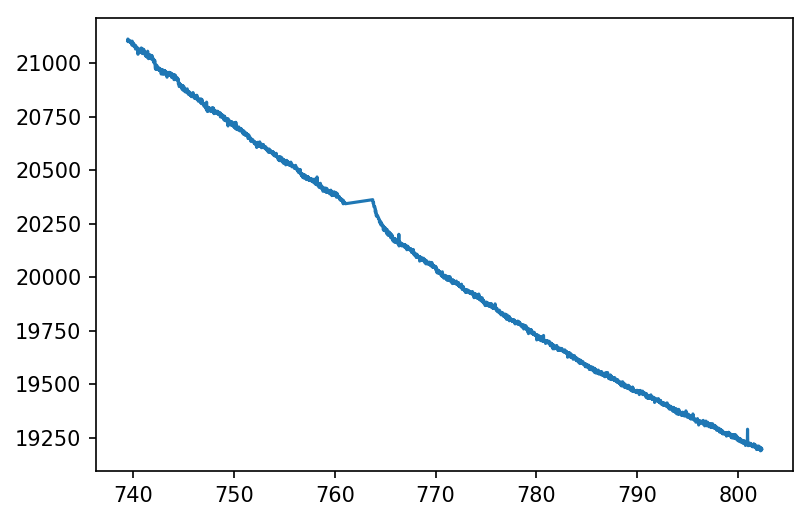

In [82]:
plt.plot(tpf2.time[200:], results[200:, 0])
plt.show()

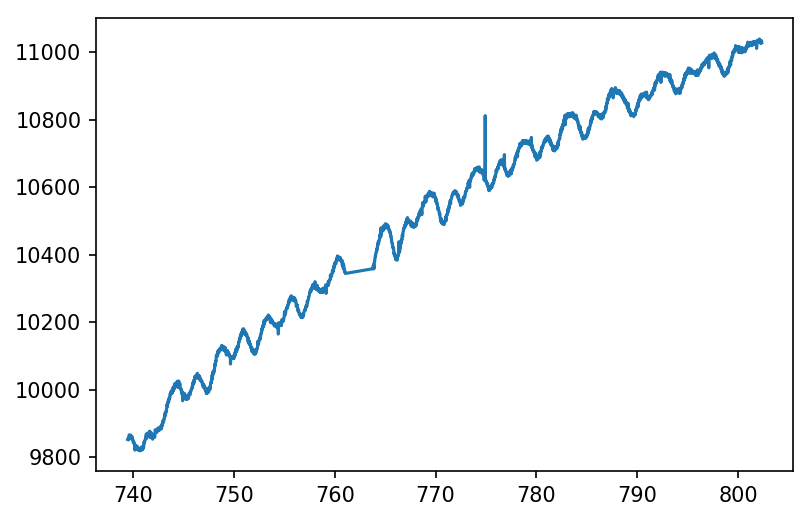

In [83]:
plt.plot(tpf2.time[200:], results[200:, 1])
plt.show()

In [84]:
lc1 = LightCurve(tpf2.time[200:], results[200:, 0])
lc2 = LightCurve(tpf2.time[200:], results[200:, 1])

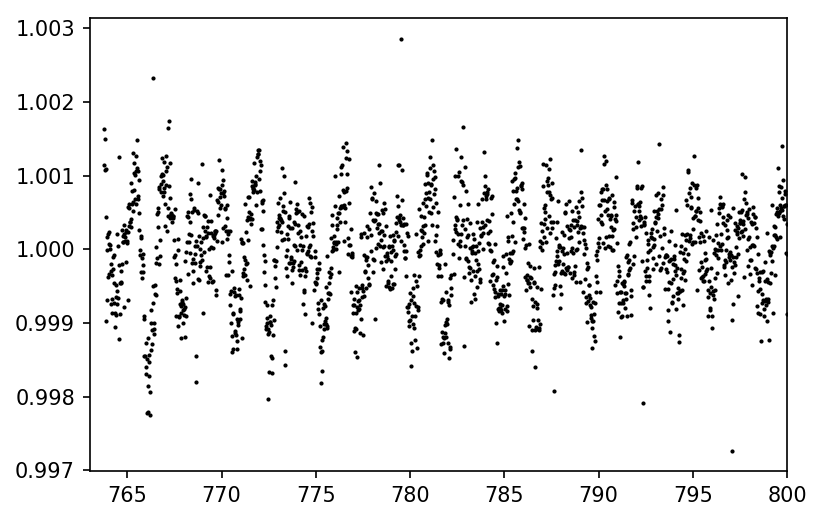

In [110]:
lc2fl = lc2.flatten().remove_outliers()
plt.plot(lc2fl.time, lc2fl.flux, 'k.', markersize=2)
plt.xlim(763, 800)
plt.show()